# Hackaton dismissal forecasting

## Table on contents:

1. [Fill N/A in initial data](#fill_na)
2. [Employee history validation](#empl_hist_validation)
3. **Data preprocessing:**
 - [Keep last hiring history](#last_hiring)
 - [Avoid Employees with short_history (<=6months)](#extra_history)
 
3.1 [Fix month on Position and Salary](#fix_monthOnPosition_Salary)
 - [Correct month on Position](#monthOnPosition_filtering)
 - [Correct month on Salary](#monthOnSalary_filtering)

3.2 [Total statistics vs. visualization](#total_statistics)

4. **Prepare to modeling: Feature engineering:**

4.1 [Validation before target creation](#validation_before_target)

4.2 [Create target](#create_target)

4.3 [Label Encodeing](#label_encoding)
 - [Mean_encoding](#mean_encoding)
 - [Frequency_encoding](#freq_encoding)
 - [Weight of Evidence(WoE)](#woe_encoding)
 - [backward_encoding](#backward_encoding)

5. [MODELING1: standard feature vector:Train, test, validation](#first_modeling)

5.1 [Tuning vs.results](#model1_tuning_results)

5.2 [Validate appy feature_vector on target file](#validation_apply_and_target)

5.3 [RESULT on target file](#result1_on_target)
6. [MODEL2: Long Feature Vector](#long_feat_vector)

6.1 [MODELING2: long feature_vector: Train, test, validation](#modeling_long_feat_vector)

6.2 [Apply MODEL2(with long feature vector) on target](#apply2_target_on_long_feat_vector)

6.3 [RESULT of applying MODEL2 on target](#result_on_apply2_long_feat_vector)


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import sklearn
from sklearn import datasets
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score,recall_score, f1_score
import pickle as pc
#import datetime 
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce   
from sklearn.preprocessing import LabelEncoder

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def set_values_to_plot(plot_obj):
    rects = plot_obj.patches
    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        # Number of points between bar and label. 
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'
        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'
        
        # Use Y value as label and format number without decimal place
        label = "{:.0f}".format(y_value)
        # Create annotation
        plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

In [4]:
employees = pd.read_csv('employees.csv')

In [5]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 3 columns):
EmployeeID       5937 non-null object
HiringDate       5937 non-null object
DismissalDate    875 non-null object
dtypes: object(3)
memory usage: 139.2+ KB


In [6]:
empl_history = pd.read_csv('history.csv')

In [7]:
empl_history['Date']= pd.to_datetime(empl_history['Date'], format='%Y-%m-%d')

In [8]:
empl_history.duplicated(subset=['EmployeeID', 'Date']).value_counts()

False    59328
dtype: int64

In [9]:
empl_history = empl_history.sort_values(['EmployeeID', 'Date'], ascending=[True, True])

In [10]:
empl_history.head()

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel
0  00028962-8E9F-496C-B544-526B24CA1BCF 2018-11-01         20.0    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          NaN             0             0                  0                  0       0              1.0              1                  0                  -1              8  2.049515             0   NaN              5
1  00028962-8E9F-496C-B544-526B24CA1BCF 2018-12-01         20.0    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          NaN             0             0                  0                  0       0              2.0              2                  0                  -1              8  2.049515             0   NaN              5
2  00028962-8E9F-496C-B544-526B24CA1BCF 2019-01-01         20.0    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  DFFA5CAC-1EAA-4572-B306-CB4053B8AE46                  1          NaN             8             0                  0                  0       0              3.0              3                  0                  -1              8  2.049515          1608   NaN              5
3  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01          3.0    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0          0.9            16             0                  0                  0       0             31.0             25                 15                   1              9  0.559347             0  59.0              2
4  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01          3.0    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0          1.0             0             0                  0                  0       0             32.0             26                 15                   1              9  0.559347             0  59.0              2

In [11]:
empl_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59328 entries, 0 to 59327
Data columns (total 25 columns):
EmployeeID            59328 non-null object
Date                  59328 non-null datetime64[ns]
DevCenterID           59323 non-null float64
SBUID                 59328 non-null int64
PositionID            59328 non-null int64
IsTrainee             59328 non-null int64
LanguageLevelID       59328 non-null int64
CustomerID            59328 non-null object
ProjectID             56559 non-null object
IsInternalProject     59328 non-null int64
Utilization           53698 non-null float64
HourVacation          59328 non-null int64
HourSickness          59328 non-null int64
HourMobileReserve     59328 non-null int64
HourLockedReserve     59328 non-null int64
OnSite                59328 non-null int64
MonthOnPosition       59327 non-null float64
MonthOnSalary         59328 non-null int64
CompetenceGroupID     59328 non-null int64
FunctionalOfficeID    59328 non-null int64
PaymentTypeId

In [12]:
empl_history.isnull().sum()

EmployeeID                0
Date                      0
DevCenterID               5
SBUID                     0
PositionID                0
IsTrainee                 0
LanguageLevelID           0
CustomerID                0
ProjectID              2769
IsInternalProject         0
Utilization            5630
HourVacation              0
HourSickness              0
HourMobileReserve         0
HourLockedReserve         0
OnSite                    0
MonthOnPosition           1
MonthOnSalary             0
CompetenceGroupID         0
FunctionalOfficeID        0
PaymentTypeId             0
Wage                      0
BonusOneTime              0
APM                   22605
PositionLevel             0
dtype: int64

In [13]:
empl_history.Utilization.unique()

array([   nan, 0.9   , 1.    , ..., 1.012 , 0.7528, 1.0326])

# Fill N/A in actual data
<a id="fill_na"></a>

In [14]:
empl_history.MonthOnPosition.isnull().value_counts()

False    59327
True         1
Name: MonthOnPosition, dtype: int64

In [15]:
empl_history.MonthOnPosition.fillna(1, inplace=True)

In [16]:
empl_history.Utilization.fillna(0, inplace=True)

In [17]:
empl_history.APM.unique()

array([         nan,  5.90000e+01,  3.70000e+01,  5.40000e+01,
        5.50000e+01,  5.20000e+01,  5.10000e+01,  4.50000e+01,
        7.00000e+01,  6.70000e+01,  6.60000e+01,  6.40000e+01,
        6.50000e+01,  9.90000e+01,  9.10000e+01,  6.80000e+01,
        7.20000e+01,  2.00000e+01,  6.00000e+00,  3.80000e+01,
        6.20000e+01,  6.00000e+01,  6.30000e+01,  5.80000e+01,
        1.00000e+00,  4.80000e+01, -3.20000e+01,  0.00000e+00,
       -1.64000e+02, -5.10000e+01, -8.10000e+01,  3.10000e+01,
       -4.90000e+01, -2.70000e+01, -2.40000e+01,  2.80000e+01,
        3.50000e+01,  3.00000e+01,  3.40000e+01,  3.30000e+01,
        3.20000e+01,  4.00000e+01, -3.40000e+01,  5.30000e+01,
        5.00000e+01,  5.60000e+01,  5.70000e+01,  4.60000e+01,
       -2.63000e+02,  4.40000e+01,  3.90000e+01,  4.30000e+01,
        4.70000e+01,  4.20000e+01,  1.00000e+01,  6.90000e+01,
        8.10000e+01,  7.90000e+01,  7.80000e+01,  7.60000e+01,
        7.50000e+01,  7.40000e+01,  7.10000e+01,  6.100

In [18]:
empl_history.APM.fillna(0, inplace=True)

In [19]:
empl_history.DevCenterID.fillna(0,inplace=True)

In [20]:
empl_history.isnull().sum()

EmployeeID               0
Date                     0
DevCenterID              0
SBUID                    0
PositionID               0
IsTrainee                0
LanguageLevelID          0
CustomerID               0
ProjectID             2769
IsInternalProject        0
Utilization              0
HourVacation             0
HourSickness             0
HourMobileReserve        0
HourLockedReserve        0
OnSite                   0
MonthOnPosition          0
MonthOnSalary            0
CompetenceGroupID        0
FunctionalOfficeID       0
PaymentTypeId            0
Wage                     0
BonusOneTime             0
APM                      0
PositionLevel            0
dtype: int64

In [21]:
empl_history['DevCenterID'] = empl_history['DevCenterID'].apply(np.int64)

In [22]:
empl_history['MonthOnPosition'] = empl_history['MonthOnPosition'].apply(np.int64)

## Total employee history by Date: 

In [23]:
hist = empl_history.groupby(['Date'])['EmployeeID'].nunique().reset_index(name='Count')
hist

Date  Count
0  2018-01-01   4227
1  2018-02-01   4313
2  2018-03-01   4310
3  2018-04-01   4338
4  2018-05-01   4357
5  2018-06-01   4385
6  2018-07-01   4419
7  2018-08-01   4519
8  2018-09-01   4653
9  2018-10-01   4776
10 2018-11-01   4897
11 2018-12-01   5016
12 2019-01-01   5118

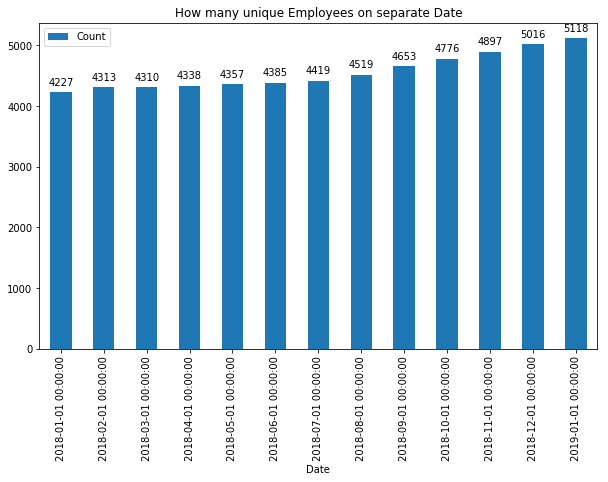

In [24]:
ax = hist.plot(x='Date', y='Count',kind='bar',figsize=(10, 6))
set_values_to_plot(ax)
plt.title('How many unique Employees on separate Date')
plt.show()

In [25]:
empl_history.Utilization.isnull().value_counts()

False    59328
Name: Utilization, dtype: int64

In [26]:
empl_history.columns

Index(['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite', 'MonthOnPosition', 'MonthOnSalary', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel'], dtype='object')

## Validation for empl_history: 
<a id="empl_hist_validation"></a>

In [27]:
wage0 = empl_history[empl_history['Wage']<=0]
len(wage0.EmployeeID.unique())

0

In [28]:
wage0.Wage.unique()

array([], dtype=float64)

In [29]:
empl_history.MonthOnSalary.max()

147

In [30]:
empl_history[empl_history['MonthOnSalary']==147]

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel
51947  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-03-01            1    105          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              147            147                  0                  -1              3  0.017076             0  0.0              0

In [31]:
empl_history.MonthOnPosition.max()

157

In [32]:
empl_history[empl_history['MonthOnPosition']==157.0][['Date','EmployeeID','MonthOnPosition', 'MonthOnSalary', 'Wage']]

Date                            EmployeeID  MonthOnPosition  MonthOnSalary      Wage
13450 2019-01-01  3C88FD47-7728-40D2-9098-354F5215E016              157              2  0.601134
24239 2019-01-01  693EED64-BCDE-4271-AA09-1C6B30594EC0              157              2  0.716294
33809 2019-01-01  9357B776-91AE-4727-BDC7-5B5FB25BC13C              157              8  0.740313
51957 2019-01-01  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A              157             10  0.037591

In [33]:
empl_history[empl_history['EmployeeID']=='E2B3EA83-3E66-4534-84AF-2E5EC348AE2A'].sort_values(['Date'])

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel
51945  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-01-01            1    105          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              145            145                  0                  -1              3  0.016986             0  0.0              0
51946  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-02-01            1    105          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              146            146                  0                  -1              3  0.017027             0  0.0              0
51947  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-03-01            1    105          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              147            147                  0                  -1              3  0.017076             0  0.0              0
51948  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-04-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              148              1                  0                  -1              3  0.039655             0  0.0              0
51949  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-05-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              149              2                  0                  -1             21  0.039954             0  0.0              0
51950  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-06-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              150              3                  0                  -1             21  0.040371             0  0.0              0
51951  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-07-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              151              4                  0                  -1             21  0.040628             0  0.0              0
51952  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-08-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              152              5                  0                  -1             21  0.041161             0  0.0              0
51953  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-09-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE

In [34]:
empl_history.head()

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel
0  00028962-8E9F-496C-B544-526B24CA1BCF 2018-11-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          0.0             0             0                  0                  0       0                1              1                  0                  -1              8  2.049515             0   0.0              5
1  00028962-8E9F-496C-B544-526B24CA1BCF 2018-12-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          0.0             0             0                  0                  0       0                2              2                  0                  -1              8  2.049515             0   0.0              5
2  00028962-8E9F-496C-B544-526B24CA1BCF 2019-01-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  DFFA5CAC-1EAA-4572-B306-CB4053B8AE46                  1          0.0             8             0                  0                  0       0                3              3                  0                  -1              8  2.049515          1608   0.0              5
3  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01            3    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0          0.9            16             0                  0                  0       0               31             25                 15                   1              9  0.559347             0  59.0              2
4  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01            3    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0          1.0             0             0                  0                  0       0               32             26                 15                   1              9  0.559347             0  59.0              2

In [35]:
gr = empl_history.groupby('EmployeeID')['MonthOnPosition'].first().reset_index(name='First')
gr

EmployeeID  First
0     00028962-8E9F-496C-B544-526B24CA1BCF      1
1     00116D71-E87D-4B64-A566-1F29B2A798A8     31
2     001502BB-B61A-404D-8A99-CC5DE5A4F985     74
3     0019ADB2-228D-4301-9899-9C2F10F6C1AA      1
4     0034ECA4-0562-4AC7-A826-4AE81C64D69F      6
5     00384806-F711-41BA-A924-8F27E996F891     23
6     0040B626-4578-4C4B-B3CB-42270CEAFF6C      2
7     00421442-2A6C-4324-87B7-2D8CF84CC16C      1
8     005B5FD6-FD19-4924-98E4-4C06F7F6BF2C      1
9     0061CAE7-B123-46B0-9BF7-E1E94E9AD80B     41
10    0067E602-E18F-4BBF-B746-60B8C56040EE      1
11    0069251B-E077-41BD-8A64-90151BDF9A02      1
12    006E332A-B32B-4858-BB97-9DBB659283F1      7
13    0074F2BF-ECEA-484A-9355-BE8EE3E8642F     57
14    00822DB1-D4CB-4B8F-AF02-1FA6B6A44528     14
15    0086EAF5-5A95-4E6B-B5EF-1B22CDF0538E     16
16    00885F06-FFEA-48F6-A338-3439FA676787      1
17    008CD18A-3AFA-446F-A95E-DDAA8E6E3C6F     38
18    009345FE-0A28-40FF-8E4F-968F2E7DCC8C      5
19    00965EE4-8EAD-40FB-81E0-DFAAF7BDA1CC      1
20    009E7541-4CA1-4748-AF90-76A85ABA7BC9      1
21    00A7B587-EFC6-4F19-9F9E-8E6EFB8872AC      2
22    00B70800-C2AC-4C2A-9203-22A0FA2B8502      3
23    00D8ADA1-6FFC-45E9-9BAB-943F3911CA6E      1
24    00DBB0F8-26A9-4CC5-9C22-49FA570390CD     10
25    00DDA8FB-5640-4311-B84C-B81719C24483    129
26    00E30C7A-3400-4A74-B5A8-1532C766DB24      1
27    00ED0622-A212-45EA-B1BD-17F4602B7807      1
28    00EDA2E5-78A3-4FB4-9EED-183E04A89523      4
29    00FCA5BD-57A9-4776-ACC4-5C87AAE0981B      4
30    00FECE8C-199E-4548-8E15-A181437B454C      1
31    01025CCA-0A17-4FC3-A263-65F014FC1BC8      1
32    0102F36E-A2E6-47A8-897D-8D0E0548C86E      5
33    0111ADE3-853E-4C6C-85F8-498D07DEE3EA     23
34    01156436-793E-493B-9CC4-3E0A0C485960      1
35    011DB389-9B2E-4C6C-83CD-6F91A91C9B80     29
36    0122067B-59DB-4844-BF7E-E7D3F1A30C52      1
37    012ADF75-5DA7-43FF-83AE-BC2CD70B82E0     13
38    013D332B-6F8E-4203-9C64-412659240181     14
39    013EAEAF-733A-4E91-B828-A277FE29A039     41
40    014D740B-7BC8-4D3B-B217-EFBB80031D61     12
41    01592627-19B1-4EE3-8BE3-9516C04A29BD     46
42    0165D804-D58C-4503-97E1-ED68D145FDC6     33
43    01833567-CE7D-462F-8570-550D8DAD128C      9
44    01897048-132F-4532-9DC8-317908E0CAF5     12
45    0189E23E-CCDB-4ACB-8A52-16954E08B495      1
46    018E2508-EA16-425A-93CC-AF61FAD752AF     39
47    019F007F-C0AC-4C4F-9983-56EB399A710C     35
48    01A07010-BA3B-4F00-B783-F54C4AD76A51      8
49    01B9C1BD-4E72-4DDA-AE32-E7F953F52A8D      4
50    01CA4274-3E4F-46BA-AA4F-516795D193D7     11
51    01D46824-D390-4B47-8EFE-FA0185FB717E      4
52    01DDE66C-877E-47FE-A9B0-75570D9FF3DF     15
53    01EA778C-04DD-4FD8-B25C-F002F80C48D5      8
54    01EC670D-45D5-4C37-AD4D-94F39A833D4A     33
55    01EDC1A7-5DA7-4939-854B-0002E0DF548D      1
56    01FC5C45-E917-4D99-B66D-0CCF06E50738      1
57    020BDFB4-C823-4D66-AB9C-BF5AEEFD1DD1      9
58    021C5074-AC15-45B0-A272-B6682CDB1EB4     14
59    021F7056-67EF-4793-B384-94964F286E87      6
60    0233BB50-5FFA-4F7E-BD35-877805AEAD4A      1
61    024834B1-1947-481B-80F6-DD7A058394C6      4
62    024DF0CF-6755-4C4C-9DD5-BA531B177075      1
63    0252EC1E-A025-44A3-8559-5C796368AA02      6
64    025E58AB-DAFC-4EC0-8BCB-2F42BDE1662E     24
65    02695875-3A84-4CAF-859E-CB31DF4BC04A     10
66    026B819A-E94F-42B8-B1B5-900438CBACBE      1
67    027E7A4C-A4CA-4803-9DB8-EBE090E89407      1
68    0281222B-F5F6-4CF9-B0DB-64E99D1E7AD7     26
69    02B39146-E71A-48F4-8108-F5AFF23641EC      1
70    02C04E0E-0B13-4098-97E5-450CE882CC6C      1
71    02C6F1BB-4DA1-4B87-9A69-958F614D0A96      7
72    02D4EDAA-33FC-4FCE-858A-5CAF8DBC5F73      2
73    02E81497-FDCE-4E14-82A1-7ADAAECEDDBE      1
74    02F75356-23D4-47BC-B9AD-D074785D5AC5      1
75    030D0549-62CA-4E34-B6FD-6D69604A8919      1
76    030D5D1F-FA3A-4912-A788-51A444CCC7AE      1
77    03172BD0-7551-42D3-9822-CBDC16389C2B      1
78    0343E6D7-BE25-4360-81A0-A339DFB29684     24
79    037AD2D1-2682-41D4-82B8-91

In [36]:
gr.shape

(5937, 2)

In [37]:
first_values = gr.sort_values(['First'], ascending=False)
first_values.First.unique()

array([145, 144, 140, 138, 129, 123, 114, 111, 110, 109, 108, 107, 106,
       105, 104, 103, 102, 100,  99,  98,  94,  92,  91,  90,  89,  88,
        87,  86,  85,  84,  83,  82,  80,  78,  77,  76,  75,  74,  73,
        72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,
        59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,
        46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,
        33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,
        20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,
         7,   6,   5,   4,   3,   2,   1], dtype=int64)

In [38]:
first_values = first_values.sort_values(by = ['First'],ascending=False)
first_values

EmployeeID  First
3143  88034931-97E7-4166-8753-1040D9069F28    145
5199  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
1373  3C88FD47-7728-40D2-9098-354F5215E016    145
2450  693EED64-BCDE-4271-AA09-1C6B30594EC0    145
3385  9357B776-91AE-4727-BDC7-5B5FB25BC13C    145
5392  EA2DE374-BEEC-4295-BB88-251A9C3F3446    145
700   202556A1-4F74-4C27-A3AC-E5558D7DEDF0    144
2743  750BB6E9-E412-4AAB-AEBA-8E08C591FC77    140
3207  8AD786AD-8634-47E7-AC9A-858D4C86CCE0    138
25    00DDA8FB-5640-4311-B84C-B81719C24483    129
5508  EDFC4E8B-1CBC-40E1-8828-3E81BC6BA37E    123
5200  E2C0A896-4AE0-4287-BE81-91B8D355F0D8    114
5531  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    114
4432  C19EB48B-E9D4-4C92-8321-1FE3FABA8D78    111
4764  D0A184D9-5467-41CD-8E08-A1DC324351DE    111
4853  D437958C-757D-45B0-B490-B00D04C38AE3    111
2988  807E5C69-D155-4FC8-9853-109815547B5C    111
3626  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    110
5913  FEC1A0AA-99F1-40F3-AF39-12ED714B7E8A    109
513   17D52F4C-9005-4A1E-B6B7-7A0E0478D6D9    109
1636  47AF5A4D-C1A0-4EB6-8B22-017CEB469E67    108
2200  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
4955  D879644C-87D3-4B44-B18D-DD991233E54F    107
5050  DD14BBCB-0246-460A-B007-FD24967039B8    107
2649  714EAB94-077C-4583-AFC2-B9635C66060C    106
5381  E9D183DF-C157-4D92-907E-987A369066E8    105
1645  4827FB21-0938-4EFD-A16E-8AB31861BD32    105
1755  4C55FFFA-0216-41BA-896D-26F15108AFCA    105
2199  5FEF8BAE-0234-4E07-B397-78E348578CAC    105
3750  A2B66702-D158-4A10-980A-6390E8DF3703    105
1403  3DE8BCDD-C345-43A1-A5D0-7D21FED3789E    105
2354  6556515F-573B-4211-B29F-08B9BA252638    104
5778  F9A66A16-A214-4D76-8263-42A8B8D0BE61    104
5226  E35AD257-2C78-4606-9881-2D8C08513283    104
99    043DE661-7639-4DA3-8374-BCFB84953099    104
3555  9A68FE61-A0C1-4CA4-9E02-73BE987B68BA    104
4734  CF01E3A8-1264-4D43-9CE7-2C9F6F64A2B6    103
1246  37C2BD64-FE96-48E4-988D-9459423DE95F    103
4484  C390AF86-EC94-4F04-91BB-A7B85A2BA490    103
5797  FA9F7256-FD28-47CB-9382-8CB3A34DDB55    102
5504  EDF55694-E086-49DA-93FE-840854CC165B    100
2136  5D8D775B-1132-4534-BCC9-DADD0AA98291    100
4442  C1F247BF-ED35-4EBA-9393-C9934DD805E0     99
1535  43C1D168-3C26-47A1-A162-5394CE4BD119     99
3124  86E7F234-9488-4738-A931-1029CE77DC6C     99
3855  A7F3F133-8C43-4FC9-ADC6-97CDC9F277E4     98
5012  DB38D981-AD24-44A0-82AC-234BD171B2A8     98
496   16F475A9-219D-4335-94D6-8B5926FD0596     94
3569  9B29C028-C3AF-473E-A6C5-AA3476F103C4     92
2702  7340E932-2A74-4185-9DA0-F75583B6E8C0     92
4464  C2BE6B35-24DB-4882-AB9C-A96363DA3052     92
3068  841ED2A5-043D-400F-B0B7-BC90CBCCE2DF     91
4808  D2A77884-CBCB-42DB-9454-DFEF25F31406     91
3726  A1AA62AB-5549-4CEC-BDA0-B51F84C2ACFD     91
2287  62FF5704-0B8A-4184-AFEE-06F7E26E1125     91
508   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     90
1192  350B6C8D-E344-4D18-8279-08EF1879F750     90
2361  65CAAC65-8E9A-4DF0-A649-E06EFA820785     90
608   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     90
183   089A5295-058B-44F0-B018-425A27B862E3     90
5411  EB2784C2-2E50-48D9-BACC-1B7DF433A73C     90
3653  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     90
2908  7CDD9E2E-F504-4542-9BF9-40AD56948475     90
1019  2D62A030-125B-48D1-90A1-3B9B908652E2     90
1513  42E03ADE-02E0-4754-84E3-06C664EF6EE0     90
468   16070401-18A1-4EAA-A9ED-E3EB84700AEB     90
2008  57ABEB68-781F-41FD-8431-4D69BE913EB6     89
4506  C4D51B85-D010-410D-A290-C18DD6D6CF6B     89
1062  2FAA0EFF-87B6-4A4D-B9A3-AD3A82A43795     89
3279  8E96EA6A-BC9D-4090-89C0-71D940B1D8B0     89
4755  D013DAF0-DC1F-45D1-8642-90931CFCD664     89
4720  CEB314D2-12C6-41B8-9D88-60A0DBF82B7A     89
3463  96344EE7-CD8A-4B7A-9A89-D42C20F6DA52     89
4117  B2852E2C-6CD0-4234-A20B-164CED9B45CF     89
79    037AD2D1-2682-41D4-82B8-9190420AE108     89
3744  A2523DBC-0490-4AD7-A2EB-2026192E4B07     89
999   2C43CED9-683D-480F-BE52-3492E054E762     89
1639  47C97537-AFCF-4379-A04F-045EECCB0619     89
2020  5826AAD2-8C8E-4348-8C56-1CFA4325CF62     89
4177  B5412CAC-B3AD-4E9B-A945-53

In [39]:
first_values.First.value_counts().sort_index()

1      1834
2       266
3       283
4       265
5       284
6       258
7       235
8       160
9       156
10      205
11      125
12      119
13       86
14       81
15       65
16       81
17       61
18       47
19       60
20       60
21       49
22       44
23       28
24       28
25       36
26       43
27       38
28       46
29       38
30       42
31       23
32       33
33       38
34       32
35       26
36       39
37       27
38       40
39       22
40       52
41       23
42       13
43       19
44       13
45       24
46       27
47        9
48       15
49       19
50       13
51       22
52       14
53        7
54        5
55        9
56       13
57        6
58        8
59        8
60        6
61        6
62       12
63        4
64        6
65        2
66        7
67        7
68        8
69        9
70        5
71        4
72        6
73        5
74       15
75        3
76        3
77        5
78        5
80        2
82        3
83        2
84        2
85        1
86  

In [40]:
first_values[first_values['First']>24][['First']].sum()

First    49334
dtype: int64

In [41]:
first_values[first_values['First']==64]

EmployeeID  First
2893  7C13E7E3-EE6B-490B-94F6-92F2F0684F28     64
3779  A47224C5-9A99-4955-B0D9-E17FE38AE03A     64
5634  F3AA72C9-2711-497F-97F2-45CAB4BAE37F     64
871   2733F07F-095C-49B3-88DB-043CA1847044     64
3400  93EFF1B4-FA83-43A8-BA61-9F3D10C99853     64
1052  2F3494C3-8F70-4C87-BE53-AA0B86CB91B1     64

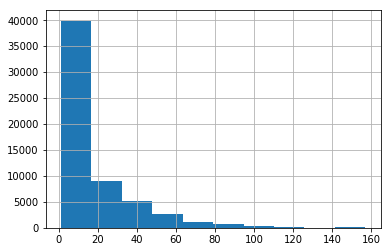

In [42]:
empl_history.MonthOnPosition.hist()

In [43]:
employees[employees['EmployeeID']=='E2B3EA83-3E66-4534-84AF-2E5EC348AE2A']

EmployeeID  HiringDate DismissalDate
15  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A  2002-01-01           NaN

In [44]:
employees[employees['EmployeeID']=='7C13E7E3-EE6B-490B-94F6-92F2F0684F28']

EmployeeID  HiringDate DismissalDate
813  7C13E7E3-EE6B-490B-94F6-92F2F0684F28  2012-09-01           NaN

In [45]:
empl_history[empl_history['EmployeeID']=='7C13E7E3-EE6B-490B-94F6-92F2F0684F28']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel
28608  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-01-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0             0             0                  0                  0       0               64             23                  0                  -1              3  0.048228             0  0.0              1
28609  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-02-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0             0             0                  0                  0       0               65             24                  0                  -1              3  0.048344             0  0.0              1
28610  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-03-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0             0             0                  0                  0       0               66             25                  0                  -1              3  0.048483             0  0.0              1
28611  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-04-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0            64             0                  0                  0       0               67             26                  0                  -1              3  0.049259             0  0.0              1
28612  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-05-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0             0             0                  0                  0       0               68             27                  0                  -1             21  0.049630             0  0.0              1
28613  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-06-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0             0             0                  0                  0       0               69             28                  0                  -1             21  0.050149            95  0.0              1
28614  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-07-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0           112             0                  0                  0       0               70             29                  0                  -1             21  0.050467             0  0.0              1
28615  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-08-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1          0.0             0             0                  0                  0       0               71             30                  0                  -1             21  0.051130             0  0.0              1
28616  7C13E7E3-EE6B-490B-94F6-92F2F0684F28 2018-09-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB

In [46]:
empl_history[empl_history['EmployeeID']=='062633BB-0A97-4723-8FBB-484FBD372A30']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel
1292  062633BB-0A97-4723-8FBB-484FBD372A30 2018-04-01            1    358           3          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0             0             0                  0                  0       0               18              1                 22                  -1              9  0.866001             0  0.0              2
1293  062633BB-0A97-4723-8FBB-484FBD372A30 2018-05-01            1    358           3          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0             0             0                  0                  0       0               19              1                 22                   0             22  0.874885           150  0.0              2
1294  062633BB-0A97-4723-8FBB-484FBD372A30 2018-06-01            1    358           3          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0             0             0                  0                  0       0               20              2                 22                   0             22  0.874885             0  0.0              2
1295  062633BB-0A97-4723-8FBB-484FBD372A30 2018-07-01            1    358           3          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0             0             0                  0                  0       0               21              3                 22                   0             22  0.874885           200  0.0              2
1296  062633BB-0A97-4723-8FBB-484FBD372A30 2018-08-01            1    358           4          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0             0             0                  0                  0       0                1              4                 22                   0             22  0.874885             0  0.0              3
1297  062633BB-0A97-4723-8FBB-484FBD372A30 2018-09-01            1    358           4          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0            80             0                  0                  0       0                2              5                 22                   0             22  0.874885             0  0.0              3
1298  062633BB-0A97-4723-8FBB-484FBD372A30 2018-10-01            1    358           4          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0             8             0                  0                  0       0                3              6                 22                   0             22  0.874885             0  0.0              3
1299  062633BB-0A97-4723-8FBB-484FBD372A30 2018-11-01            1    358           4          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846                  1          0.0             0             0                  0                  0       0                4              7                 22                   0             22  0.874885             0  0.0              3
1300  062633BB-0A97-4723-8FBB-484FBD372A30 2018-12-01            1    358           4          0               11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  B69F016E-5B1C-4750-BF3F-6766A70B9846         

In [47]:
list_empl = employees.EmployeeID.unique()
extra = empl_history[empl_history['EmployeeID'].isin(list_empl)==True]
len(employees.EmployeeID.unique()), len(extra.EmployeeID.unique())

(5937, 5937)

In [48]:
len(empl_history.EmployeeID.unique())

5937

In [49]:
inter = list(set(employees.EmployeeID.unique()).intersection(set(empl_history.EmployeeID.unique())))
len(inter)

5937

# Data preprocessing

# 1. Keep last hiring
<a id="last_hiring"></a>

**In case if employee was Dismissed and Hired again, so we suggest to keep only LastHiringDate, old extra history of Employee is Out of Scope**

# Keep only last hiring:

In [50]:
data_preparation = pd.merge(empl_history, employees, on='EmployeeID', how='left')

In [51]:
data_preparation.DismissalDate.isnull().value_counts()

True     53859
False     5469
Name: DismissalDate, dtype: int64

In [52]:
data_preparation['HiringDate'] = pd.to_datetime(data_preparation['HiringDate'] , format='%Y-%m-%d')

In [53]:
data_preparation['DismissalDate'] = pd.to_datetime(data_preparation['DismissalDate'] , format='%Y-%m-%d')

In [54]:
def checkHiringDate(gr):
    gr['Hired'] = np.where(gr['Date']<= gr['HiringDate'], 1, 0)
    return gr

In [55]:
data_filt = data_preparation.groupby('EmployeeID').apply(checkHiringDate)


In [56]:
data_filt.Hired.value_counts()

0    57404
1     1924
Name: Hired, dtype: int64

In [57]:
data_filt[data_filt['EmployeeID']=='FFF3B179-1D20-40FF-A330-A051BDF37301']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired
59318  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-04-01            1    295           1          1               18  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  88B1FB1F-A006-469B-8E7D-FAF4C07D9B8C                  1       0.0000             0             0                  0                  0       0                1              1                 22                  -1              3  0.105289             0   0.0              0 2018-04-01           NaT      1
59319  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-05-01            1    295           1          1               18  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  88B1FB1F-A006-469B-8E7D-FAF4C07D9B8C                  1       0.0000             0             0                  0                  0       0                2              1                 22                   0             20  0.120753             0   0.0              0 2018-04-01           NaT      0
59320  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-06-01            1    295           1          1               18  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  88B1FB1F-A006-469B-8E7D-FAF4C07D9B8C                  1       0.0000            16             0                  0                  0       0                3              2                 22                   0             20  0.120753             0   0.0              0 2018-04-01           NaT      0
59321  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-07-01            1    295           1          1               18  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  88B1FB1F-A006-469B-8E7D-FAF4C07D9B8C                  1       0.0000             0             0                  0                  0       0                4              3                 22                   0             20  0.120753             0   0.0              0 2018-04-01           NaT      0
59322  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-08-01            1    295           1          1               18  9417F950-B661-48E8-84CF-8DDB1F8FDB50  56FF7210-52AF-4E4D-BEE9-3411E73BF063                  0       0.7528            88             0                  0                  0       0                5              4                 22                   0             22  0.117792             0  85.0              0 2018-04-01           NaT      0
59323  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-09-01            1    295           2          1               18  9417F950-B661-48E8-84CF-8DDB1F8FDB50  56FF7210-52AF-4E4D-BEE9-3411E73BF063                  0       1.0511             0             0                  0                  0       0                1              1                 22                   0             22  0.148063             0  73.0              1 2018-04-01           NaT      0
59324  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-10-01            1    295           2          1               18  9417F950-B661-48E8-84CF-8DDB1F8FDB50  56FF7210-52AF-4E4D-BEE9-3411E73BF063                  0       1.0326             8             0                  0                  0       0                2              2                 22                   0             22  0.148063             0  73.0              1 2018-04-01           NaT      0
59325  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-11-01            1    295           2          0               18  9417F950-B661-48E8-84CF-8DDB1F8FDB50  56FF7210-52AF-4E4D-BEE9-3411E73BF063                  0       1.0284             0             0                  0                  0       0                3              3                 22      

In [58]:
import datetime
def get_actual_hiring_history(adf):
    adf = adf.sort_values(by="Date").reset_index(drop=True)
    indx = adf.where(((adf['Hired'] == 0) & (adf['Date'] == adf['Date'].min())) |
                     (adf['Hired'] == 1)).last_valid_index()
    return adf.iloc[range(indx, len(adf))]

def filter_EmployeeHist_by_HiringDate(df_test):
    start_time = datetime.datetime.now()
    print('Start_time=', start_time)
    RESULT_EMPL_HIST = df_test.groupby('EmployeeID').apply(lambda x: get_actual_hiring_history(x))
    print("--- %s seconds ---" % (datetime.datetime.now() - start_time))
    RESULT_EMPL_HIST.reset_index(drop=True, inplace=True)
    # RESULT_Q.drop(columns=['level_1'], inplace=True)
    return RESULT_EMPL_HIST

In [59]:
data_filt=data_filt.sort_values(by=['EmployeeID', 'Date'], ascending=[True, True])


In [60]:
result_EMPL_HIST = filter_EmployeeHist_by_HiringDate(data_filt)

Start_time= 2020-05-01 17:35:11.931946
--- 0:01:17.218690 seconds ---


In [61]:
len(result_EMPL_HIST.EmployeeID.unique())

5937

In [62]:
def checkDismissalDate(gr):
    gr['Dismissed'] = np.where((gr['DismissalDate'].isnull()==False) &(gr['Date']== gr['DismissalDate']), 1, 0)
    return gr

In [63]:
result_DISM_DATE = result_EMPL_HIST.groupby('EmployeeID').apply(checkDismissalDate)

In [64]:
result_DISM_DATE[result_DISM_DATE['DismissalDate'].isnull()==False]

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime     APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed
16     001502BB-B61A-404D-8A99-CC5DE5A4F985 2018-01-01            1     55         203          0               20  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F                                   NaN                  1       0.0000             0             0                  0                  0       0               74             61                 23                   0              1  0.419840             0     0.0              2 2008-02-01    2018-03-01      0          0
17     001502BB-B61A-404D-8A99-CC5DE5A4F985 2018-02-01            1     55         203          0               20  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F                                   NaN                  1       0.0000             0             0                  0                  0       0               75             62                 23                   0              1  0.419840             0     0.0              2 2008-02-01    2018-03-01      0          0
18     001502BB-B61A-404D-8A99-CC5DE5A4F985 2018-03-01            1     55         203          0               20  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F                                   NaN                  1       0.0000             0             0                  0                  0       0               76             63                 23                   0              1  0.419840             0     0.0              2 2008-02-01    2018-03-01      0          1
48     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-01-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1       0.0000             0             0                  0                  0       0                2              2                 15                   1              9  0.173069             0     0.0              0 2017-12-01    2018-06-01      0          0
49     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-02-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1       0.0000             0             0                136                  0       0                3              3                 15                   1              9  0.173069             0     0.0              0 2017-12-01    2018-06-01      0          0
50     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-03-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1       0.0000             0             0                176                  0       0                4              4                 15                   1              9  0.173069             0     0.0              0 2017-12-01    2018-06-01      0          0
51     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-04-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1       0.0000             0             0                152                  0       0                5              5                 15                   1              9  0.173069             0     0.0              0 2017-12-01    2018-06-01      0          0
52     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-05-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1       0.0000            40             

In [65]:
result_DISM_DATE[result_DISM_DATE['EmployeeID']=='0040B626-4578-4C4B-B3CB-42270CEAFF6C']#FF9D0956-E4DC-47D4-85BA-C0C3F852824B

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed
48  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-01-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                2              2                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0
49  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-02-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0             0             0                136                  0       0                3              3                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0
50  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-03-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0             0             0                176                  0       0                4              4                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0
51  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-04-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0             0             0                152                  0       0                5              5                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0
52  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-05-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0            40             0                160                  0       0                6              1                 15                   1             22  0.182281             0  0.0              0 2017-12-01    2018-06-01      0          0
53  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-06-01            2    255          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0            16             0                168                  0       0                7              2                 15                   1             22  0.182281             0  0.0              0 2017-12-01    2018-06-01      0          1

In [66]:
result_DISM_DATE.Dismissed.value_counts()

0    58344
1      868
Name: Dismissed, dtype: int64

# 2. Clear extra history for Employees:
<a id="extra_history"></a>

**We would like to keep only Employess with more than 6 months of working history in SoftServe**

In [67]:
result_DISM_DATE.duplicated().value_counts()

False    59212
dtype: int64

In [68]:
result_DISM_DATE[result_DISM_DATE['EmployeeID']=='119D0E1D-E7AF-4F85-93DA-2748F7BC9169']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed
3613  119D0E1D-E7AF-4F85-93DA-2748F7BC9169 2018-08-01            1    468           2          0                9  05E46CE0-DF49-447A-AD21-201AFE141885  584BC8C4-ED22-48CE-BD20-5B7EB0D30C57                  0       1.0000            40             0                  0                  0       0                1              1                 22                  -1             22  0.286254             0   0.0              1 2018-08-01    2018-12-01      1          0
3614  119D0E1D-E7AF-4F85-93DA-2748F7BC9169 2018-09-01            1    468           2          0                9  05E46CE0-DF49-447A-AD21-201AFE141885  584BC8C4-ED22-48CE-BD20-5B7EB0D30C57                  0       1.0000            32             0                  0                  0       0                1              2                 22                   0             22  0.286254             0  60.0              1 2018-08-01    2018-12-01      0          0
3615  119D0E1D-E7AF-4F85-93DA-2748F7BC9169 2018-10-01            1    468           2          0                9  05E46CE0-DF49-447A-AD21-201AFE141885  584BC8C4-ED22-48CE-BD20-5B7EB0D30C57                  0       1.0263             0            16                  0                  0       0                1              3                 22                   0             22  0.286254             0  60.0              1 2018-08-01    2018-12-01      0          0
3616  119D0E1D-E7AF-4F85-93DA-2748F7BC9169 2018-11-01            1    468           2          0                9  05E46CE0-DF49-447A-AD21-201AFE141885  584BC8C4-ED22-48CE-BD20-5B7EB0D30C57                  0       1.0344             0            16                  0                  0       0                1              4                 22                   0             22  0.286254             0  61.0              1 2018-08-01    2018-12-01      0          0
3617  119D0E1D-E7AF-4F85-93DA-2748F7BC9169 2018-12-01            1    468           2          0                9  05E46CE0-DF49-447A-AD21-201AFE141885  584BC8C4-ED22-48CE-BD20-5B7EB0D30C57                  0       1.0341            24             0                  0                  0       0                1              5                 22                   0             22  0.286254             0  60.0              1 2018-08-01    2018-12-01      0          1

In [69]:
date_gr = result_DISM_DATE.groupby(['EmployeeID'])['Date'].nunique().reset_index(name='Date_counts')
date_gr

EmployeeID  Date_counts
0     00028962-8E9F-496C-B544-526B24CA1BCF            3
1     00116D71-E87D-4B64-A566-1F29B2A798A8           13
2     001502BB-B61A-404D-8A99-CC5DE5A4F985            3
3     0019ADB2-228D-4301-9899-9C2F10F6C1AA            3
4     0034ECA4-0562-4AC7-A826-4AE81C64D69F           13
5     00384806-F711-41BA-A924-8F27E996F891           13
6     0040B626-4578-4C4B-B3CB-42270CEAFF6C            6
7     00421442-2A6C-4324-87B7-2D8CF84CC16C            1
8     005B5FD6-FD19-4924-98E4-4C06F7F6BF2C            6
9     0061CAE7-B123-46B0-9BF7-E1E94E9AD80B           13
10    0067E602-E18F-4BBF-B746-60B8C56040EE            1
11    0069251B-E077-41BD-8A64-90151BDF9A02            4
12    006E332A-B32B-4858-BB97-9DBB659283F1           13
13    0074F2BF-ECEA-484A-9355-BE8EE3E8642F           13
14    00822DB1-D4CB-4B8F-AF02-1FA6B6A44528           13
15    0086EAF5-5A95-4E6B-B5EF-1B22CDF0538E           13
16    00885F06-FFEA-48F6-A338-3439FA676787            9
17    008CD18A-3AFA-446F-A95E-DDAA8E6E3C6F           13
18    009345FE-0A28-40FF-8E4F-968F2E7DCC8C            3
19    00965EE4-8EAD-40FB-81E0-DFAAF7BDA1CC           12
20    009E7541-4CA1-4748-AF90-76A85ABA7BC9            5
21    00A7B587-EFC6-4F19-9F9E-8E6EFB8872AC           13
22    00B70800-C2AC-4C2A-9203-22A0FA2B8502           13
23    00D8ADA1-6FFC-45E9-9BAB-943F3911CA6E            2
24    00DBB0F8-26A9-4CC5-9C22-49FA570390CD           13
25    00DDA8FB-5640-4311-B84C-B81719C24483           13
26    00E30C7A-3400-4A74-B5A8-1532C766DB24            6
27    00ED0622-A212-45EA-B1BD-17F4602B7807           10
28    00EDA2E5-78A3-4FB4-9EED-183E04A89523           12
29    00FCA5BD-57A9-4776-ACC4-5C87AAE0981B           13
30    00FECE8C-199E-4548-8E15-A181437B454C            7
31    01025CCA-0A17-4FC3-A263-65F014FC1BC8            2
32    0102F36E-A2E6-47A8-897D-8D0E0548C86E           13
33    0111ADE3-853E-4C6C-85F8-498D07DEE3EA           13
34    01156436-793E-493B-9CC4-3E0A0C485960            5
35    011DB389-9B2E-4C6C-83CD-6F91A91C9B80           13
36    0122067B-59DB-4844-BF7E-E7D3F1A30C52            1
37    012ADF75-5DA7-43FF-83AE-BC2CD70B82E0           13
38    013D332B-6F8E-4203-9C64-412659240181           13
39    013EAEAF-733A-4E91-B828-A277FE29A039           13
40    014D740B-7BC8-4D3B-B217-EFBB80031D61           13
41    01592627-19B1-4EE3-8BE3-9516C04A29BD           13
42    0165D804-D58C-4503-97E1-ED68D145FDC6           13
43    01833567-CE7D-462F-8570-550D8DAD128C           13
44    01897048-132F-4532-9DC8-317908E0CAF5           13
45    0189E23E-CCDB-4ACB-8A52-16954E08B495            6
46    018E2508-EA16-425A-93CC-AF61FAD752AF           13
47    019F007F-C0AC-4C4F-9983-56EB399A710C           13
48    01A07010-BA3B-4F00-B783-F54C4AD76A51           13
49    01B9C1BD-4E72-4DDA-AE32-E7F953F52A8D           13
50    01CA4274-3E4F-46BA-AA4F-516795D193D7           13
51    01D46824-D390-4B47-8EFE-FA0185FB717E           13
52    01DDE66C-877E-47FE-A9B0-75570D9FF3DF            7
53    01EA778C-04DD-4FD8-B25C-F002F80C48D5           13
54    01EC670D-45D5-4C37-AD4D-94F39A833D4A           13
55    01EDC1A7-5DA7-4939-854B-0002E0DF548D            6
56    01FC5C45-E917-4D99-B66D-0CCF06E50738            3
57    020BDFB4-C823-4D66-AB9C-BF5AEEFD1DD1            2
58    021C5074-AC15-45B0-A272-B6682CDB1EB4           10
59    021F7056-67EF-4793-B384-94964F286E87           13
60    0233BB50-5FFA-4F7E-BD35-877805AEAD4A            5
61    024834B1-1947-481B-80F6-DD7A058394C6           13
62    024DF0CF-6755-4C4C-9DD5-BA531B177075            1
63    0252EC1E-A025-44A3-8559-5C796368AA02           13
64    025E58AB-DAFC-4EC0-8BCB-2F42BDE1662E           13
65    02695875-3A84-4CAF-859E-CB31DF4BC04A           13
66    026B819A-E94F-42B8-B1B5-900438CBACBE            5
67    027E7A4C-A4CA-4803-9DB8-EBE090E89407            9
68    0281222B-F5F6-4CF9-B0DB-64E99D1E7AD7           13
69    02B39146-E71A-48F4-8108-F5AFF23641EC            3
70    02C04E0E-0B13-4098-97E5-450CE882CC6C           11


In [70]:
date_gr[date_gr['EmployeeID']=='119D0E1D-E7AF-4F85-93DA-2748F7BC9169']

EmployeeID  Date_counts
377  119D0E1D-E7AF-4F85-93DA-2748F7BC9169            5

In [71]:
result_DISM_DATE[result_DISM_DATE['EmployeeID']=='00028962-8E9F-496C-B544-526B24CA1BCF']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed
0  00028962-8E9F-496C-B544-526B24CA1BCF 2018-11-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          0.0             0             0                  0                  0       0                1              1                  0                  -1              8  2.049515             0  0.0              5 2018-11-01           NaT      1          0
1  00028962-8E9F-496C-B544-526B24CA1BCF 2018-12-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          0.0             0             0                  0                  0       0                2              2                  0                  -1              8  2.049515             0  0.0              5 2018-11-01           NaT      0          0
2  00028962-8E9F-496C-B544-526B24CA1BCF 2019-01-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  DFFA5CAC-1EAA-4572-B306-CB4053B8AE46                  1          0.0             8             0                  0                  0       0                3              3                  0                  -1              8  2.049515          1608  0.0              5 2018-11-01           NaT      0          0

In [72]:
#
result_DISM_DATE[result_DISM_DATE['EmployeeID']=='00421442-2A6C-4324-87B7-2D8CF84CC16C']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed
54  00421442-2A6C-4324-87B7-2D8CF84CC16C 2019-01-01            5     50        1093          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  0FFBD95C-8A48-49F0-8B5F-562EB9907017                  1          0.0             0             0                  0                  0       0                1              1                  0                  -1             21  0.240519             0  0.0              1 2019-01-01           NaT      1          0

In [73]:
date_gr.Date_counts.unique()

array([ 3, 13,  6,  1,  4,  9, 12,  5,  2, 10,  7, 11,  8], dtype=int64)

In [74]:
to_delete = date_gr[date_gr['Date_counts']<6]
len(to_delete.EmployeeID.unique())

1311

In [75]:
to_delete.EmployeeID.unique()

array(['00028962-8E9F-496C-B544-526B24CA1BCF',
       '001502BB-B61A-404D-8A99-CC5DE5A4F985',
       '0019ADB2-228D-4301-9899-9C2F10F6C1AA', ...,
       'FF85299F-C2F8-48D0-B362-A0FE18A17148',
       'FFA67FC0-7E99-489C-BE06-9AFB59A2A5D1',
       'FFE6C235-82BE-49EA-A9DF-D878A9E348A5'], dtype=object)

In [76]:
actual_employees= date_gr[date_gr['Date_counts']>=6]
actual_employees_list = actual_employees.EmployeeID.unique()

In [77]:
len(actual_employees_list)

4626

In [737]:
4626+1311 # 1311 there are Employees is out of scope

5937

## Filtering results:
<a id="filtering_results"></a>

**So, we keep only 4626 EmployeeIDs, these set of Employees have more than 6 months of history**


In [79]:
empl_history_filt = result_DISM_DATE[result_DISM_DATE['EmployeeID'].isin(actual_employees_list)==True]
len(empl_history_filt.EmployeeID.unique())

4626

In [80]:
empl_history_filt[empl_history_filt['EmployeeID']=='00DDA8FB-5640-4311-B84C-B81719C24483']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed
214  00DDA8FB-5640-4311-B84C-B81719C24483 2018-01-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              129              1                  0                  -1              3  0.019412             0  0.0              0 2007-04-01           NaT      0          0
215  00DDA8FB-5640-4311-B84C-B81719C24483 2018-02-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              130              2                  0                  -1              3  0.019459             0  0.0              0 2007-04-01           NaT      0          0
216  00DDA8FB-5640-4311-B84C-B81719C24483 2018-03-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              131              3                  0                  -1              3  0.019515             0  0.0              0 2007-04-01           NaT      0          0
217  00DDA8FB-5640-4311-B84C-B81719C24483 2018-04-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              132              4                  0                  -1              3  0.019827             0  0.0              0 2007-04-01           NaT      0          0
218  00DDA8FB-5640-4311-B84C-B81719C24483 2018-05-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              133              5                  0                  -1             21  0.019977             0  0.0              0 2007-04-01           NaT      0          0
219  00DDA8FB-5640-4311-B84C-B81719C24483 2018-06-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              134              6                  0                  -1             21  0.020186             0  0.0              0 2007-04-01           NaT      0          0
220  00DDA8FB-5640-4311-B84C-B81719C24483 2018-07-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              135              7                  0                  -1             21  0.020314             0  0.0              0 2007-04-01           NaT      0          0
221  00DDA8FB-5640-4311-B84C-B81719C24483 2018-08-01            1    105          22          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                  1          0.0             0             0                  0                  0       0              136              8                  0                  -1             21  0.020581             0  0.0              0 2007-04-01           NaT      0          0
222  00DDA8FB-5640-4311-B84C-B81719C24483 2018-09-01            1    10

In [81]:
empl_history_filt[empl_history_filt['EmployeeID']=='3406D90B-F774-4E3A-81EB-C28C5E6D21CE']#'119D0E1D-E7AF-4F85-93DA-2748F7BC9169']

Empty DataFrame
Columns: [EmployeeID, Date, DevCenterID, SBUID, PositionID, IsTrainee, LanguageLevelID, CustomerID, ProjectID, IsInternalProject, Utilization, HourVacation, HourSickness, HourMobileReserve, HourLockedReserve, OnSite, MonthOnPosition, MonthOnSalary, CompetenceGroupID, FunctionalOfficeID, PaymentTypeId, Wage, BonusOneTime, APM, PositionLevel, HiringDate, DismissalDate, Hired, Dismissed]
Index: []

## 2. Fix MonthOnPosition and MonthOnSalary:
<a id="fix_monthOnPosition_Salary"></a>

[2.1.MonthOnPosition](#monthOnPosition_filtering)

[2.2.MonthOnSalary](#monthOnSalary_filtering)

Initial empl_history has a high border for MonthOnPosition for people who was Hired a long year ago. Experimentally, we decided to limit the top border of MonthOnSalary &MonthOnPosition variable with value 36 months.

### 2.1.MonthOnPosition
<a id="monthOnPosition_filtering"></a>

In [82]:
gr = empl_history_filt.groupby('EmployeeID')['MonthOnPosition'].first().reset_index(name='First')
gr = gr.sort_values(by=['First'], ascending=False)
gr

EmployeeID  First
4198  EA2DE374-BEEC-4295-BB88-251A9C3F3446    145
1045  3C88FD47-7728-40D2-9098-354F5215E016    145
2634  9357B776-91AE-4727-BDC7-5B5FB25BC13C    145
1882  693EED64-BCDE-4271-AA09-1C6B30594EC0    145
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
2432  88034931-97E7-4166-8753-1040D9069F28    145
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0    144
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77    140
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0    138
16    00DDA8FB-5640-4311-B84C-B81719C24483    129
4291  EDFC4E8B-1CBC-40E1-8828-3E81BC6BA37E    123
4050  E2C0A896-4AE0-4287-BE81-91B8D355F0D8    114
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    114
3456  C19EB48B-E9D4-4C92-8321-1FE3FABA8D78    111
3782  D437958C-757D-45B0-B490-B00D04C38AE3    111
3719  D0A184D9-5467-41CD-8E08-A1DC324351DE    111
2299  807E5C69-D155-4FC8-9853-109815547B5C    111
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    110
394   17D52F4C-9005-4A1E-B6B7-7A0E0478D6D9    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
1259  47AF5A4D-C1A0-4EB6-8B22-017CEB469E67    108
3862  D879644C-87D3-4B44-B18D-DD991233E54F    107
3934  DD14BBCB-0246-460A-B007-FD24967039B8    107
2033  714EAB94-077C-4583-AFC2-B9635C66060C    106
1689  5FEF8BAE-0234-4E07-B397-78E348578CAC    105
1268  4827FB21-0938-4EFD-A16E-8AB31861BD32    105
2923  A2B66702-D158-4A10-980A-6390E8DF3703    105
1355  4C55FFFA-0216-41BA-896D-26F15108AFCA    105
4189  E9D183DF-C157-4D92-907E-987A369066E8    105
1072  3DE8BCDD-C345-43A1-A5D0-7D21FED3789E    105
2769  9A68FE61-A0C1-4CA4-9E02-73BE987B68BA    104
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    104
4071  E35AD257-2C78-4606-9881-2D8C08513283    104
75    043DE661-7639-4DA3-8374-BCFB84953099    104
1805  6556515F-573B-4211-B29F-08B9BA252638    104
950   37C2BD64-FE96-48E4-988D-9459423DE95F    103
3691  CF01E3A8-1264-4D43-9CE7-2C9F6F64A2B6    103
3495  C390AF86-EC94-4F04-91BB-A7B85A2BA490    103
4515  FA9F7256-FD28-47CB-9382-8CB3A34DDB55    102
1645  5D8D775B-1132-4534-BCC9-DADD0AA98291    100
4287  EDF55694-E086-49DA-93FE-840854CC165B    100
2413  86E7F234-9488-4738-A931-1029CE77DC6C     99
1180  43C1D168-3C26-47A1-A162-5394CE4BD119     99
3464  C1F247BF-ED35-4EBA-9393-C9934DD805E0     99
3002  A7F3F133-8C43-4FC9-ADC6-97CDC9F277E4     98
3905  DB38D981-AD24-44A0-82AC-234BD171B2A8     98
378   16F475A9-219D-4335-94D6-8B5926FD0596     94
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     92
3478  C2BE6B35-24DB-4882-AB9C-A96363DA3052     92
2778  9B29C028-C3AF-473E-A6C5-AA3476F103C4     92
2901  A1AA62AB-5549-4CEC-BDA0-B51F84C2ACFD     91
1757  62FF5704-0B8A-4184-AFEE-06F7E26E1125     91
3748  D2A77884-CBCB-42DB-9454-DFEF25F31406     91
2367  841ED2A5-043D-400F-B0B7-BC90CBCCE2DF     91
4212  EB2784C2-2E50-48D9-BACC-1B7DF433A73C     90
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     90
143   089A5295-058B-44F0-B018-425A27B862E3     90
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     90
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     90
782   2D62A030-125B-48D1-90A1-3B9B908652E2     90
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     90
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     90
911   350B6C8D-E344-4D18-8279-08EF1879F750     90
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     90
59    037AD2D1-2682-41D4-82B8-9190420AE108     89
812   2FAA0EFF-87B6-4A4D-B9A3-AD3A82A43795     89
766   2C43CED9-683D-480F-BE52-3492E054E762     89
3710  D013DAF0-DC1F-45D1-8642-90931CFCD664     89
3679  CEB314D2-12C6-41B8-9D88-60A0DBF82B7A     89
3513  C4D51B85-D010-410D-A290-C18DD6D6CF6B     89
1262  47C97537-AFCF-4379-A04F-045EECCB0619     89
3259  B5412CAC-B3AD-4E9B-A945-53E45537E713     89
2917  A2523DBC-0490-4AD7-A2EB-2026192E4B07     89
1554  57ABEB68-781F-41FD-8431-4D69BE913EB6     89
1560  5826AAD2-8C8E-4348-8C56-1CFA4325CF62     89
581   227B67A7-3EE0-4344-8627-405BFDBDD00D     89
3211  B2852E2C-6CD0-4234-A20B-164CED9B45CF     89
2693  96344EE7-CD8A-4B7A-9A89-D42C20F6DA52     89
2548  8E96EA6A-BC9D-4090-89C0-71D940B1D8B0     89
4541  FBE12B00-0AAE-429B-8423-06

In [83]:
long_history = gr[gr['First']>36]

In [84]:
long_history.shape

(600, 2)

In [85]:
len(long_history.EmployeeID.unique())

600

In [86]:
ex1 = empl_history_filt[empl_history_filt['EmployeeID']=='693EED64-BCDE-4271-AA09-1C6B30594EC0']
ex1

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed
24168  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-01-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0       0.8000            32             0                  0                  0       0              145              5                 17                   1              9  0.658056             0  34.0              3 2005-07-01           NaT      0          0
24169  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-02-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0       0.8500             0            24                  0                  0       0              146              6                 17                   1              9  0.658056             0  59.0              3 2005-07-01           NaT      0          0
24170  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-03-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0       1.0000             0             0                  0                  0       0              147              7                 17                   1              9  0.658056             0  21.0              3 2005-07-01           NaT      0          0
24171  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-04-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0       1.0000             0             0                  0                  0       0              148              8                 17                   1              9  0.658056             0  35.0              3 2005-07-01           NaT      0          0
24172  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-05-01            1    331          15          0               19  41EE57A3-876C-48E1-B099-1DC25F09EFB7  C2FA366F-347E-4EEB-A90C-8FF177FCDC21                  0       0.0000            40             0                 56                  0       0              149              1                 17                   1             22  0.666940             0   0.0              3 2005-07-01           NaT      0          0
24173  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-06-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0       0.6000            48             0                 48                  0       0              150              2                 17                   1             22  0.666940             0  39.0              3 2005-07-01           NaT      0          0
24174  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-07-01            1    353          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0       0.7222            16             0                  0                 40       0              151              3                 17                   1             22  0.666940             0  59.0              3 2005-07-01           NaT      0          0
24175  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-08-01            1    353          15          0               19  B4268CFE-A4A2-4076-8A19-D0423F3B47F1  95C58CC7-F9E6-481C-88C9-5ADE7E995219                  0       1.0000            72             0               

In [87]:
ex1['Correct_MonthOnPosition'] = ex1.groupby((ex1['PositionID'] != 
                                              ex1['PositionID'].shift(1)).cumsum()).cumcount()+36

C:\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [88]:
ex1.head()

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition
24168  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-01-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0         0.80            32             0                  0                  0       0              145              5                 17                   1              9  0.658056             0  34.0              3 2005-07-01           NaT      0          0                       36
24169  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-02-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0         0.85             0            24                  0                  0       0              146              6                 17                   1              9  0.658056             0  59.0              3 2005-07-01           NaT      0          0                       37
24170  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-03-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0         1.00             0             0                  0                  0       0              147              7                 17                   1              9  0.658056             0  21.0              3 2005-07-01           NaT      0          0                       38
24171  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-04-01            1    331          15          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0         1.00             0             0                  0                  0       0              148              8                 17                   1              9  0.658056             0  35.0              3 2005-07-01           NaT      0          0                       39
24172  693EED64-BCDE-4271-AA09-1C6B30594EC0 2018-05-01            1    331          15          0               19  41EE57A3-876C-48E1-B099-1DC25F09EFB7  C2FA366F-347E-4EEB-A90C-8FF177FCDC21                  0         0.00            40             0                 56                  0       0              149              1                 17                   1             22  0.666940             0   0.0              3 2005-07-01           NaT      0          0                       40

In [89]:
def recalculateMonths(group, started_from):
    group['Correct_MonthOnPosition'] = group.groupby((group['PositionID'] != 
                                              group['PositionID'].shift(1)).cumsum()).cumcount()+started_from
    return group

def fix_MonthOnPosition(df, border):
    gr_first = df.groupby('EmployeeID')['MonthOnPosition'].first().reset_index(name='First')
    gr_first = gr_first.sort_values(by=['First'], ascending=False)
    display(gr_first)
    long_history = gr_first[gr_first['First']>border] 
    print('There are Employees -- %s with more than %s months on Position'% (len(long_history.EmployeeID.unique()),border))
    df_corrected = df[df['EmployeeID'].isin(long_history.EmployeeID.unique())==True]
    df_corrected = df_corrected.groupby(['EmployeeID']).apply(recalculateMonths, started_from=border)
#     groups_empls = df_corrected.groupby(['EmployeeID'])
#     for name, group in groups_empls:
#         recalculateMonths(group = group, started_from=border)
    return gr_first, df_corrected
    

In [90]:
def updateMonthOnPosition(empl_history_fixed, df_corrected ):
    # df_corrected - df where is CorerctMonthsOnPosition:
    empl_history_fixed['Correct_MonthOnPosition'] = empl_history_fixed['MonthOnPosition']
    mask = empl_history_fixed[['EmployeeID', 'Date']].isin(df_corrected[['EmployeeID', 'Date']]).all(1)
    empl_history_fixed.Correct_MonthOnPosition = empl_history_fixed.Correct_MonthOnPosition.mask(mask).combine_first(df_corrected.Correct_MonthOnPosition).astype(int)
    return empl_history_fixed

In [91]:
empl_history_fixed = empl_history_filt.copy()

EmployeeID  First
4198  EA2DE374-BEEC-4295-BB88-251A9C3F3446    145
1045  3C88FD47-7728-40D2-9098-354F5215E016    145
2634  9357B776-91AE-4727-BDC7-5B5FB25BC13C    145
1882  693EED64-BCDE-4271-AA09-1C6B30594EC0    145
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
2432  88034931-97E7-4166-8753-1040D9069F28    145
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0    144
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77    140
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0    138
16    00DDA8FB-5640-4311-B84C-B81719C24483    129
4291  EDFC4E8B-1CBC-40E1-8828-3E81BC6BA37E    123
4050  E2C0A896-4AE0-4287-BE81-91B8D355F0D8    114
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    114
3456  C19EB48B-E9D4-4C92-8321-1FE3FABA8D78    111
3782  D437958C-757D-45B0-B490-B00D04C38AE3    111
3719  D0A184D9-5467-41CD-8E08-A1DC324351DE    111
2299  807E5C69-D155-4FC8-9853-109815547B5C    111
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    110
394   17D52F4C-9005-4A1E-B6B7-7A0E0478D6D9    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
1259  47AF5A4D-C1A0-4EB6-8B22-017CEB469E67    108
3862  D879644C-87D3-4B44-B18D-DD991233E54F    107
3934  DD14BBCB-0246-460A-B007-FD24967039B8    107
2033  714EAB94-077C-4583-AFC2-B9635C66060C    106
1689  5FEF8BAE-0234-4E07-B397-78E348578CAC    105
1268  4827FB21-0938-4EFD-A16E-8AB31861BD32    105
2923  A2B66702-D158-4A10-980A-6390E8DF3703    105
1355  4C55FFFA-0216-41BA-896D-26F15108AFCA    105
4189  E9D183DF-C157-4D92-907E-987A369066E8    105
1072  3DE8BCDD-C345-43A1-A5D0-7D21FED3789E    105
2769  9A68FE61-A0C1-4CA4-9E02-73BE987B68BA    104
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    104
4071  E35AD257-2C78-4606-9881-2D8C08513283    104
75    043DE661-7639-4DA3-8374-BCFB84953099    104
1805  6556515F-573B-4211-B29F-08B9BA252638    104
950   37C2BD64-FE96-48E4-988D-9459423DE95F    103
3691  CF01E3A8-1264-4D43-9CE7-2C9F6F64A2B6    103
3495  C390AF86-EC94-4F04-91BB-A7B85A2BA490    103
4515  FA9F7256-FD28-47CB-9382-8CB3A34DDB55    102
1645  5D8D775B-1132-4534-BCC9-DADD0AA98291    100
4287  EDF55694-E086-49DA-93FE-840854CC165B    100
2413  86E7F234-9488-4738-A931-1029CE77DC6C     99
1180  43C1D168-3C26-47A1-A162-5394CE4BD119     99
3464  C1F247BF-ED35-4EBA-9393-C9934DD805E0     99
3002  A7F3F133-8C43-4FC9-ADC6-97CDC9F277E4     98
3905  DB38D981-AD24-44A0-82AC-234BD171B2A8     98
378   16F475A9-219D-4335-94D6-8B5926FD0596     94
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     92
3478  C2BE6B35-24DB-4882-AB9C-A96363DA3052     92
2778  9B29C028-C3AF-473E-A6C5-AA3476F103C4     92
2901  A1AA62AB-5549-4CEC-BDA0-B51F84C2ACFD     91
1757  62FF5704-0B8A-4184-AFEE-06F7E26E1125     91
3748  D2A77884-CBCB-42DB-9454-DFEF25F31406     91
2367  841ED2A5-043D-400F-B0B7-BC90CBCCE2DF     91
4212  EB2784C2-2E50-48D9-BACC-1B7DF433A73C     90
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     90
143   089A5295-058B-44F0-B018-425A27B862E3     90
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     90
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     90
782   2D62A030-125B-48D1-90A1-3B9B908652E2     90
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     90
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     90
911   350B6C8D-E344-4D18-8279-08EF1879F750     90
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     90
59    037AD2D1-2682-41D4-82B8-9190420AE108     89
812   2FAA0EFF-87B6-4A4D-B9A3-AD3A82A43795     89
766   2C43CED9-683D-480F-BE52-3492E054E762     89
3710  D013DAF0-DC1F-45D1-8642-90931CFCD664     89
3679  CEB314D2-12C6-41B8-9D88-60A0DBF82B7A     89
3513  C4D51B85-D010-410D-A290-C18DD6D6CF6B     89
1262  47C97537-AFCF-4379-A04F-045EECCB0619     89
3259  B5412CAC-B3AD-4E9B-A945-53E45537E713     89
2917  A2523DBC-0490-4AD7-A2EB-2026192E4B07     89
1554  57ABEB68-781F-41FD-8431-4D69BE913EB6     89
1560  5826AAD2-8C8E-4348-8C56-1CFA4325CF62     89
581   227B67A7-3EE0-4344-8627-405BFDBDD00D     89
3211  B2852E2C-6CD0-4234-A20B-164CED9B45CF     89
2693  96344EE7-CD8A-4B7A-9A89-D42C20F6DA52     89
2548  8E96EA6A-BC9D-4090-89C0-71D940B1D8B0     89
4541  FBE12B00-0AAE-429B-8423-06

There are Employees -- 1641 with more than 12 months on Position


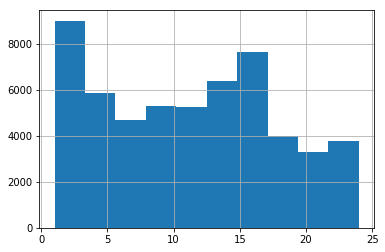

In [92]:
gr_first, df_corrected = fix_MonthOnPosition(empl_history_fixed, border=12)
empl_history_fixed = updateMonthOnPosition(empl_history_fixed, df_corrected)
empl_history_fixed.Correct_MonthOnPosition.hist()

In [93]:
empl_history_fixed[empl_history_fixed['EmployeeID']=='E2B3EA83-3E66-4534-84AF-2E5EC348AE2A']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition
51844  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-01-01            1    105          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              145            145                  0                  -1              3  0.016986             0  0.0              0 2002-01-01           NaT      0          0                       12
51845  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-02-01            1    105          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              146            146                  0                  -1              3  0.017027             0  0.0              0 2002-01-01           NaT      0          0                       13
51846  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-03-01            1    105          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              147            147                  0                  -1              3  0.017076             0  0.0              0 2002-01-01           NaT      0          0                       14
51847  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-04-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              148              1                  0                  -1              3  0.039655             0  0.0              0 2002-01-01           NaT      0          0                       15
51848  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-05-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              149              2                  0                  -1             21  0.039954             0  0.0              0 2002-01-01           NaT      0          0                       16
51849  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-06-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              150              3                  0                  -1             21  0.040371             0  0.0              0 2002-01-01           NaT      0          0                       17
51850  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-07-01            1    359          22          0               13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  6439EE1D-2F87-4F49-A39B-47A13A1C72AE                  1          0.0             0             0                  0                  0       0              151              4                  0                  -1             21  0.040628             0  0.0              0 2002-01-01           NaT      0          0                       18
51851  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A 2018-08-01            1    35

EmployeeID  First
4198  EA2DE374-BEEC-4295-BB88-251A9C3F3446    145
1045  3C88FD47-7728-40D2-9098-354F5215E016    145
2634  9357B776-91AE-4727-BDC7-5B5FB25BC13C    145
1882  693EED64-BCDE-4271-AA09-1C6B30594EC0    145
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
2432  88034931-97E7-4166-8753-1040D9069F28    145
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0    144
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77    140
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0    138
16    00DDA8FB-5640-4311-B84C-B81719C24483    129
4291  EDFC4E8B-1CBC-40E1-8828-3E81BC6BA37E    123
4050  E2C0A896-4AE0-4287-BE81-91B8D355F0D8    114
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    114
3456  C19EB48B-E9D4-4C92-8321-1FE3FABA8D78    111
3782  D437958C-757D-45B0-B490-B00D04C38AE3    111
3719  D0A184D9-5467-41CD-8E08-A1DC324351DE    111
2299  807E5C69-D155-4FC8-9853-109815547B5C    111
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    110
394   17D52F4C-9005-4A1E-B6B7-7A0E0478D6D9    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
1259  47AF5A4D-C1A0-4EB6-8B22-017CEB469E67    108
3862  D879644C-87D3-4B44-B18D-DD991233E54F    107
3934  DD14BBCB-0246-460A-B007-FD24967039B8    107
2033  714EAB94-077C-4583-AFC2-B9635C66060C    106
1689  5FEF8BAE-0234-4E07-B397-78E348578CAC    105
1268  4827FB21-0938-4EFD-A16E-8AB31861BD32    105
2923  A2B66702-D158-4A10-980A-6390E8DF3703    105
1355  4C55FFFA-0216-41BA-896D-26F15108AFCA    105
4189  E9D183DF-C157-4D92-907E-987A369066E8    105
1072  3DE8BCDD-C345-43A1-A5D0-7D21FED3789E    105
2769  9A68FE61-A0C1-4CA4-9E02-73BE987B68BA    104
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    104
4071  E35AD257-2C78-4606-9881-2D8C08513283    104
75    043DE661-7639-4DA3-8374-BCFB84953099    104
1805  6556515F-573B-4211-B29F-08B9BA252638    104
950   37C2BD64-FE96-48E4-988D-9459423DE95F    103
3691  CF01E3A8-1264-4D43-9CE7-2C9F6F64A2B6    103
3495  C390AF86-EC94-4F04-91BB-A7B85A2BA490    103
4515  FA9F7256-FD28-47CB-9382-8CB3A34DDB55    102
1645  5D8D775B-1132-4534-BCC9-DADD0AA98291    100
4287  EDF55694-E086-49DA-93FE-840854CC165B    100
2413  86E7F234-9488-4738-A931-1029CE77DC6C     99
1180  43C1D168-3C26-47A1-A162-5394CE4BD119     99
3464  C1F247BF-ED35-4EBA-9393-C9934DD805E0     99
3002  A7F3F133-8C43-4FC9-ADC6-97CDC9F277E4     98
3905  DB38D981-AD24-44A0-82AC-234BD171B2A8     98
378   16F475A9-219D-4335-94D6-8B5926FD0596     94
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     92
3478  C2BE6B35-24DB-4882-AB9C-A96363DA3052     92
2778  9B29C028-C3AF-473E-A6C5-AA3476F103C4     92
2901  A1AA62AB-5549-4CEC-BDA0-B51F84C2ACFD     91
1757  62FF5704-0B8A-4184-AFEE-06F7E26E1125     91
3748  D2A77884-CBCB-42DB-9454-DFEF25F31406     91
2367  841ED2A5-043D-400F-B0B7-BC90CBCCE2DF     91
4212  EB2784C2-2E50-48D9-BACC-1B7DF433A73C     90
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     90
143   089A5295-058B-44F0-B018-425A27B862E3     90
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     90
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     90
782   2D62A030-125B-48D1-90A1-3B9B908652E2     90
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     90
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     90
911   350B6C8D-E344-4D18-8279-08EF1879F750     90
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     90
59    037AD2D1-2682-41D4-82B8-9190420AE108     89
812   2FAA0EFF-87B6-4A4D-B9A3-AD3A82A43795     89
766   2C43CED9-683D-480F-BE52-3492E054E762     89
3710  D013DAF0-DC1F-45D1-8642-90931CFCD664     89
3679  CEB314D2-12C6-41B8-9D88-60A0DBF82B7A     89
3513  C4D51B85-D010-410D-A290-C18DD6D6CF6B     89
1262  47C97537-AFCF-4379-A04F-045EECCB0619     89
3259  B5412CAC-B3AD-4E9B-A945-53E45537E713     89
2917  A2523DBC-0490-4AD7-A2EB-2026192E4B07     89
1554  57ABEB68-781F-41FD-8431-4D69BE913EB6     89
1560  5826AAD2-8C8E-4348-8C56-1CFA4325CF62     89
581   227B67A7-3EE0-4344-8627-405BFDBDD00D     89
3211  B2852E2C-6CD0-4234-A20B-164CED9B45CF     89
2693  96344EE7-CD8A-4B7A-9A89-D42C20F6DA52     89
2548  8E96EA6A-BC9D-4090-89C0-71D940B1D8B0     89
4541  FBE12B00-0AAE-429B-8423-06

There are Employees -- 1012 with more than 24 months on Position


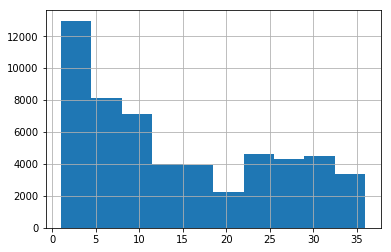

In [94]:
gr_first, df_corrected_24 = fix_MonthOnPosition(empl_history_fixed, border=24)
empl_history_fixed_24 = updateMonthOnPosition(empl_history_fixed, df_corrected_24)
empl_history_fixed_24.Correct_MonthOnPosition.hist()

EmployeeID  First
4198  EA2DE374-BEEC-4295-BB88-251A9C3F3446    145
1045  3C88FD47-7728-40D2-9098-354F5215E016    145
2634  9357B776-91AE-4727-BDC7-5B5FB25BC13C    145
1882  693EED64-BCDE-4271-AA09-1C6B30594EC0    145
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
2432  88034931-97E7-4166-8753-1040D9069F28    145
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0    144
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77    140
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0    138
16    00DDA8FB-5640-4311-B84C-B81719C24483    129
4291  EDFC4E8B-1CBC-40E1-8828-3E81BC6BA37E    123
4050  E2C0A896-4AE0-4287-BE81-91B8D355F0D8    114
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    114
3456  C19EB48B-E9D4-4C92-8321-1FE3FABA8D78    111
3782  D437958C-757D-45B0-B490-B00D04C38AE3    111
3719  D0A184D9-5467-41CD-8E08-A1DC324351DE    111
2299  807E5C69-D155-4FC8-9853-109815547B5C    111
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    110
394   17D52F4C-9005-4A1E-B6B7-7A0E0478D6D9    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
1259  47AF5A4D-C1A0-4EB6-8B22-017CEB469E67    108
3862  D879644C-87D3-4B44-B18D-DD991233E54F    107
3934  DD14BBCB-0246-460A-B007-FD24967039B8    107
2033  714EAB94-077C-4583-AFC2-B9635C66060C    106
1689  5FEF8BAE-0234-4E07-B397-78E348578CAC    105
1268  4827FB21-0938-4EFD-A16E-8AB31861BD32    105
2923  A2B66702-D158-4A10-980A-6390E8DF3703    105
1355  4C55FFFA-0216-41BA-896D-26F15108AFCA    105
4189  E9D183DF-C157-4D92-907E-987A369066E8    105
1072  3DE8BCDD-C345-43A1-A5D0-7D21FED3789E    105
2769  9A68FE61-A0C1-4CA4-9E02-73BE987B68BA    104
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    104
4071  E35AD257-2C78-4606-9881-2D8C08513283    104
75    043DE661-7639-4DA3-8374-BCFB84953099    104
1805  6556515F-573B-4211-B29F-08B9BA252638    104
950   37C2BD64-FE96-48E4-988D-9459423DE95F    103
3691  CF01E3A8-1264-4D43-9CE7-2C9F6F64A2B6    103
3495  C390AF86-EC94-4F04-91BB-A7B85A2BA490    103
4515  FA9F7256-FD28-47CB-9382-8CB3A34DDB55    102
1645  5D8D775B-1132-4534-BCC9-DADD0AA98291    100
4287  EDF55694-E086-49DA-93FE-840854CC165B    100
2413  86E7F234-9488-4738-A931-1029CE77DC6C     99
1180  43C1D168-3C26-47A1-A162-5394CE4BD119     99
3464  C1F247BF-ED35-4EBA-9393-C9934DD805E0     99
3002  A7F3F133-8C43-4FC9-ADC6-97CDC9F277E4     98
3905  DB38D981-AD24-44A0-82AC-234BD171B2A8     98
378   16F475A9-219D-4335-94D6-8B5926FD0596     94
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     92
3478  C2BE6B35-24DB-4882-AB9C-A96363DA3052     92
2778  9B29C028-C3AF-473E-A6C5-AA3476F103C4     92
2901  A1AA62AB-5549-4CEC-BDA0-B51F84C2ACFD     91
1757  62FF5704-0B8A-4184-AFEE-06F7E26E1125     91
3748  D2A77884-CBCB-42DB-9454-DFEF25F31406     91
2367  841ED2A5-043D-400F-B0B7-BC90CBCCE2DF     91
4212  EB2784C2-2E50-48D9-BACC-1B7DF433A73C     90
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     90
143   089A5295-058B-44F0-B018-425A27B862E3     90
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     90
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     90
782   2D62A030-125B-48D1-90A1-3B9B908652E2     90
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     90
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     90
911   350B6C8D-E344-4D18-8279-08EF1879F750     90
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     90
59    037AD2D1-2682-41D4-82B8-9190420AE108     89
812   2FAA0EFF-87B6-4A4D-B9A3-AD3A82A43795     89
766   2C43CED9-683D-480F-BE52-3492E054E762     89
3710  D013DAF0-DC1F-45D1-8642-90931CFCD664     89
3679  CEB314D2-12C6-41B8-9D88-60A0DBF82B7A     89
3513  C4D51B85-D010-410D-A290-C18DD6D6CF6B     89
1262  47C97537-AFCF-4379-A04F-045EECCB0619     89
3259  B5412CAC-B3AD-4E9B-A945-53E45537E713     89
2917  A2523DBC-0490-4AD7-A2EB-2026192E4B07     89
1554  57ABEB68-781F-41FD-8431-4D69BE913EB6     89
1560  5826AAD2-8C8E-4348-8C56-1CFA4325CF62     89
581   227B67A7-3EE0-4344-8627-405BFDBDD00D     89
3211  B2852E2C-6CD0-4234-A20B-164CED9B45CF     89
2693  96344EE7-CD8A-4B7A-9A89-D42C20F6DA52     89
2548  8E96EA6A-BC9D-4090-89C0-71D940B1D8B0     89
4541  FBE12B00-0AAE-429B-8423-06

There are Employees -- 600 with more than 36 months on Position


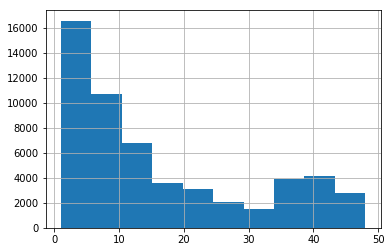

In [95]:
gr_first, df_corrected_36 = fix_MonthOnPosition(empl_history_fixed, border=36)
empl_history_fixed_36 = updateMonthOnPosition(empl_history_fixed, df_corrected_36)
empl_history_fixed_36.Correct_MonthOnPosition.hist()

In [96]:
gr_sum = empl_history_fixed_36.groupby('EmployeeID')['Correct_MonthOnPosition'].sum().reset_index(name='total')
gr_sum.query('total<=6')

EmployeeID  total
2536  8DD80DF3-98A8-47A4-BA05-6C15E3090955      6

In [97]:
empl_history_fixed_36[empl_history_fixed_36['EmployeeID']=='8DD80DF3-98A8-47A4-BA05-6C15E3090955']#'3406D90B-F774-4E3A-81EB-C28C5E6D21CE']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition
32485  8DD80DF3-98A8-47A4-BA05-6C15E3090955 2018-08-01            8    284           4          0               18  2CC21D8F-12E9-467A-A693-C8CE0E7AE4F6  66879EC0-3D75-4CC5-9CF3-1C736820761F                  0        0.875             0             0                  0                  0       0                1              1                 36                  -1             22  1.220694             0 -84.0              3 2018-08-01           NaT      1          0                        1
32486  8DD80DF3-98A8-47A4-BA05-6C15E3090955 2018-09-01            8    284           4          0               18  2CC21D8F-12E9-467A-A693-C8CE0E7AE4F6  9005C8A2-F846-4E78-B5DE-83713907BA47                  0        1.000             0            32                  0                  0       0                1              2                 36                   0             22  1.220694             0  42.0              3 2018-08-01           NaT      0          0                        1
32487  8DD80DF3-98A8-47A4-BA05-6C15E3090955 2018-10-01            8    284           4          0               18  2CC21D8F-12E9-467A-A693-C8CE0E7AE4F6  9005C8A2-F846-4E78-B5DE-83713907BA47                  0        1.000             0             0                  0                  0       0                1              3                 36                   0             22  1.220694             0  44.0              3 2018-08-01           NaT      0          0                        1
32488  8DD80DF3-98A8-47A4-BA05-6C15E3090955 2018-11-01            8    284           4          0               18  2CC21D8F-12E9-467A-A693-C8CE0E7AE4F6  9005C8A2-F846-4E78-B5DE-83713907BA47                  0        1.000             0             0                  0                  0       0                1              4                 36                   0             22  1.220694             0  44.0              3 2018-08-01           NaT      0          0                        1
32489  8DD80DF3-98A8-47A4-BA05-6C15E3090955 2018-12-01            8    284           4          0               18  2CC21D8F-12E9-467A-A693-C8CE0E7AE4F6  6FEC912D-5DC2-4C05-896C-938A453ADD6C                  0        1.000             0             0                  0                  0       0                1              5                 36                   0             22  1.220694             0  44.0              3 2018-08-01           NaT      0          0                        1
32490  8DD80DF3-98A8-47A4-BA05-6C15E3090955 2019-01-01            8    255           4          0               18  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  CFEF9674-13E7-4698-B6DE-690DA3ECD797                  1        0.000             0             0                168                  0       0                1              6                 36                   0             22  1.220694             0   0.0              3 2018-08-01           NaT      0          0                        1

EmployeeID  First
4198  EA2DE374-BEEC-4295-BB88-251A9C3F3446    145
1045  3C88FD47-7728-40D2-9098-354F5215E016    145
2634  9357B776-91AE-4727-BDC7-5B5FB25BC13C    145
1882  693EED64-BCDE-4271-AA09-1C6B30594EC0    145
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
2432  88034931-97E7-4166-8753-1040D9069F28    145
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0    144
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77    140
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0    138
16    00DDA8FB-5640-4311-B84C-B81719C24483    129
4291  EDFC4E8B-1CBC-40E1-8828-3E81BC6BA37E    123
4050  E2C0A896-4AE0-4287-BE81-91B8D355F0D8    114
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    114
3456  C19EB48B-E9D4-4C92-8321-1FE3FABA8D78    111
3782  D437958C-757D-45B0-B490-B00D04C38AE3    111
3719  D0A184D9-5467-41CD-8E08-A1DC324351DE    111
2299  807E5C69-D155-4FC8-9853-109815547B5C    111
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    110
394   17D52F4C-9005-4A1E-B6B7-7A0E0478D6D9    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
1259  47AF5A4D-C1A0-4EB6-8B22-017CEB469E67    108
3862  D879644C-87D3-4B44-B18D-DD991233E54F    107
3934  DD14BBCB-0246-460A-B007-FD24967039B8    107
2033  714EAB94-077C-4583-AFC2-B9635C66060C    106
1689  5FEF8BAE-0234-4E07-B397-78E348578CAC    105
1268  4827FB21-0938-4EFD-A16E-8AB31861BD32    105
2923  A2B66702-D158-4A10-980A-6390E8DF3703    105
1355  4C55FFFA-0216-41BA-896D-26F15108AFCA    105
4189  E9D183DF-C157-4D92-907E-987A369066E8    105
1072  3DE8BCDD-C345-43A1-A5D0-7D21FED3789E    105
2769  9A68FE61-A0C1-4CA4-9E02-73BE987B68BA    104
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    104
4071  E35AD257-2C78-4606-9881-2D8C08513283    104
75    043DE661-7639-4DA3-8374-BCFB84953099    104
1805  6556515F-573B-4211-B29F-08B9BA252638    104
950   37C2BD64-FE96-48E4-988D-9459423DE95F    103
3691  CF01E3A8-1264-4D43-9CE7-2C9F6F64A2B6    103
3495  C390AF86-EC94-4F04-91BB-A7B85A2BA490    103
4515  FA9F7256-FD28-47CB-9382-8CB3A34DDB55    102
1645  5D8D775B-1132-4534-BCC9-DADD0AA98291    100
4287  EDF55694-E086-49DA-93FE-840854CC165B    100
2413  86E7F234-9488-4738-A931-1029CE77DC6C     99
1180  43C1D168-3C26-47A1-A162-5394CE4BD119     99
3464  C1F247BF-ED35-4EBA-9393-C9934DD805E0     99
3002  A7F3F133-8C43-4FC9-ADC6-97CDC9F277E4     98
3905  DB38D981-AD24-44A0-82AC-234BD171B2A8     98
378   16F475A9-219D-4335-94D6-8B5926FD0596     94
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     92
3478  C2BE6B35-24DB-4882-AB9C-A96363DA3052     92
2778  9B29C028-C3AF-473E-A6C5-AA3476F103C4     92
2901  A1AA62AB-5549-4CEC-BDA0-B51F84C2ACFD     91
1757  62FF5704-0B8A-4184-AFEE-06F7E26E1125     91
3748  D2A77884-CBCB-42DB-9454-DFEF25F31406     91
2367  841ED2A5-043D-400F-B0B7-BC90CBCCE2DF     91
4212  EB2784C2-2E50-48D9-BACC-1B7DF433A73C     90
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     90
143   089A5295-058B-44F0-B018-425A27B862E3     90
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     90
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     90
782   2D62A030-125B-48D1-90A1-3B9B908652E2     90
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     90
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     90
911   350B6C8D-E344-4D18-8279-08EF1879F750     90
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     90
59    037AD2D1-2682-41D4-82B8-9190420AE108     89
812   2FAA0EFF-87B6-4A4D-B9A3-AD3A82A43795     89
766   2C43CED9-683D-480F-BE52-3492E054E762     89
3710  D013DAF0-DC1F-45D1-8642-90931CFCD664     89
3679  CEB314D2-12C6-41B8-9D88-60A0DBF82B7A     89
3513  C4D51B85-D010-410D-A290-C18DD6D6CF6B     89
1262  47C97537-AFCF-4379-A04F-045EECCB0619     89
3259  B5412CAC-B3AD-4E9B-A945-53E45537E713     89
2917  A2523DBC-0490-4AD7-A2EB-2026192E4B07     89
1554  57ABEB68-781F-41FD-8431-4D69BE913EB6     89
1560  5826AAD2-8C8E-4348-8C56-1CFA4325CF62     89
581   227B67A7-3EE0-4344-8627-405BFDBDD00D     89
3211  B2852E2C-6CD0-4234-A20B-164CED9B45CF     89
2693  96344EE7-CD8A-4B7A-9A89-D42C20F6DA52     89
2548  8E96EA6A-BC9D-4090-89C0-71D940B1D8B0     89
4541  FBE12B00-0AAE-429B-8423-06

There are Employees -- 326 with more than 48 months on Position


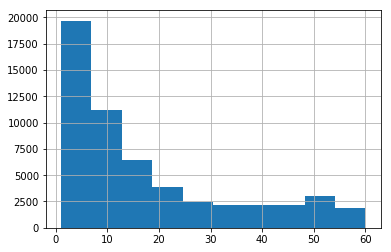

In [98]:
gr_first, df_corrected_48 = fix_MonthOnPosition(empl_history_fixed, border=48)
empl_history_fixed_48 = updateMonthOnPosition(empl_history_fixed, df_corrected_48)
empl_history_fixed_48.Correct_MonthOnPosition.hist()

## 2.2. MonthOnSalary 
<a id="monthOnSalary_filtering"></a>

In [99]:
def recalculateMonthOnSalary(group, started_from, delta=0.03):
    group['Correct_MonthOnSalary'] = group.groupby((group['Wage'] != 
                                              (group['Wage']+(group['Wage']*delta)).shift(1)).cumsum()).cumcount()+started_from
    return group

def fix_MonthOnSalary(df, border):
    gr_first = df.groupby('EmployeeID')['MonthOnSalary'].first().reset_index(name='First')
    gr_first = gr_first.sort_values(by=['First'], ascending=False)
    display(gr_first)
    long_history = gr_first[gr_first['First']>border] 
    print('There are Employees -- %s with more than %s months on Salary'% (len(long_history.EmployeeID.unique()),border))
    df_corrected_salary = df[df['EmployeeID'].isin(long_history.EmployeeID.unique())==True]
    df_corrected_salary = df_corrected_salary.groupby(['EmployeeID']).apply(recalculateMonthOnSalary, started_from=border)
    return gr_first, df_corrected_salary
    

def updateMonthOnSalary(empl_history_fixed, df_corrected_salary ):
    # df_corrected_salary - df where is CorerctMonthsOnSalary:
    empl_history_fixed['Correct_MonthOnSalary'] = empl_history_fixed['MonthOnSalary']
    mask = empl_history_fixed[['EmployeeID', 'Date']].isin(df_corrected_salary[['EmployeeID', 'Date']]).all(1)
    empl_history_fixed.Correct_MonthOnSalary = empl_history_fixed.Correct_MonthOnSalary.mask(mask).combine_first(df_corrected_salary.Correct_MonthOnSalary).astype(int)
    return empl_history_fixed

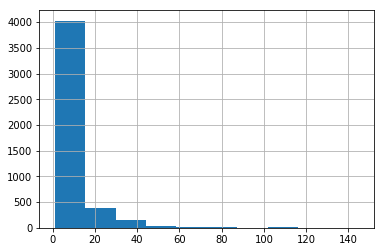

In [100]:
gr_first = empl_history_fixed_36.groupby('EmployeeID')['MonthOnSalary'].first().reset_index(name='First')
#gr_first.First.value_counts().sort_index()
gr_first.First.hist()

In [101]:
result = empl_history_fixed_36.copy()

EmployeeID  First
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
911   350B6C8D-E344-4D18-8279-08EF1879F750    130
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    118
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    109
4189  E9D183DF-C157-4D92-907E-987A369066E8    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    108
950   37C2BD64-FE96-48E4-988D-9459423DE95F    107
1180  43C1D168-3C26-47A1-A162-5394CE4BD119    103
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     93
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     85
1102  3F28A626-AA0F-4591-9D3A-42AD5643BF92     85
4081  E3ED7385-7005-4F80-89A0-A9BBBDA6B541     84
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     84
665   272629BB-8BCA-4072-9029-8BD650E34BCF     83
3369  BC31B3E1-DEB6-4026-91DF-9E057D84769C     82
585   22A05D81-602C-4016-ADB6-C39EDAC4247B     78
1039  3BF8F71E-67BD-40F4-9A2D-D312368625A9     77
683   284B3B59-149B-4116-93B0-7F6BEFF65F8B     77
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0     73
1754  62F4FF8F-E0B3-422A-AC0E-5FB4FD8B34F8     71
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     69
4231  EBCED7BC-E957-4EAB-9007-74174487DAF2     67
3435  BFFD0CD3-1301-493E-907B-44493199ECE3     65
3055  AA23CEFA-E23D-4DB0-AE7A-29590F976EF3     63
4240  EC4352A9-F3AE-40FC-ACFA-0A3997AD2F28     61
832   308C84FE-422D-44EB-A81B-4E4AEA9CE4B5     61
4287  EDF55694-E086-49DA-93FE-840854CC165B     61
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     61
143   089A5295-058B-44F0-B018-425A27B862E3     61
1767  639E1757-FFAE-47FF-BC95-6895B6FB0493     61
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     61
2841  9E6EF5C2-49CE-4082-8A90-6F00BA7AD813     61
1878  69100EDD-D1A7-47AC-8B8F-F6047121C229     61
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77     61
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     61
2351  8309E5D6-7DA0-4B44-895A-7F114AF5F526     60
1572  58A0CCBB-8847-425F-B45E-1FE7A0EB630B     58
29    01592627-19B1-4EE3-8BE3-9516C04A29BD     58
1903  6AA5479D-9B7C-4824-8113-C9C6A39AF314     57
278   110E0AAA-E603-43B8-ACF0-3AECD4980027     57
681   283A510F-351F-42A1-8151-D720172CB7EE     57
2673  9516546F-C784-46C3-9421-71E204D0AC9B     55
3521  C551A5F0-115E-4DC5-AA06-B05524E2429C     54
1763  635165BD-15FA-4480-B595-7F4AA8A9C576     53
3826  D6ABED6F-45CD-4533-AF46-7AE390C3109A     53
3745  D28CE242-428D-4659-BE23-82B6A4A1F752     52
1869  689A8F33-5B2C-4029-A317-52AF30BC0461     52
4590  FE3743D4-8AF0-43D3-879A-ECDF18A54FD6     51
4425  F59D13C9-E8B7-4AAF-B2CE-FD27B8C595B6     51
3378  BCAF2DD1-FEE5-4A49-A635-38E3555EE288     51
1649  5DCF70D5-EFEB-4E5D-B6DC-78D43495A318     50
2244  7D9935C2-C6F4-47E9-BB61-B860E79A6334     50
3332  B9D20E88-26E5-4F60-B7E4-EC98A44A545E     50
3996  DFF93F79-723B-44AE-BCCC-85E18DCCCF79     48
4145  E7B42685-4588-4E66-8582-044BC4848D42     48
1541  56CC24D8-E231-41EA-9FDC-749F285B95A9     47
2622  92C30ABA-4F08-42FB-8EBB-D80FA1534D8A     47
1426  4F8332CE-9F1E-43BC-891E-E54F3974CF1A     46
1402  4EDACE38-2BA8-4A75-B540-F6BD737F7458     46
3913  DB7ECFA7-4ACC-46CC-A5BB-B9BBF2E332AB     46
2020  70826B75-76D0-46F6-8E75-8110E3D215D1     45
3373  BC79C9B7-4CE3-42A9-9144-B02D038B84D7     45
3045  A9B35163-727B-4C0B-9E93-78A870A51004     45
4394  F3C53AFE-2558-4C62-8F2D-E7BDC77BCD19     45
3915  DB9A9B3E-F659-4D71-A6F5-431EFE3139BB     45
2336  8215B111-4676-4105-A4E9-53E0F2BFB745     45
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0     45
2259  7E547338-33B8-4C1A-9B5C-AC33476AE546     44
2255  7DEF6B17-C6EC-47E0-B64E-9978B7CF3FE6     44
1009  3A858FE8-87D8-4FD3-8CFD-C6C1F5DC4675     44
4143  E767C4CE-9C4D-4D4C-984B-7D9164D4A31E     43
434   199554E9-C609-49A7-86E1-2EAD28969D5F     43
40    01DDE66C-877E-47FE-A9B0-75570D9FF3DF     43
2496  8B66A1DA-4DE6-4A96-A0AB-05011EAB1B08     42
147   08F89590-567D-4B59-9C28-DEA59533F7E3     42
1526  55F6BE2E-F329-4D73-9CE3-2A970258A09B     42
4616  FF709A7E-C93D-4F7A-BF43-AAB1DFA160DD     42
4315  EFAED002-84AA-474B-B6F4-6320FC0A4499     42
567   21A257DE-4C0F-4F11-B711-33

There are Employees -- 795 with more than 12 months on Salary


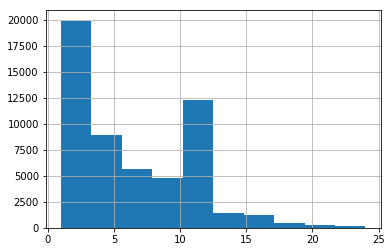

In [102]:
gr_first_salary, empl_history_sal_12 = fix_MonthOnSalary(result, border=12)

result_12 = updateMonthOnSalary(result, empl_history_sal_12)
result_12.Correct_MonthOnSalary.hist()

EmployeeID  First
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
911   350B6C8D-E344-4D18-8279-08EF1879F750    130
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    118
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    109
4189  E9D183DF-C157-4D92-907E-987A369066E8    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    108
950   37C2BD64-FE96-48E4-988D-9459423DE95F    107
1180  43C1D168-3C26-47A1-A162-5394CE4BD119    103
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     93
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     85
1102  3F28A626-AA0F-4591-9D3A-42AD5643BF92     85
4081  E3ED7385-7005-4F80-89A0-A9BBBDA6B541     84
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     84
665   272629BB-8BCA-4072-9029-8BD650E34BCF     83
3369  BC31B3E1-DEB6-4026-91DF-9E057D84769C     82
585   22A05D81-602C-4016-ADB6-C39EDAC4247B     78
1039  3BF8F71E-67BD-40F4-9A2D-D312368625A9     77
683   284B3B59-149B-4116-93B0-7F6BEFF65F8B     77
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0     73
1754  62F4FF8F-E0B3-422A-AC0E-5FB4FD8B34F8     71
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     69
4231  EBCED7BC-E957-4EAB-9007-74174487DAF2     67
3435  BFFD0CD3-1301-493E-907B-44493199ECE3     65
3055  AA23CEFA-E23D-4DB0-AE7A-29590F976EF3     63
4240  EC4352A9-F3AE-40FC-ACFA-0A3997AD2F28     61
832   308C84FE-422D-44EB-A81B-4E4AEA9CE4B5     61
4287  EDF55694-E086-49DA-93FE-840854CC165B     61
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     61
143   089A5295-058B-44F0-B018-425A27B862E3     61
1767  639E1757-FFAE-47FF-BC95-6895B6FB0493     61
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     61
2841  9E6EF5C2-49CE-4082-8A90-6F00BA7AD813     61
1878  69100EDD-D1A7-47AC-8B8F-F6047121C229     61
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77     61
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     61
2351  8309E5D6-7DA0-4B44-895A-7F114AF5F526     60
1572  58A0CCBB-8847-425F-B45E-1FE7A0EB630B     58
29    01592627-19B1-4EE3-8BE3-9516C04A29BD     58
1903  6AA5479D-9B7C-4824-8113-C9C6A39AF314     57
278   110E0AAA-E603-43B8-ACF0-3AECD4980027     57
681   283A510F-351F-42A1-8151-D720172CB7EE     57
2673  9516546F-C784-46C3-9421-71E204D0AC9B     55
3521  C551A5F0-115E-4DC5-AA06-B05524E2429C     54
1763  635165BD-15FA-4480-B595-7F4AA8A9C576     53
3826  D6ABED6F-45CD-4533-AF46-7AE390C3109A     53
3745  D28CE242-428D-4659-BE23-82B6A4A1F752     52
1869  689A8F33-5B2C-4029-A317-52AF30BC0461     52
4590  FE3743D4-8AF0-43D3-879A-ECDF18A54FD6     51
4425  F59D13C9-E8B7-4AAF-B2CE-FD27B8C595B6     51
3378  BCAF2DD1-FEE5-4A49-A635-38E3555EE288     51
1649  5DCF70D5-EFEB-4E5D-B6DC-78D43495A318     50
2244  7D9935C2-C6F4-47E9-BB61-B860E79A6334     50
3332  B9D20E88-26E5-4F60-B7E4-EC98A44A545E     50
3996  DFF93F79-723B-44AE-BCCC-85E18DCCCF79     48
4145  E7B42685-4588-4E66-8582-044BC4848D42     48
1541  56CC24D8-E231-41EA-9FDC-749F285B95A9     47
2622  92C30ABA-4F08-42FB-8EBB-D80FA1534D8A     47
1426  4F8332CE-9F1E-43BC-891E-E54F3974CF1A     46
1402  4EDACE38-2BA8-4A75-B540-F6BD737F7458     46
3913  DB7ECFA7-4ACC-46CC-A5BB-B9BBF2E332AB     46
2020  70826B75-76D0-46F6-8E75-8110E3D215D1     45
3373  BC79C9B7-4CE3-42A9-9144-B02D038B84D7     45
3045  A9B35163-727B-4C0B-9E93-78A870A51004     45
4394  F3C53AFE-2558-4C62-8F2D-E7BDC77BCD19     45
3915  DB9A9B3E-F659-4D71-A6F5-431EFE3139BB     45
2336  8215B111-4676-4105-A4E9-53E0F2BFB745     45
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0     45
2259  7E547338-33B8-4C1A-9B5C-AC33476AE546     44
2255  7DEF6B17-C6EC-47E0-B64E-9978B7CF3FE6     44
1009  3A858FE8-87D8-4FD3-8CFD-C6C1F5DC4675     44
4143  E767C4CE-9C4D-4D4C-984B-7D9164D4A31E     43
434   199554E9-C609-49A7-86E1-2EAD28969D5F     43
40    01DDE66C-877E-47FE-A9B0-75570D9FF3DF     43
2496  8B66A1DA-4DE6-4A96-A0AB-05011EAB1B08     42
147   08F89590-567D-4B59-9C28-DEA59533F7E3     42
1526  55F6BE2E-F329-4D73-9CE3-2A970258A09B     42
4616  FF709A7E-C93D-4F7A-BF43-AAB1DFA160DD     42
4315  EFAED002-84AA-474B-B6F4-6320FC0A4499     42
567   21A257DE-4C0F-4F11-B711-33

There are Employees -- 271 with more than 24 months on Salary


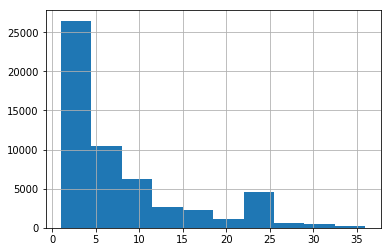

In [103]:
gr_first_salary, empl_history_sal_24 = fix_MonthOnSalary(result, border=24)

result_24 = updateMonthOnSalary(result, empl_history_sal_24)
result_24.Correct_MonthOnSalary.hist()

EmployeeID  First
4049  E2B3EA83-3E66-4534-84AF-2E5EC348AE2A    145
911   350B6C8D-E344-4D18-8279-08EF1879F750    130
4308  EF4A6B91-0DE3-49B8-BF2E-AA84D4234C3D    118
2823  9D6DFC1B-5F2F-407A-8933-4D6107FAB4C6    109
4189  E9D183DF-C157-4D92-907E-987A369066E8    109
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E    108
4500  F9A66A16-A214-4D76-8263-42A8B8D0BE61    108
950   37C2BD64-FE96-48E4-988D-9459423DE95F    107
1180  43C1D168-3C26-47A1-A162-5394CE4BD119    103
356   16070401-18A1-4EAA-A9ED-E3EB84700AEB     93
1810  65CAAC65-8E9A-4DF0-A649-E06EFA820785     85
1102  3F28A626-AA0F-4591-9D3A-42AD5643BF92     85
4081  E3ED7385-7005-4F80-89A0-A9BBBDA6B541     84
2847  9EC62675-999C-4A3B-ADDB-052FD4F52C7F     84
665   272629BB-8BCA-4072-9029-8BD650E34BCF     83
3369  BC31B3E1-DEB6-4026-91DF-9E057D84769C     82
585   22A05D81-602C-4016-ADB6-C39EDAC4247B     78
1039  3BF8F71E-67BD-40F4-9A2D-D312368625A9     77
683   284B3B59-149B-4116-93B0-7F6BEFF65F8B     77
539   202556A1-4F74-4C27-A3AC-E5558D7DEDF0     73
1754  62F4FF8F-E0B3-422A-AC0E-5FB4FD8B34F8     71
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711     69
4231  EBCED7BC-E957-4EAB-9007-74174487DAF2     67
3435  BFFD0CD3-1301-493E-907B-44493199ECE3     65
3055  AA23CEFA-E23D-4DB0-AE7A-29590F976EF3     63
4240  EC4352A9-F3AE-40FC-ACFA-0A3997AD2F28     61
832   308C84FE-422D-44EB-A81B-4E4AEA9CE4B5     61
4287  EDF55694-E086-49DA-93FE-840854CC165B     61
389   17A42BB7-347F-4CA8-9AF1-BEFA18FA28F4     61
143   089A5295-058B-44F0-B018-425A27B862E3     61
1767  639E1757-FFAE-47FF-BC95-6895B6FB0493     61
1162  42E03ADE-02E0-4754-84E3-06C664EF6EE0     61
2841  9E6EF5C2-49CE-4082-8A90-6F00BA7AD813     61
1878  69100EDD-D1A7-47AC-8B8F-F6047121C229     61
2110  750BB6E9-E412-4AAB-AEBA-8E08C591FC77     61
2073  7340E932-2A74-4185-9DA0-F75583B6E8C0     61
2351  8309E5D6-7DA0-4B44-895A-7F114AF5F526     60
1572  58A0CCBB-8847-425F-B45E-1FE7A0EB630B     58
29    01592627-19B1-4EE3-8BE3-9516C04A29BD     58
1903  6AA5479D-9B7C-4824-8113-C9C6A39AF314     57
278   110E0AAA-E603-43B8-ACF0-3AECD4980027     57
681   283A510F-351F-42A1-8151-D720172CB7EE     57
2673  9516546F-C784-46C3-9421-71E204D0AC9B     55
3521  C551A5F0-115E-4DC5-AA06-B05524E2429C     54
1763  635165BD-15FA-4480-B595-7F4AA8A9C576     53
3826  D6ABED6F-45CD-4533-AF46-7AE390C3109A     53
3745  D28CE242-428D-4659-BE23-82B6A4A1F752     52
1869  689A8F33-5B2C-4029-A317-52AF30BC0461     52
4590  FE3743D4-8AF0-43D3-879A-ECDF18A54FD6     51
4425  F59D13C9-E8B7-4AAF-B2CE-FD27B8C595B6     51
3378  BCAF2DD1-FEE5-4A49-A635-38E3555EE288     51
1649  5DCF70D5-EFEB-4E5D-B6DC-78D43495A318     50
2244  7D9935C2-C6F4-47E9-BB61-B860E79A6334     50
3332  B9D20E88-26E5-4F60-B7E4-EC98A44A545E     50
3996  DFF93F79-723B-44AE-BCCC-85E18DCCCF79     48
4145  E7B42685-4588-4E66-8582-044BC4848D42     48
1541  56CC24D8-E231-41EA-9FDC-749F285B95A9     47
2622  92C30ABA-4F08-42FB-8EBB-D80FA1534D8A     47
1426  4F8332CE-9F1E-43BC-891E-E54F3974CF1A     46
1402  4EDACE38-2BA8-4A75-B540-F6BD737F7458     46
3913  DB7ECFA7-4ACC-46CC-A5BB-B9BBF2E332AB     46
2020  70826B75-76D0-46F6-8E75-8110E3D215D1     45
3373  BC79C9B7-4CE3-42A9-9144-B02D038B84D7     45
3045  A9B35163-727B-4C0B-9E93-78A870A51004     45
4394  F3C53AFE-2558-4C62-8F2D-E7BDC77BCD19     45
3915  DB9A9B3E-F659-4D71-A6F5-431EFE3139BB     45
2336  8215B111-4676-4105-A4E9-53E0F2BFB745     45
2489  8AD786AD-8634-47E7-AC9A-858D4C86CCE0     45
2259  7E547338-33B8-4C1A-9B5C-AC33476AE546     44
2255  7DEF6B17-C6EC-47E0-B64E-9978B7CF3FE6     44
1009  3A858FE8-87D8-4FD3-8CFD-C6C1F5DC4675     44
4143  E767C4CE-9C4D-4D4C-984B-7D9164D4A31E     43
434   199554E9-C609-49A7-86E1-2EAD28969D5F     43
40    01DDE66C-877E-47FE-A9B0-75570D9FF3DF     43
2496  8B66A1DA-4DE6-4A96-A0AB-05011EAB1B08     42
147   08F89590-567D-4B59-9C28-DEA59533F7E3     42
1526  55F6BE2E-F329-4D73-9CE3-2A970258A09B     42
4616  FF709A7E-C93D-4F7A-BF43-AAB1DFA160DD     42
4315  EFAED002-84AA-474B-B6F4-6320FC0A4499     42
567   21A257DE-4C0F-4F11-B711-33

There are Employees -- 112 with more than 36 months on Salary


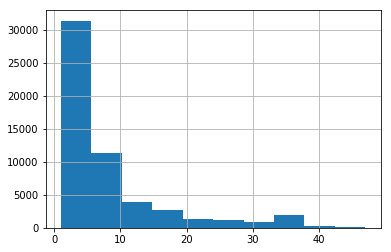

In [104]:
gr_first_salary, empl_history_sal_36 = fix_MonthOnSalary(result, border=36)

result_36 = updateMonthOnSalary(result, empl_history_sal_36)
result_36.Correct_MonthOnSalary.hist()

In [105]:
result_36.Correct_MonthOnSalary.value_counts().sort_index()

1     8323
2     7175
3     6200
4     5224
5     4452
6     3591
7     2634
8     2126
9     1772
10    1276
11    1135
12    1052
13     915
14     750
15     664
16     593
17     522
18     464
19     430
20     380
21     331
22     294
23     325
24     284
25     260
26     238
27     215
28     203
29     191
30     186
31     186
32     164
33     160
34     191
35     111
36    1528
37      96
38      92
39      76
40      65
41      60
42      55
43      49
44      46
45      41
46      32
47       3
Name: Correct_MonthOnSalary, dtype: int64

In [106]:
result_36[result_36['EmployeeID']=='87245113-AC08-4578-9B36-361EA6208AF9']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary
31051  87245113-AC08-4578-9B36-361EA6208AF9 2018-08-01            1    295          12          1                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                1              1                 17                   1             21  0.122727             0  0.0              0 2018-08-01           NaT      1          0                        1                      1
31052  87245113-AC08-4578-9B36-361EA6208AF9 2018-09-01            1    295          12          1                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                2              2                 17                   1             21  0.122727             0  0.0              0 2018-08-01           NaT      0          0                        2                      2
31053  87245113-AC08-4578-9B36-361EA6208AF9 2018-10-01            1    295          12          1                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                3              3                 17                   1             20  0.120095             0  0.0              0 2018-08-01           NaT      0          0                        3                      3
31054  87245113-AC08-4578-9B36-361EA6208AF9 2018-11-01            1    295          12          1                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                4              4                 17                   1             20  0.118450             0  0.0              0 2018-08-01           NaT      0          0                        4                      4
31055  87245113-AC08-4578-9B36-361EA6208AF9 2018-12-01            1    295          12          1                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0            16                  0                  0       0                5              5                 17                   1             22  0.113515             0  0.0              0 2018-08-01           NaT      0          0                        5                      5
31056  87245113-AC08-4578-9B36-361EA6208AF9 2019-01-01            1    498          13          1                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             8             0                  0                  0       0                1              1                 17                   1             22  0.129966             0  0.0              1 2018-08-01           NaT      0          0                        1                      1

In [107]:
result_36[result_36['EmployeeID']=='867D9FFD-D33D-4456-851C-E75E65A1F823']

Empty DataFrame
Columns: [EmployeeID, Date, DevCenterID, SBUID, PositionID, IsTrainee, LanguageLevelID, CustomerID, ProjectID, IsInternalProject, Utilization, HourVacation, HourSickness, HourMobileReserve, HourLockedReserve, OnSite, MonthOnPosition, MonthOnSalary, CompetenceGroupID, FunctionalOfficeID, PaymentTypeId, Wage, BonusOneTime, APM, PositionLevel, HiringDate, DismissalDate, Hired, Dismissed, Correct_MonthOnPosition, Correct_MonthOnSalary]
Index: []

## Total statistics of Employees by different features: Hours, Wage, APM
<a id="total_statistics"></a>

*1. Divide date by Quarter*

In [108]:
empl_history_filt = result_36.copy()

In [109]:
empl_history_filt['Quarter'] = empl_history_filt.Date.dt.quarter

In [110]:
empl_history_filt.head()

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter
3  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01            3    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0       0.9000            16             0                  0                  0       0               31             25                 15                   1              9  0.559347             0  59.0              2 2013-05-01           NaT      0          0                       31                     25        1
4  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01            3    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0       1.0000             0             0                  0                  0       0               32             26                 15                   1              9  0.559347             0  59.0              2 2013-05-01           NaT      0          0                       32                     26        1
5  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-03-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       0.5714             8             0                  0                  0       0               33             27                 15                   1              9  0.559347             0  37.0              2 2013-05-01           NaT      0          0                       33                     27        1
6  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-04-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       1.0000             0             0                  0                  0       0               34             28                 15                   1              9  0.559347             0  54.0              2 2013-05-01           NaT      0          0                       34                     28        2
7  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-05-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       1.0000            32             0                  0                  0       0               35              1                 15                   1             22  0.568231             0  55.0              2 2013-05-01           NaT      0          0                       35                      1        2

*2. Average salary per Quarter:*

In [111]:
ave_salary = empl_history_filt.groupby('Quarter')['Wage'].mean()
ave_salary

Quarter
1    0.656275
2    0.652849
3    0.659193
4    0.688436
Name: Wage, dtype: float64

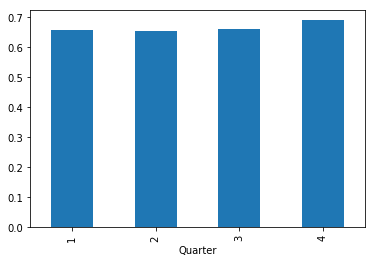

In [112]:
ave_salary.plot(x='Quarter',y='Average_Wage', kind='bar')
plt.show()

*3.Average Bonus values by quarters* 

In [113]:
bonus = empl_history_filt.groupby('Quarter')['BonusOneTime'].mean()
bonus

Quarter
1    179.281347
2     82.427633
3    100.429344
4    101.325520
Name: BonusOneTime, dtype: float64

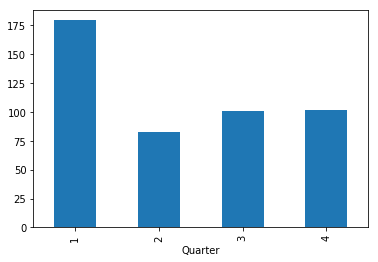

In [114]:
bonus.plot(x='Quarter',y='Average_BonusOneTime', kind='bar')
plt.show()

*4.Summary statistics for Employees* 

In [115]:
grouped_empl_hist = empl_history_filt.groupby(['Quarter', 'EmployeeID'])['HourVacation', 'HourSickness',
                                                                 'HourMobileReserve', 'HourLockedReserve',
                                                                 'MonthOnPosition', 'MonthOnSalary',
                                                                 'Wage',
                                                                 'BonusOneTime', 'APM'].sum().reset_index()

In [116]:
grouped_empl_hist.head()

Quarter                            EmployeeID  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  MonthOnPosition  MonthOnSalary      Wage  BonusOneTime    APM
0        1  00116D71-E87D-4B64-A566-1F29B2A798A8            32             0                  0                  0               97             79  2.369001             0  200.0
1        1  0034ECA4-0562-4AC7-A826-4AE81C64D69F            72            16                  0                  0               15             21  1.670475             0  268.0
2        1  00384806-F711-41BA-A924-8F27E996F891             0             0                  0                  0              107             63  0.873569             0    0.0
3        1  0040B626-4578-4C4B-B3CB-42270CEAFF6C             0             0                312                  0                9              9  0.519206             0    0.0
4        1  005B5FD6-FD19-4924-98E4-4C06F7F6BF2C             0             0                  0                  0                4              6  0.182610             0   72.0

In [117]:
len(grouped_empl_hist.EmployeeID.unique())

4626

## Validation before Create target: 
<a id="validation_before_target"></a>

In [118]:
data = empl_history_filt.copy()

In [119]:
len(data.EmployeeID.unique()), len(employees.EmployeeID.unique())

(4626, 5937)

In [120]:
len(data.EmployeeID.unique())

4626

In [121]:
data.DismissalDate.isnull().value_counts()

True     50974
False     4186
Name: DismissalDate, dtype: int64

In [122]:
data.describe()

DevCenterID         SBUID   PositionID     IsTrainee  LanguageLevelID  IsInternalProject   Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve        OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId          Wage  BonusOneTime            APM  PositionLevel         Hired     Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary       Quarter
count  55160.000000  55160.000000  55160.00000  55160.000000     55160.000000       55160.000000  55160.000000  55160.000000  55160.000000       55160.000000       55160.000000  55160.000000     55160.000000   55160.000000       55160.000000        55160.000000   55160.000000  55160.000000  55160.000000   55160.000000   55160.000000  55160.000000  55160.000000             55160.000000           55160.000000  55160.000000
mean       4.038687    263.650381    202.81579      0.063524        12.339449           0.323078      0.599208      9.794271      2.012110           2.978880           2.239268      0.009101        18.371537       8.146719          16.982687            0.368093      17.230801      0.663722    119.517966       4.747353       2.311766      0.015247      0.008430                17.111675               7.971991      2.417803
std        5.500402    106.841476    293.29609      0.243906         6.488614           0.467657      0.488414     20.487491      7.505589          19.676373          16.363246      0.094964        21.326282      11.058666          11.429972            1.632735       6.576661      0.746356   1003.199605    2258.401934       1.472923      0.122533      0.091428                16.516575               8.947194      1.138717
min        0.000000      6.000000      1.00000      0.000000         0.000000           0.000000      0.000000      0.000000      0.000000           0.000000           0.000000      0.000000         1.000000       1.000000           0.000000           -1.000000       1.000000      0.009706  -1803.000000 -291432.000000       0.000000      0.000000      0.000000                 1.000000               1.000000      1.000000
25%        1.000000    266.000000      4.00000      0.000000         9.000000           0.000000      0.000000      0.000000      0.000000           0.000000           0.000000      0.000000         4.000000       2.000000           0.000000           -1.000000       9.000000      0.239203      0.000000       0.000000       1.000000      0.000000      0.000000                 5.000000               2.000000      1.000000
50%        1.000000    295.000000     70.00000      0.000000        11.000000           0.000000      1.000000      0.000000      0.000000           0.000000           0.000000      0.000000        10.000000       5.000000          20.000000            0.000000      22.000000      0.526445      0.000000      38.000000       2.000000      0.000000      0.000000                10.000000               5.000000      2.000000
75%        5.000000    327.000000    206.00000      0.000000        18.000000           1.000000      1.000000      8.000000      0.000000           0.000000           0.000000      0.000000        24.000000       9.000000          23.000000            1.000000      22.000000      0.864356      0.000000      57.000000       3.000000      0.000000      0.000000                25.000000               9.000000      3.000000
max       36.000000    500.000000   1487.00000      1.000000        26.000000           1.000000      7.000000    240.000000    240.000000         210.000000         207.000000      1.000000       157.000000     147.000000          40.000000            9.000000      22.000000     11.715203  61603.000000     185.000000       9.000000      1.000000      1.000000                60.000000              47.000000      4.000000

In [123]:
data[data['MonthOnPosition']==24]

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime    APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter
36     00384806-F711-41BA-A924-8F27E996F891 2018-02-01            1     55         206          0               18  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F                                   NaN                  1       0.0000             0             0                  0                  0       0               24             18                 17                   1              9  0.216171             0    0.0              1 2015-04-01           NaT      0          0                       24                     18        1
115    00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-11-01            1    330          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0       1.0000             0             0                  0                  0       0               24             17                 31                   2             22  1.082831             0  -27.0              3 2005-03-01           NaT      0          0                       24                     17        4
126    0086EAF5-5A95-4E6B-B5EF-1B22CDF0538E 2018-09-01            8    331         203          0               20  893EA22F-08BE-4F11-AD93-C50746E4565F  44F330C4-C5C9-4073-890B-6F0AD74B4F87                  0       1.0000            40             0                  0                  0       0               24             23                 29                   0             22  0.963065           250   33.0              2 2016-03-01           NaT      0          0                       24                     23        3
291    0111ADE3-853E-4C6C-85F8-498D07DEE3EA 2018-02-01            4    272         202          0               20  FB40AB74-6C54-4B22-A3BB-7A3CE5F2E6C2  3121846A-7B96-4197-8525-54E68574D197                  0       1.0094             0             8                  0                  0       0               24              6                 23                   0              9  0.287899             0   69.0              1 2015-04-01           NaT      0          0                       24                      6        1
333    012ADF75-5DA7-43FF-83AE-BC2CD70B82E0 2018-12-01            2    302           5          0               18  B5C3E32A-9DE4-4E0E-AB93-15772D5A7EA0  6120DFE9-A454-44E6-A007-FABBDD358AB8                  0       1.0000             8             0                  0                  0       0               24              7                 21                   0             22  1.160481             0   41.0              4 2011-10-01           NaT      0          0                       24                      7        4
609    025E58AB-DAFC-4EC0-8BCB-2F42BDE1662E 2018-01-01            1    331           4          0               19  893EA22F-08BE-4F11-AD93-C50746E4565F  2CE530AD-3A84-442A-84FE-09F2BF078BBE                  0       0.9000            16             0                  0                  0       0               24             14                 21                   0              9  0.723861             0   44.0              3 2013-09-01           NaT      0          0                       24                     14        1
729    0343E6D7-BE25-4360-81A0-A339DFB29684 2018-01-01            1     55          15          0               18  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  C3731827-D2BB-41DB-9B2E-EFEF37A092AC                  1       0.0000             0             0                  0                  0       0               24             23  

In [124]:
data[data['MonthOnPosition']==48]

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime     APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter
150    008CD18A-3AFA-446F-A95E-DDAA8E6E3C6F 2018-11-01            1    115         576          0               20  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  38D4BB86-DDBF-4BED-84D0-F8AE1FECB789                  1       0.0000             0             0                  0                  0       0               48              7                  0                  -1             22  0.498477             0     0.0              3 2002-04-01           NaT      0          0                       48                      7        4
355    013EAEAF-733A-4E91-B828-A277FE29A039 2018-08-01            1    309           3          0                9  3CD87AE7-A973-4C6F-8C7B-576C10D5B062  CEDAC672-2A2D-4FF3-981D-2F56CD2B61E7                  0       1.0000            40             8                  0                  0       0               48              4                 19                   0             22  0.617585             0    38.0              2 2013-01-01           NaT      0          0                       48                      4        3
376    01592627-19B1-4EE3-8BE3-9516C04A29BD 2018-03-01            1     27         422          0               10  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  934204E2-DD53-4AAF-8F5B-83910DDDD2F8                  1       0.0000             0             0                  0                  0       0               48             60                  0                  -1              3  0.015234             0     0.0              2 2004-08-01           NaT      0          0                       48                     36        1
441    018E2508-EA16-425A-93CC-AF61FAD752AF 2018-10-01            1    325         372          0               18  BADD4BCB-8BCC-4F44-B1CE-F6DE4282C91E  F75FF693-5AB2-4070-A06D-F82E8A34FF96                  0       1.0000             0            16                  0                  0       0               48              6                 33                   8             22  0.699842             0    55.0              2 2013-08-01           NaT      0          0                       48                      6        4
1076   05121393-82F0-4DF6-AA03-DF05DD5BA24F 2019-01-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1       0.0000             0             0                  0                  0       0               48              1                  0                  -1             21  0.064211             0     0.0              1 2015-01-01           NaT      0          0                       48                      1        1
1434   06A44D2C-DB4B-47CE-A9E4-CA9ACFBADD44 2018-12-01            1     29          76          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  5409BBE4-C08E-4CB6-ACE1-1B47C3B80FAB                  1       0.0000             0            40                  0                  0       0               48             34                  0                  -1             21  0.046598             0     0.0              1 2014-12-01           NaT      0          0                       48                     34        4
2022   0A86368A-C470-4999-B1E1-041BB1BB792D 2018-04-01            1     25          77          0               10  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3B989606-D7F8-409B-9B73-56E2D239C0C4                  1       0.0000             0             0                  0                  0       0               48          

In [125]:
empl_history[empl_history['EmployeeID']=='00822DB1-D4CB-4B8F-AF02-1FA6B6A44528']#'FE7DA683-BFE6-40EB-84BE-F016D8FC739A']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime    APM  PositionLevel
105  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-01-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          0.8            32             0                  0                  0       0               14              7                 31                   2              9  1.073289             0    1.0              3
106  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-02-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          1.0             0             0                  0                  0       0               15              8                 31                   2              9  1.073289             0   48.0              3
107  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-03-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          1.0             0             0                  0                  0       0               16              9                 31                   2              9  1.073289             0  -32.0              3
108  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-04-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          1.0             0             0                  0                  0       0               17             10                 31                   2              9  1.073289             0    0.0              3
109  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-05-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0          1.0            80             0                  0                  0       0               18             11                 31                   2             22  0.961420             0 -164.0              3
110  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-06-01            1    330          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0          1.0             0             0                  0                  0       0               19             12                 31                   2             22  1.082831             0  -51.0              3
111  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-07-01            1    330          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0          1.0             0             0                  0                  0       0               20             13                 31                   2             22  1.082831             0  -81.0              3
112  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-08-01            1    330          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0          1.0             0             0                  0                  0       0               21             14                 31                   2             22  1.082831           115  -32.0              3
113  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-09-01            1    330          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC

In [126]:
data[data['EmployeeID']=='00822DB1-D4CB-4B8F-AF02-1FA6B6A44528']#'FE7DA683-BFE6-40EB-84BE-F016D8FC739A']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime    APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter
105  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-01-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          0.8            32             0                  0                  0       0               14              7                 31                   2              9  1.073289             0    1.0              3 2005-03-01           NaT      0          0                       14                      7        1
106  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-02-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          1.0             0             0                  0                  0       0               15              8                 31                   2              9  1.073289             0   48.0              3 2005-03-01           NaT      0          0                       15                      8        1
107  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-03-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          1.0             0             0                  0                  0       0               16              9                 31                   2              9  1.073289             0  -32.0              3 2005-03-01           NaT      0          0                       16                      9        1
108  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-04-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  EF09E4F0-865C-4AFF-B676-1E8594739311                  0          1.0             0             0                  0                  0       0               17             10                 31                   2              9  1.073289             0    0.0              3 2005-03-01           NaT      0          0                       17                     10        2
109  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-05-01            1    331          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0          1.0            80             0                  0                  0       0               18             11                 31                   2             22  0.961420             0 -164.0              3 2005-03-01           NaT      0          0                       18                     11        2
110  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-06-01            1    330          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0          1.0             0             0                  0                  0       0               19             12                 31                   2             22  1.082831             0  -51.0              3 2005-03-01           NaT      0          0                       19                     12        2
111  00822DB1-D4CB-4B8F-AF02-1FA6B6A44528 2018-07-01            1    330          56          0               18  893EA22F-08BE-4F11-AD93-C50746E4565F  C7A70065-A3EF-4C66-8C66-D131A7678ADC                  0          1.0             0             0                  0                  0       0               20             13                

## Create target
<a id="create_target"></a>

To define the target we would like to Calculate Difference between Date and DismissalDate in months. If the difference value is more than 3 months it will be signal for 'Not Dismissed' (0), otherwise - 'Dismissed' (1).

In code it's data_final['target'] = np.where(data_final['diffs_between_dates']<=3, 1, 0)

In [127]:
data[data['EmployeeID']=='00116D71-E87D-4B64-A566-1F29B2A798A8']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter
3   00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01            3    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0       0.9000            16             0                  0                  0       0               31             25                 15                   1              9  0.559347             0  59.0              2 2013-05-01           NaT      0          0                       31                     25        1
4   00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01            3    332          70          0               11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                  0       1.0000             0             0                  0                  0       0               32             26                 15                   1              9  0.559347             0  59.0              2 2013-05-01           NaT      0          0                       32                     26        1
5   00116D71-E87D-4B64-A566-1F29B2A798A8 2018-03-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       0.5714             8             0                  0                  0       0               33             27                 15                   1              9  0.559347             0  37.0              2 2013-05-01           NaT      0          0                       33                     27        1
6   00116D71-E87D-4B64-A566-1F29B2A798A8 2018-04-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       1.0000             0             0                  0                  0       0               34             28                 15                   1              9  0.559347             0  54.0              2 2013-05-01           NaT      0          0                       34                     28        2
7   00116D71-E87D-4B64-A566-1F29B2A798A8 2018-05-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       1.0000            32             0                  0                  0       0               35              1                 15                   1             22  0.568231             0  55.0              2 2013-05-01           NaT      0          0                       35                      1        2
8   00116D71-E87D-4B64-A566-1F29B2A798A8 2018-06-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       1.0000            16             0                  0                  0       0               36              2                 15                   1             22  0.568231             0  54.0              2 2013-05-01           NaT      0          0                       36                      2        2
9   00116D71-E87D-4B64-A566-1F29B2A798A8 2018-07-01            3    284          70          0               11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                  0       1.0000             0             0                  0                  0       0               37              3                 15           

In [128]:
from datetime import datetime
from dateutil import relativedelta
date1 = datetime.strptime(str('2018-08-01'), '%Y-%m-%d')
date2 = datetime.strptime(str('2020-12-01'), '%Y-%m-%d')
r = relativedelta.relativedelta(date2, date1)#.years * 12
diffs = (r.years * 12) + r.months
diffs

28

In [129]:
data.DismissalDate.unique()

array([                          'NaT', '2018-06-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-08-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55160 entries, 3 to 59211
Data columns (total 32 columns):
EmployeeID                 55160 non-null object
Date                       55160 non-null datetime64[ns]
DevCenterID                55160 non-null int64
SBUID                      55160 non-null int64
PositionID                 55160 non-null int64
IsTrainee                  55160 non-null int64
LanguageLevelID            55160 non-null int64
CustomerID                 55160 non-null object
ProjectID                  52592 non-null object
IsInternalProject          55160 non-null int64
Utilization                55160 non-null float64
HourVacation               55160 non-null int64
HourSickness               55160 non-null int64
HourMobileReserve          55160 non-null int64
HourLockedReserve          55160 non-null int64
OnSite                     55160 non-null int64
MonthOnPosition            55160 non-null int64
MonthOnSalary              55160 non-null int64
CompetenceGro

In [131]:
def getDiffsBetweenDates(date1, date2):
    if pd.isna(date2) == False:
        r = relativedelta.relativedelta(date2, date1)#.years * 12
        months_diffs = (r.years * 12) + r.months
    else:
        r = relativedelta.relativedelta(datetime.now(), date1)#.years * 12
        months_diffs = (r.years * 12) + r.months
    return months_diffs

In [132]:
max_date = data.Date.max()
max_date = max_date.strftime('%Y-%m-%d')
type(max_date)

str

In [133]:
data['diffs_between_dates'] = data.apply(lambda row: getDiffsBetweenDates(date2=row['DismissalDate'],
                                                           date1=row['Date']), axis=1)



# data['diffs_between_dates'] = np.where(data['DismissalDate']==np.datetime64("NaT"), 4, 
#          getDiffsBetweenDates(data['DismissalDate'], data['Date']))

In [134]:
data[data['EmployeeID']=='0040B626-4578-4C4B-B3CB-42270CEAFF6C']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter  diffs_between_dates
48  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-01-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                2              2                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0                        2                      2        1                    5
49  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-02-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0             0             0                136                  0       0                3              3                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0                        3                      3        1                    4
50  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-03-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0             0             0                176                  0       0                4              4                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0                        4                      4        1                    3
51  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-04-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0             0             0                152                  0       0                5              5                 15                   1              9  0.173069             0  0.0              0 2017-12-01    2018-06-01      0          0                        5                      5        2                    2
52  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-05-01            2    330          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0            40             0                160                  0       0                6              1                 15                   1             22  0.182281             0  0.0              0 2017-12-01    2018-06-01      0          0                        6                      1        2                    1
53  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-06-01            2    255          68          1                9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                  1          0.0            16             0                168                  0       0                7              2                 15                   1             22  0.182281             0  0.0              0 2017-12-01    2018-06-01      0          1                        7                      2        2                    0

In [135]:
data.groupby(['EmployeeID', 'Dismissed'])['DismissalDate'].last()

EmployeeID                            Dismissed
00116D71-E87D-4B64-A566-1F29B2A798A8  0                  NaT
0034ECA4-0562-4AC7-A826-4AE81C64D69F  0                  NaT
00384806-F711-41BA-A924-8F27E996F891  0                  NaT
0040B626-4578-4C4B-B3CB-42270CEAFF6C  0           2018-06-01
                                      1           2018-06-01
005B5FD6-FD19-4924-98E4-4C06F7F6BF2C  0                  NaT
0061CAE7-B123-46B0-9BF7-E1E94E9AD80B  0                  NaT
006E332A-B32B-4858-BB97-9DBB659283F1  0                  NaT
0074F2BF-ECEA-484A-9355-BE8EE3E8642F  0                  NaT
00822DB1-D4CB-4B8F-AF02-1FA6B6A44528  0                  NaT
0086EAF5-5A95-4E6B-B5EF-1B22CDF0538E  0                  NaT
00885F06-FFEA-48F6-A338-3439FA676787  0                  NaT
008CD18A-3AFA-446F-A95E-DDAA8E6E3C6F  0                  NaT
00965EE4-8EAD-40FB-81E0-DFAAF7BDA1CC  0                  NaT
00A7B587-EFC6-4F19-9F9E-8E6EFB8872AC  0                  NaT
00B70800-C2AC-4C2A-9203-22A0FA2B8502 

In [136]:
len(data.EmployeeID.unique())

4626

In [137]:
ex_gr = data.groupby('EmployeeID').apply(lambda row: (row['DismissalDate']>row['Date'].max())).reset_index()

In [138]:
true_df = ex_gr[ex_gr['DismissalDate']==True]

In [139]:
true_df.EmployeeID.unique()

array(['4DE20825-C981-47E4-B52E-A414EFE51629',
       'AD173E20-D14C-4AD4-94AD-290853598E76',
       'C6BA2627-5046-4D52-A72A-EE90750252DB',
       'FF8DBE67-E9EA-46C8-BC83-294797BA8479'], dtype=object)

these 4 employees have incorerct DismissalDate, it will be fixed by *fixEmployeesDissmDate* function

In [140]:
false_df = ex_gr[ex_gr['DismissalDate']==False]

In [141]:
len(true_df.EmployeeID.unique()),len(data.EmployeeID.unique()), len(false_df.EmployeeID.unique())

(4, 4626, 4622)

In [142]:
true_df.head()

EmployeeID  level_1  DismissalDate
16535  4DE20825-C981-47E4-B52E-A414EFE51629    17785           True
16536  4DE20825-C981-47E4-B52E-A414EFE51629    17786           True
16537  4DE20825-C981-47E4-B52E-A414EFE51629    17787           True
16538  4DE20825-C981-47E4-B52E-A414EFE51629    17788           True
16539  4DE20825-C981-47E4-B52E-A414EFE51629    17789           True

In [143]:
ex_gr[ex_gr['EmployeeID']=='0040B626-4578-4C4B-B3CB-42270CEAFF6C']

EmployeeID  level_1  DismissalDate
39  0040B626-4578-4C4B-B3CB-42270CEAFF6C       48          False
40  0040B626-4578-4C4B-B3CB-42270CEAFF6C       49          False
41  0040B626-4578-4C4B-B3CB-42270CEAFF6C       50          False
42  0040B626-4578-4C4B-B3CB-42270CEAFF6C       51          False
43  0040B626-4578-4C4B-B3CB-42270CEAFF6C       52          False
44  0040B626-4578-4C4B-B3CB-42270CEAFF6C       53          False

In [144]:
def fixEmployeesDissmDate(true_df, data):
    fix_df = pd.DataFrame(columns=data.columns)
    for empl in true_df.EmployeeID.unique():
        print('Fix for empl= %s'%(empl))
        df = data[data['EmployeeID']==empl]
        print(df.Date.max())
        df['DismissalDate']= df.Date.max()
        display(df)
        fix_df = fix_df.append(df, ignore_index=True)
    return fix_df

In [145]:
to_fix = data.copy()

In [146]:
to_fix.shape

(55160, 33)

In [147]:
data_fixed = fixEmployeesDissmDate(true_df=true_df,data=to_fix)

Fix for empl= 4DE20825-C981-47E4-B52E-A414EFE51629
2018-06-01 00:00:00


C:\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter  diffs_between_dates
17785  4DE20825-C981-47E4-B52E-A414EFE51629 2018-01-01            8    295           3          0               11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                  0       1.0625             0             0                  0                  0       0                5              5                 23                   0              9  0.377066             0  58.0              2 2017-09-01    2018-06-01      0          0                        5                      5        1                    6
17786  4DE20825-C981-47E4-B52E-A414EFE51629 2018-02-01            8    295           3          0               11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                  0       1.0437             0             0                  0                  0       0                6              6                 23                   0              9  0.377066             0  58.0              2 2017-09-01    2018-06-01      0          0                        6                      6        1                    5
17787  4DE20825-C981-47E4-B52E-A414EFE51629 2018-03-01            8    295           3          0               11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                  0       1.0511             0             0                  0                  0       0                7              7                 23                   0              9  0.377066             0  58.0              2 2017-09-01    2018-06-01      0          0                        7                      7        1                    4
17788  4DE20825-C981-47E4-B52E-A414EFE51629 2018-04-01            8    295         203          0               11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                  0       1.0526             0             0                  0                  0       0                1              1                 23                   0              9  0.475774             0  51.0              2 2017-09-01    2018-06-01      0          0                        1                      1        2                    3
17789  4DE20825-C981-47E4-B52E-A414EFE51629 2018-05-01            8    295         203          0               11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                  0       1.0625            32             0                  0                  0       0                2              1                 23                   0             22  0.484658             0  51.0              2 2017-09-01    2018-06-01      0          0                        2                      1        2                    2
17790  4DE20825-C981-47E4-B52E-A414EFE51629 2018-06-01            8    295         203          0               11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                  0       1.0595             0             0                  0                  0       0                3              2                 23                   0             22  0.484658             0  50.0              2 2017-09-01    2018-06-01      0          0                        3                      2        2                    1

Fix for empl= AD173E20-D14C-4AD4-94AD-290853598E76
2018-06-01 00:00:00


EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter  diffs_between_dates
39807  AD173E20-D14C-4AD4-94AD-290853598E76 2018-01-01            1    327         222          0               11  D83A168E-E9FD-4D92-B3F1-2698F804D2B8  592B4412-6933-400C-BFE3-584C9BA1356C                  0         1.00             0             0                  0                  0       0                7              7                 15                   1              9  0.412930             0  58.0              2 2016-05-01    2018-06-01      0          0                        7                      7        1                    6
39808  AD173E20-D14C-4AD4-94AD-290853598E76 2018-02-01            1    327         222          0               11  D83A168E-E9FD-4D92-B3F1-2698F804D2B8  592B4412-6933-400C-BFE3-584C9BA1356C                  0         0.75             0            32                  0                  0       0                8              8                 15                   1              9  0.412930             0  58.0              2 2016-05-01    2018-06-01      0          0                        8                      8        1                    5
39809  AD173E20-D14C-4AD4-94AD-290853598E76 2018-03-01            1    327         222          0               11  D83A168E-E9FD-4D92-B3F1-2698F804D2B8  592B4412-6933-400C-BFE3-584C9BA1356C                  0         1.00             0            40                  0                  0       0                9              9                 15                   1              9  0.412930             0  61.0              2 2016-05-01    2018-06-01      0          0                        9                      9        1                    4
39810  AD173E20-D14C-4AD4-94AD-290853598E76 2018-04-01            1    327         222          0               11  D83A168E-E9FD-4D92-B3F1-2698F804D2B8  592B4412-6933-400C-BFE3-584C9BA1356C                  0         1.00             0             8                  0                  0       0               10             10                 15                   1              9  0.412930             0  60.0              2 2016-05-01    2018-06-01      0          0                       10                     10        2                    3
39811  AD173E20-D14C-4AD4-94AD-290853598E76 2018-05-01            1    327         222          0               19  D83A168E-E9FD-4D92-B3F1-2698F804D2B8  592B4412-6933-400C-BFE3-584C9BA1356C                  0         1.00             0            24                  0                  0       0               11              1                 15                   1             22  0.422143             0  60.0              2 2016-05-01    2018-06-01      0          0                       11                      1        2                    2
39812  AD173E20-D14C-4AD4-94AD-290853598E76 2018-06-01            1    327         222          0               19  D83A168E-E9FD-4D92-B3F1-2698F804D2B8  592B4412-6933-400C-BFE3-584C9BA1356C                  0         1.00            80             0                  0                  0       0               12              2                 15                   1             22  0.422143             0  59.0              2 2016-05-01    2018-06-01      0          0                       12                      2        2                    1

Fix for empl= C6BA2627-5046-4D52-A72A-EE90750252DB
2018-06-01 00:00:00


EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime   APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter  diffs_between_dates
45384  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-01-01            4    284           3          0               19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  C7CD0C68-DC00-4435-A8CD-A9F27772C817                  0       0.0000             0             0                  0                160       0                9              9                 35                   0              9  0.542896             0   0.0              2 2017-05-01    2018-06-01      0          0                        9                      9        1                    6
45385  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-02-01            4    284           3          0               19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  CFEF9674-13E7-4698-B6DE-690DA3ECD797                  0       0.0000             0             0                 80                 80       0               10             10                 35                   0              9  0.542896             0   0.0              2 2017-05-01    2018-06-01      0          0                       10                     10        1                    5
45386  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-03-01            4    284           3          0               19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  CFEF9674-13E7-4698-B6DE-690DA3ECD797                  0       0.0000             0             0                136                 40       0               11             11                 35                   0              9  0.542896             0   0.0              2 2017-05-01    2018-06-01      0          0                       11                     11        1                    4
45387  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-04-01            4    284           3          0               19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                  0       0.4737             0             0                  0                 80       0               12             12                 35                   0              9  0.542896             0  41.0              2 2017-05-01    2018-06-01      0          0                       12                     12        2                    3
45388  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-05-01            4    284           3          0               19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                  0       1.0000             0             0                  0                  0       0               13              1                 35                   0             22  0.551780             0  65.0              2 2017-05-01    2018-06-01      0          0                       13                      1        2                    2
45389  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-06-01            4    286           3          0               19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                  0       1.0000             8             8                  0                  0       0               14              2                 35                   0             22  0.551780             0  66.0              2 2017-05-01    2018-06-01      0          0                       14                      2        2                    1

Fix for empl= FF8DBE67-E9EA-46C8-BC83-294797BA8479
2018-06-01 00:00:00


EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel HiringDate DismissalDate  Hired  Dismissed  Correct_MonthOnPosition  Correct_MonthOnSalary  Quarter  diffs_between_dates
59100  FF8DBE67-E9EA-46C8-BC83-294797BA8479 2018-01-01            8    272          12          1               19  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                1              1                 17                   1              3  0.173069             0  0.0              0 2018-01-01    2018-06-01      1          0                        1                      1        1                    6
59101  FF8DBE67-E9EA-46C8-BC83-294797BA8479 2018-02-01            8    272          12          1               19  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                2              2                 17                   1              3  0.173069             0  0.0              0 2018-01-01    2018-06-01      0          0                        2                      2        1                    5
59102  FF8DBE67-E9EA-46C8-BC83-294797BA8479 2018-03-01            8    272          12          1               19  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                3              3                 17                   1              1  0.173069             0  0.0              0 2018-01-01    2018-06-01      0          0                        3                      3        1                    4
59103  FF8DBE67-E9EA-46C8-BC83-294797BA8479 2018-04-01            8    272          12          1               19  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                4              4                 17                   1              9  0.173069             0  0.0              0 2018-01-01    2018-06-01      0          0                        4                      4        2                    3
59104  FF8DBE67-E9EA-46C8-BC83-294797BA8479 2018-05-01            8    272          12          1               19  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             8             0                  0                  0       0                5              1                 17                   1             22  0.182281             0  0.0              0 2018-01-01    2018-06-01      0          0                        5                      1        2                    2
59105  FF8DBE67-E9EA-46C8-BC83-294797BA8479 2018-06-01            8    272          69          1               19  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                  1          0.0             0             0                  0                  0       0                1              1                 17                   1             22  0.182281             0  0.0              1 2018-01-01    2018-06-01      0          0                        1                      1        2                    1

In [148]:
data_fixed[data_fixed['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB']

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate Hired Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter diffs_between_dates
12  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-01-01           4   284          3         0              19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  C7CD0C68-DC00-4435-A8CD-A9F27772C817                 0       0.0000            0            0                 0               160      0               9             9                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01     0         0                       9                     9       1                   6
13  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-02-01           4   284          3         0              19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  CFEF9674-13E7-4698-B6DE-690DA3ECD797                 0       0.0000            0            0                80                80      0              10            10                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01     0         0                      10                    10       1                   5
14  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-03-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  CFEF9674-13E7-4698-B6DE-690DA3ECD797                 0       0.0000            0            0               136                40      0              11            11                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01     0         0                      11                    11       1                   4
15  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-04-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       0.4737            0            0                 0                80      0              12            12                35                  0             9  0.542896            0  41.0             2 2017-05-01    2018-06-01     0         0                      12                    12       2                   3
16  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-05-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       1.0000            0            0                 0                 0      0              13             1                35                  0            22  0.551780            0  65.0             2 2017-05-01    2018-06-01     0         0                      13                     1       2                   2
17  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-06-01           4   286          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       1.0000            8            8                 0                 0      0              14             2                35                  0            22  0.551780            0  66.0             2 2017-05-01    2018-06-01     0         0                      14                     2       2                   1

In [149]:
len(data_fixed.EmployeeID.unique())

4

In [150]:
result = pd.concat([data,data_fixed]).drop_duplicates(['EmployeeID','Date'],keep='last').sort_values(by=['EmployeeID','Date'])

In [151]:
result.duplicated(subset=['EmployeeID','Date']).value_counts()

False    55160
dtype: int64

In [152]:
result[result['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB'][['Date', 'HiringDate','DismissalDate',
                                                                        'diffs_between_dates' ]]

Date HiringDate DismissalDate diffs_between_dates
12 2018-01-01 2017-05-01    2018-06-01                   6
13 2018-02-01 2017-05-01    2018-06-01                   5
14 2018-03-01 2017-05-01    2018-06-01                   4
15 2018-04-01 2017-05-01    2018-06-01                   3
16 2018-05-01 2017-05-01    2018-06-01                   2
17 2018-06-01 2017-05-01    2018-06-01                   1

In [153]:
result['diffs_between_dates'] = result.apply(lambda row: getDiffsBetweenDates(date2=row['DismissalDate'],
                                                           date1=row['Date']), axis=1)


In [154]:
len(result.EmployeeID.unique())

4626

In [155]:
result[result['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB']

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate Hired Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates
12  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-01-01           4   284          3         0              19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  C7CD0C68-DC00-4435-A8CD-A9F27772C817                 0       0.0000            0            0                 0               160      0               9             9                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01     0         0                       9                     9       1                    5
13  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-02-01           4   284          3         0              19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  CFEF9674-13E7-4698-B6DE-690DA3ECD797                 0       0.0000            0            0                80                80      0              10            10                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01     0         0                      10                    10       1                    4
14  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-03-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  CFEF9674-13E7-4698-B6DE-690DA3ECD797                 0       0.0000            0            0               136                40      0              11            11                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01     0         0                      11                    11       1                    3
15  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-04-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       0.4737            0            0                 0                80      0              12            12                35                  0             9  0.542896            0  41.0             2 2017-05-01    2018-06-01     0         0                      12                    12       2                    2
16  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-05-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       1.0000            0            0                 0                 0      0              13             1                35                  0            22  0.551780            0  65.0             2 2017-05-01    2018-06-01     0         0                      13                     1       2                    1
17  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-06-01           4   286          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       1.0000            8            8                 0                 0      0              14             2                35                  0            22  0.551780            0  66.0             2 2017-05-01    2018-06-01     0         0                      14                     2       2                    0

In [156]:
result.duplicated(subset=['EmployeeID','Date']).value_counts()

False    55160
dtype: int64

## Recalculate hired and Dismissed flag

In [157]:
result = result.groupby('EmployeeID').apply(checkHiringDate)

In [158]:
result = result.groupby('EmployeeID').apply(checkDismissalDate)

In [159]:
#result.drop(columns=[ 'Hired', 'Dismissed'], inplace=True)

In [160]:
data_final = result.copy()

In [161]:
data_final['target'] = np.where(data_final['diffs_between_dates']<=3, 1, 0)
#(0 - Not At Risk, 1 - At Risk) 

In [162]:
data_final[data_final['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB']

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target
12  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-01-01           4   284          3         0              19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  C7CD0C68-DC00-4435-A8CD-A9F27772C817                 0       0.0000            0            0                 0               160      0               9             9                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01      0          0                       9                     9       1                    5       0
13  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-02-01           4   284          3         0              19  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  CFEF9674-13E7-4698-B6DE-690DA3ECD797                 0       0.0000            0            0                80                80      0              10            10                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01      0          0                      10                    10       1                    4       0
14  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-03-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  CFEF9674-13E7-4698-B6DE-690DA3ECD797                 0       0.0000            0            0               136                40      0              11            11                35                  0             9  0.542896            0   0.0             2 2017-05-01    2018-06-01      0          0                      11                    11       1                    3       1
15  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-04-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       0.4737            0            0                 0                80      0              12            12                35                  0             9  0.542896            0  41.0             2 2017-05-01    2018-06-01      0          0                      12                    12       2                    2       1
16  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-05-01           4   284          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       1.0000            0            0                 0                 0      0              13             1                35                  0            22  0.551780            0  65.0             2 2017-05-01    2018-06-01      0          0                      13                     1       2                    1       1
17  C6BA2627-5046-4D52-A72A-EE90750252DB 2018-06-01           4   286          3         0              19  67F29B84-D8D0-483B-ABF8-0C7287E214BD  3CBEA228-84BE-4054-9E36-1F1ACFC36E96                 0       1.0000            8            8                 0                 0      0              14             2                35                  0            22  0.551780            0  66.0             2 2017-05-01    2018-06-01      0          1                      14                     2       2                    0       1

In [163]:
data_final.target.value_counts()

0    53284
1     1876
Name: target, dtype: int64

In [164]:
data_final[data_final['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB'][['Date', 'HiringDate','DismissalDate',
                                                                        'diffs_between_dates', 'target' ]]

Date HiringDate DismissalDate  diffs_between_dates  target
12 2018-01-01 2017-05-01    2018-06-01                    5       0
13 2018-02-01 2017-05-01    2018-06-01                    4       0
14 2018-03-01 2017-05-01    2018-06-01                    3       1
15 2018-04-01 2017-05-01    2018-06-01                    2       1
16 2018-05-01 2017-05-01    2018-06-01                    1       1
17 2018-06-01 2017-05-01    2018-06-01                    0       1

In [165]:
data_final.groupby(['Date', 'target'])['target'].count()

Date        target
2018-01-01  0         3859
2018-02-01  0         3991
2018-03-01  0         3995
            1           72
2018-04-01  0         4040
            1          130
2018-05-01  0         4070
            1          193
2018-06-01  0         4097
            1          259
2018-07-01  0         4146
            1          248
2018-08-01  0         4259
            1          234
2018-09-01  0         4208
            1          223
2018-10-01  0         4153
            1          210
2018-11-01  0         4154
            1          149
2018-12-01  0         4156
            1          105
2019-01-01  0         4156
            1           53
Name: target, dtype: int64

## Dismissal status of Employees by SBUID

In [166]:
hist_sbu = data_final.groupby(['SBUID', 'target'])['EmployeeID'].count().reset_index(name='Count')
hist_sbu

SBUID  target  Count
0        6       0     71
1        6       1      2
2       16       0    670
3       20       0    915
4       20       1     16
5       23       0     96
6       25       0    265
7       27       0    232
8       29       0   1919
9       29       1     32
10      30       0    493
11      30       1      4
12      31       0    145
13      31       1      4
14      42       0    118
15      42       1      6
16      47       0     22
17      47       1     16
18      50       0    263
19      55       0   1370
20      55       1     10
21     105       0   1005
22     105       1     12
23     106       0    112
24     107       0     65
25     108       0    193
26     108       1      8
27     109       0      2
28     110       0     75
29     111       0    198
30     111       1      4
31     115       0    525
32     115       1      8
33     116       0     96
34     117       0    134
35     120       0    765
36     120       1     27
37     122       0      2
38     123       0     39
39     123       1      8
40     126       0    126
41     126       1     10
42     138       0     22
43     148       0     17
44     149       0     46
45     153       0      6
46     154       0    113
47     155       0    222
48     158       0     63
49     168       0     36
50     175       0     87
51     181       0    198
52     181       1      8
53     210       0     75
54     210       1      4
55     218       0     78
56     222       0      4
57     233       0     62
58     233       1      8
59     240       0     26
60     247       0     86
61     255       0   1655
62     255       1    168
63     257       0    148
64     266       0   1063
65     266       1     16
66     268       0   1327
67     268       1     40
68     269       0   1193
69     269       1     48
70     270       0     20
71     271       0   1234
72     271       1     35
73     272       0   2083
74     272       1     69
75     273       0     17
76     273       1      4
77     274       0      2
78     276       0     17
79     276       1      1
80     282       0     83
81     283       0     43
82     284       0   1421
83     284       1     35
84     286       0    663
85     286       1     47
86     288       0   2339
87     288       1     59
88     289       0     13
89     290       0   1961
90     290       1     69
91     291       0     25
92     294       0     22
93     295       0   1342
94     295       1     68
95     296       0    619
96     296       1     23
97     302       0   1841
98     302       1     71
99     303       0     13
100    304       0   1169
101    304       1     42
102    305       0     17
103    306       0    883
104    306       1     34
105    307       0     18
106    308       0    673
107    308       1     22
108    309       0   1978
109    309       1     88
110    310       0     21
111    313       0      1
112    314       0     51
113    315       0    200
114    315       1     23
115    317       0     32
116    317       1      7
117    318       0      8
118    320       0     26
119    323       0   1326
120    323       1     47
121    324       0   1529
122    324       1     40
123    325       0   1404
124    325       1     39
125    326       0     47
126    327       0   1271
127    327       1     82
128    328       0    611
129    328       1     30
130    330       0   1445
131    330       1     58
132    331       0   1263
133    331       1     45
134    332       0    232
135    334       0    559
136    334       1     42
137    335       0     55
138    335       1      4
139    336       0     64
140    337       0    352
141    337       1      4
142    338       0    244
143    338       1     12
144    339       0     59
145    340       0    245
146    341       0    147
147    341       1      6
148    342       0    374
149    342       1     12
150    343       0    398
151    343       1     34
152    344       0    445
1

In [167]:
dismissed = hist_sbu[hist_sbu['target']==1]

In [168]:
dismissed.drop(columns='target', inplace=True)

C:\miniconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [169]:
dismissed.head()

SBUID  Count
1       6      2
4      20     16
9      29     32
11     30      4
13     31      4

In [170]:
top10 = dismissed.nlargest(10, 'Count')
top10

SBUID  Count
62     255    168
109    309     88
127    327     82
98     302     71
74     272     69
90     290     69
94     295     68
164    352     65
87     288     59
131    330     58

In [171]:
len(dismissed.SBUID.unique())

70

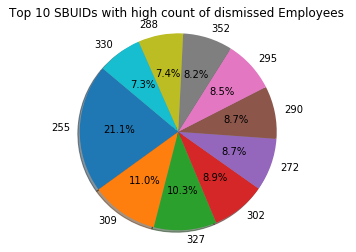

In [172]:
# Data to plot
labels = top10.SBUID.unique()
sizes = top10.Count.values

# Plot
plt.pie(sizes,  labels=labels, shadow=True, startangle=140, autopct='%1.1f%%')
plt.title('Top 10 SBUIDs with high count of dismissed Employees ')

plt.axis('equal')
plt.show()

# Feature generating
## Label encoding for future modeling: 
<a id="label_encoding"></a>

In [173]:
# data = result_DISM_DATE.copy()

In [174]:
data_final.head()

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target
3  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       0.9000           16            0                 0                 0      0              31            25                15                  1             9  0.559347            0  59.0             2 2013-05-01           NaT      0          0                      31                    25       1                   28       0
4  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       1.0000            0            0                 0                 0      0              32            26                15                  1             9  0.559347            0  59.0             2 2013-05-01           NaT      0          0                      32                    26       1                   27       0
5  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-03-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       0.5714            8            0                 0                 0      0              33            27                15                  1             9  0.559347            0  37.0             2 2013-05-01           NaT      0          0                      33                    27       1                   26       0
6  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-04-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000            0            0                 0                 0      0              34            28                15                  1             9  0.559347            0  54.0             2 2013-05-01           NaT      0          0                      34                    28       2                   25       0
7  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-05-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000           32            0                 0                 0      0              35             1                15                  1            22  0.568231            0  55.0             2 2013-05-01           NaT      0          0                      35                     1       2                   24       0

In [175]:
data_final.target.value_counts()

0    53284
1     1876
Name: target, dtype: int64

In [176]:
le_date = LabelEncoder()
data_final['Date_label'] = le_date.fit_transform(data_final.Date)

In [177]:
data_final.head()

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label
3  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       0.9000           16            0                 0                 0      0              31            25                15                  1             9  0.559347            0  59.0             2 2013-05-01           NaT      0          0                      31                    25       1                   28       0           0
4  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       1.0000            0            0                 0                 0      0              32            26                15                  1             9  0.559347            0  59.0             2 2013-05-01           NaT      0          0                      32                    26       1                   27       0           1
5  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-03-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       0.5714            8            0                 0                 0      0              33            27                15                  1             9  0.559347            0  37.0             2 2013-05-01           NaT      0          0                      33                    27       1                   26       0           2
6  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-04-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000            0            0                 0                 0      0              34            28                15                  1             9  0.559347            0  54.0             2 2013-05-01           NaT      0          0                      34                    28       2                   25       0           3
7  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-05-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000           32            0                 0                 0      0              35             1                15                  1            22  0.568231            0  55.0             2 2013-05-01           NaT      0          0                      35                     1       2                   24       0           4

In [178]:
data_final[data_final['DismissalDate'].isnull()==False]

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime    APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label
48     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-01-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                 1       0.0000            0            0                 0                 0      0               2             2                15                  1             9  0.173069            0    0.0             0 2017-12-01    2018-06-01      0          0                       2                     2       1                    5       0           0
49     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-02-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1       0.0000            0            0               136                 0      0               3             3                15                  1             9  0.173069            0    0.0             0 2017-12-01    2018-06-01      0          0                       3                     3       1                    4       0           1
50     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-03-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1       0.0000            0            0               176                 0      0               4             4                15                  1             9  0.173069            0    0.0             0 2017-12-01    2018-06-01      0          0                       4                     4       1                    3       1           2
51     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-04-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1       0.0000            0            0               152                 0      0               5             5                15                  1             9  0.173069            0    0.0             0 2017-12-01    2018-06-01      0          0                       5                     5       2                    2       1           3
52     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-05-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1       0.0000           40            0               160                 0      0               6             1                15                  1            22  0.182281            0    0.0             0 2017-12-01    2018-06-01      0          0                       6                     1       2                    1       1           4
53     0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-06-01           2   255         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1       0.0000           16            0               168                 0      0               7             2                15                  1            22  0.182281            0    0.0             0 2017-12-01    2018-06-01      0          1                       7                     2       2                    0       1           5
233    00ED0622-A212-45EA-B1BD-17F4602B7807 2018-04-01           1   108        441         0              11  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  8D06BC83-49E9-475B-9AC9-3D0AD15476CD     

In [179]:
data_final[data_final['EmployeeID']=='0040B626-4578-4C4B-B3CB-42270CEAFF6C']


EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime  APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label
48  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-01-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                 1          0.0            0            0                 0                 0      0               2             2                15                  1             9  0.173069            0  0.0             0 2017-12-01    2018-06-01      0          0                       2                     2       1                    5       0           0
49  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-02-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1          0.0            0            0               136                 0      0               3             3                15                  1             9  0.173069            0  0.0             0 2017-12-01    2018-06-01      0          0                       3                     3       1                    4       0           1
50  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-03-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1          0.0            0            0               176                 0      0               4             4                15                  1             9  0.173069            0  0.0             0 2017-12-01    2018-06-01      0          0                       4                     4       1                    3       1           2
51  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-04-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1          0.0            0            0               152                 0      0               5             5                15                  1             9  0.173069            0  0.0             0 2017-12-01    2018-06-01      0          0                       5                     5       2                    2       1           3
52  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-05-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1          0.0           40            0               160                 0      0               6             1                15                  1            22  0.182281            0  0.0             0 2017-12-01    2018-06-01      0          0                       6                     1       2                    1       1           4
53  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-06-01           2   255         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1          0.0           16            0               168                 0      0               7             2                15                  1            22  0.182281            0  0.0             0 2017-12-01    2018-06-01      0          1                       7                     2       2                    0       1           5

In [180]:
data_final.PositionLevel.unique()

array([2, 3, 1, 0, 4, 8, 5, 6, 7, 9], dtype=object)

# Mean encoding for Date: 
<a id="mean_encoding"></a>

In [181]:
mean_encod = data_final.groupby('Date')['target'].mean()

In [182]:
mean_encod

Date
2018-01-01    0.000000
2018-02-01    0.000000
2018-03-01    0.017703
2018-04-01    0.031175
2018-05-01    0.045273
2018-06-01    0.059458
2018-07-01    0.056441
2018-08-01    0.052081
2018-09-01    0.050327
2018-10-01    0.048132
2018-11-01    0.034627
2018-12-01    0.024642
2019-01-01    0.012592
Name: target, dtype: float64

In [183]:
data_final.loc[:,'Date_label'] = data_final['Date'].map(mean_encod)

In [184]:
len(data_final.EmployeeID.unique())

4626

# Frequency encoding:
<a id="freq_encoding"></a>

In [185]:
freq_encoding = data_final.groupby('PositionLevel').size()/len(data_final)
freq_encoding

PositionLevel
0    0.063216
1    0.233503
2    0.319543
3    0.237001
4    0.081726
5    0.024565
6    0.015754
7    0.015664
8    0.006980
9    0.002049
dtype: float64

In [186]:
data_final.loc[:,'PositionLevel_freq_encod'] = data_final['PositionLevel'].map(freq_encoding)

In [187]:
freq_encoding1 = data_final.groupby('OnSite').size()/len(data_final)
freq_encoding1

OnSite
0    0.990899
1    0.009101
dtype: float64

In [188]:
data_final.loc[:,'OnSite_freq_encod'] = data_final['OnSite'].map(freq_encoding1)

In [189]:
def getFreqEncoder(feature_name, data):
    freq_encoding = data.groupby(feature_name).size()/len(data)
    display(freq_encoding)
    new_name = feature_name+'_freq_encod'
    data.loc[:,new_name] = data[feature_name].map(freq_encoding)
    return data

In [190]:
data_final = getFreqEncoder(feature_name = 'LanguageLevelID', data=data_final)

LanguageLevelID
0     0.104115
1     0.042495
3     0.003445
5     0.002756
6     0.003136
7     0.004895
9     0.126305
10    0.093310
11    0.153916
13    0.028209
14    0.012654
15    0.039467
18    0.146030
19    0.130638
20    0.096592
23    0.010914
24    0.000888
26    0.000236
dtype: float64

In [191]:
data_final.LanguageLevelID_freq_encod.describe()

count    55160.000000
mean         0.111403
std          0.040007
min          0.000236
25%          0.096592
50%          0.126305
75%          0.146030
max          0.153916
Name: LanguageLevelID_freq_encod, dtype: float64

In [192]:
#CompetenceGroupID
data_final = getFreqEncoder(feature_name = 'CompetenceGroupID', data=data_final)

CompetenceGroupID
0     0.261639
15    0.042277
16    0.004152
17    0.163923
19    0.017350
20    0.030384
21    0.088289
22    0.096991
23    0.085914
24    0.014902
25    0.004369
26    0.000109
27    0.000943
28    0.019090
29    0.041806
31    0.041570
32    0.013017
33    0.010950
34    0.000218
35    0.011149
36    0.031055
37    0.003843
39    0.014685
40    0.001378
dtype: float64

In [193]:
data_final = getFreqEncoder(feature_name = 'SBUID', data=data_final)

SBUID
6      0.001323
16     0.012146
20     0.016878
23     0.001740
25     0.004804
27     0.004206
29     0.035370
30     0.009010
31     0.002701
42     0.002248
47     0.000689
50     0.004768
55     0.025018
105    0.018437
106    0.002030
107    0.001178
108    0.003644
109    0.000036
110    0.001360
111    0.003662
115    0.009663
116    0.001740
117    0.002429
120    0.014358
122    0.000036
123    0.000852
126    0.002466
138    0.000399
148    0.000308
149    0.000834
153    0.000109
154    0.002049
155    0.004025
158    0.001142
168    0.000653
175    0.001577
181    0.003735
210    0.001432
218    0.001414
222    0.000073
233    0.001269
240    0.000471
247    0.001559
255    0.033049
257    0.002683
266    0.019561
268    0.024782
269    0.022498
270    0.000363
271    0.023006
272    0.039014
273    0.000381
274    0.000036
276    0.000326
282    0.001505
283    0.000780
284    0.026396
286    0.012872
288    0.043474
289    0.000236
290    0.036802
291    0.000453
29

In [194]:
data_final = getFreqEncoder(feature_name = 'DevCenterID', data=data_final)

DevCenterID
0     0.000073
1     0.538669
2     0.090935
3     0.046265
4     0.065392
5     0.042984
6     0.000109
8     0.100290
9     0.011059
10    0.006635
12    0.000888
13    0.035315
14    0.000508
16    0.021882
18    0.024166
20    0.002701
31    0.000363
32    0.001595
33    0.000671
34    0.003771
35    0.000852
36    0.004877
dtype: float64

# Weight of evidence for Internal project: 
<a id="woe_encoding"></a>

In [195]:
def getWoE_encoding(feature_name, data):
    woe_df = data.groupby(feature_name)['target'].mean()
    woe_df = pd.DataFrame(woe_df)
    display(woe_df)
    woe_df.rename(columns={'target':'Positive'},inplace=True)
    woe_df['Negative'] = 1-woe_df.Positive

    woe_df['Negative'] = np.where(woe_df['Negative']==0, 0.000001, woe_df['Negative'])

    woe_df['WoE'] = np.log(woe_df.Positive/woe_df.Negative)

    display(woe_df)
    new_name = feature_name+'_WoE'
    data.loc[:, new_name] = data[feature_name].map(woe_df['WoE'])
    return data
    
    

In [196]:
woe_df = data_final.groupby('IsInternalProject')['target'].mean()
woe_df = pd.DataFrame(woe_df)
woe_df

target
IsInternalProject          
0                  0.036343
1                  0.029123

In [197]:
woe_df.rename(columns={'target':'Positive'},inplace=True)

In [198]:
woe_df

Positive
IsInternalProject          
0                  0.036343
1                  0.029123

In [199]:
woe_df['Negative'] = 1-woe_df.Positive

In [200]:
woe_df['Negative'] = np.where(woe_df['Negative']==0, 0.000001, woe_df['Negative'])

In [201]:
woe_df['WoE'] = np.log(woe_df.Positive/woe_df.Negative)

In [202]:
woe_df

Positive  Negative       WoE
IsInternalProject                              
0                  0.036343  0.963657 -3.277742
1                  0.029123  0.970877 -3.506673

In [203]:
data_final.loc[:,'IsInternalProject_WoE'] = data_final['IsInternalProject'].map(woe_df['WoE'])

In [204]:
# #Quarter:
data_final = getWoE_encoding(feature_name='Quarter', data = data_final)

target
Quarter          
1        0.007751
2        0.045508
3        0.052936
4        0.035894

Positive  Negative       WoE
Quarter                              
1        0.007751  0.992249 -4.852093
2        0.045508  0.954492 -3.043294
3        0.052936  0.947064 -2.884286
4        0.035894  0.964106 -3.290635

In [205]:
#IsTrainee:
data_final = getWoE_encoding(feature_name='IsTrainee', data = data_final)

target
IsTrainee          
0          0.034420
1          0.027968

Positive  Negative       WoE
IsTrainee                              
0          0.034420  0.965580 -3.334091
1          0.027968  0.972032 -3.548326

# Backward encoding: 
<a id="backward_encoding"></a>

In [206]:
ce_backward = ce.BackwardDifferenceEncoder(cols = ['FunctionalOfficeID'])
funct_office_encoded = ce_backward.fit_transform(data_final.FunctionalOfficeID, data_final.target)
funct_office_encoded

intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6
3              1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
4              1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
5              1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
6              1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
7              1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
8              1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
9              1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
10             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
11             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
12             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
13             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
14             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
15             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
22             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
23             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
24             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
25             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
26             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
27             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
28             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
29             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
30             1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125
31             1                -0.875                 -0.75              

In [207]:
funct_office_encoded.columns

Index(['intercept', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6'], dtype='object')

In [208]:
data_final.index

Int64Index([    3,     4,     5,     6,     7,     8,     9,    10,    11,    12,
            ...
            59202, 59203, 59204, 59205, 59206, 59207, 59208, 59209, 59210, 59211], dtype='int64', length=55160)

In [209]:
ce_basen = ce.BaseNEncoder(cols = ['PaymentTypeId'])
encoded_data = ce_basen.fit_transform(data_final.PaymentTypeId, data_final.target)
encoded_data

PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4
3                    0                0                0                0                1
4                    0                0                0                0                1
5                    0                0                0                0                1
6                    0                0                0                0                1
7                    0                0                0                1                0
8                    0                0                0                1                0
9                    0                0                0                1                0
10                   0                0                0                1                0
11                   0                0                0                1                0
12                   0                0                0                1                0
13                   0                0                0                1                0
14                   0                0                0                1                0
15                   0                0                0                1                0
22                   0                0                0                0                1
23                   0                0                0                0                1
24                   0                0                0                0                1
25                   0                0                0                0                1
26                   0                0                0                1                0
27                   0                0                0                1                0
28                   0                0                0                1                0
29                   0                0                0                1                0
30                   0                0                0                1                0
31                   0                0                0                1                0
32                   0                0                0                1                0
33                   0                0                0                1                0
34                   0                0                0                1                0
35                   0                0                0                0                1
36                   0                0                0                0                1
37                   0                0                0                0                1
38                   0                0                0                0                1
39                   0                0                0                1                0
40                   0                0                0                1                0
41                   0                0                0                1                0
42                   0                0                0                1                0
43                   0                0                0                1                0
44                   0                0                0                1                0
45                   0                0                0                1                0
46                   0                0                0                1                0
47                   0                0                0                1                0
48                   0                0                0                0                1
49                   0                0                0                0                1
50                   0                0                0                0                1
51                   0                0                0                0                1
52 

In [210]:
# del data_df

In [211]:
len(data_final.index)

55160

In [212]:
len(funct_office_encoded.index)

55160

In [213]:
data_final[data_final['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB'][['Date', 'HiringDate','DismissalDate',
                                                                        'diffs_between_dates', 'target' ]]

Date HiringDate DismissalDate  diffs_between_dates  target
12 2018-01-01 2017-05-01    2018-06-01                    5       0
13 2018-02-01 2017-05-01    2018-06-01                    4       0
14 2018-03-01 2017-05-01    2018-06-01                    3       1
15 2018-04-01 2017-05-01    2018-06-01                    2       1
16 2018-05-01 2017-05-01    2018-06-01                    1       1
17 2018-06-01 2017-05-01    2018-06-01                    0       1

In [214]:
data_df = pd.concat([data_final, funct_office_encoded],axis=1)

In [215]:
data_df.shape

(55160, 52)

In [216]:
#data_df = pd.merge(data, funct_office_encoded, how='left', on=data.index)# left_index=True, right_index=True)


In [217]:
data_df[data_df['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB'][['Date', 'HiringDate','DismissalDate',
                                                                        'diffs_between_dates' ]]

Date HiringDate DismissalDate  diffs_between_dates
12 2018-01-01 2017-05-01    2018-06-01                    5
13 2018-02-01 2017-05-01    2018-06-01                    4
14 2018-03-01 2017-05-01    2018-06-01                    3
15 2018-04-01 2017-05-01    2018-06-01                    2
16 2018-05-01 2017-05-01    2018-06-01                    1
17 2018-06-01 2017-05-01    2018-06-01                    0

In [218]:
data_df_last =  pd.concat([data_df, encoded_data],axis=1)
#= pd.merge(data_df, encoded_data, left_index=True, right_index=True)

In [219]:
data_df_last.shape

(55160, 57)

In [220]:
data_df_last.columns

Index(['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite', 'MonthOnPosition', 'MonthOnSalary', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel', 'HiringDate', 'DismissalDate', 'Hired', 'Dismissed', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'Quarter', 'diffs_between_dates', 'target', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'IsInternalProject_WoE', 'Quarter_WoE', 'IsTrainee_WoE', 'intercept', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1',
       'Paymen

In [221]:
data_df_last[data_df_last['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB'][['Date', 'HiringDate','DismissalDate',
                                                                        'diffs_between_dates' ]]

Date HiringDate DismissalDate  diffs_between_dates
12 2018-01-01 2017-05-01    2018-06-01                    5
13 2018-02-01 2017-05-01    2018-06-01                    4
14 2018-03-01 2017-05-01    2018-06-01                    3
15 2018-04-01 2017-05-01    2018-06-01                    2
16 2018-05-01 2017-05-01    2018-06-01                    1
17 2018-06-01 2017-05-01    2018-06-01                    0

In [222]:
# enc_targ = ce.Encoder(method='target')
# fm_enc_targ = enc_targ.fit_transform(feature_matrix, features, feature_matrix['value'])
# fm_enc_targ

In [223]:
data_df_last.HiringDate.isnull().value_counts()

False    55160
Name: HiringDate, dtype: int64

In [224]:
data_df_last.describe()

Utilization          Wage            APM         Hired     Dismissed  diffs_between_dates        target    Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE   Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4
count  55160.000000  55160.000000   55160.000000  55160.000000  55160.000000         55160.000000  55160.000000  55160.000000              55160.000000       55160.000000                55160.000000                  55160.000000      55160.000000            55160.000000           55160.000000  55160.000000   55160.000000    55160.0          55160.000000          55160.000000          55160.000000          55160.000000          55160.000000          55160.000000          55160.000000     55160.000000     55160.000000     55160.000000     55160.000000     55160.000000
mean       0.599208      0.663722       4.747353      0.015247      0.008503            20.442023      0.034010      0.034010                  0.224626           0.981964                    0.111403                      0.128630          0.022413                0.319283              -3.351705     -3.591670      -3.347700        1.0             -0.087056             -0.214558             -0.525979             -0.445323             -0.332125             -0.225073             -0.120830         0.000236         0.059119         0.109228         0.680022         0.370649
std        0.488414      0.746356    2258.401934      0.122533      0.091817             5.909410      0.181257      0.019785                  0.095059           0.093235                    0.040007                      0.091140          0.011985                0.238016               0.107061      0.822334       0.052253        0.0              0.408768              0.498747              0.298693              0.227351              0.202578              0.155906              0.064439         0.015350         0.235849         0.311928         0.466472         0.482983
min        0.000000      0.009706 -291432.000000      0.000000      0.000000             0.000000      0.000000      0.000000                  0.002049           0.009101                    0.000236                      0.000109          0.000018                0.000073              -3.506673     -4.852093      -3.548326        1.0             -0.875000             -0.750000             -0.625000             -0.500000             -0.375000             -0.250000             -0.125000         0.000000         0.000000         0.000000         0.000000         0.000000
25%        0.000000      0.239203       0.000000      0.000000      0.000000            18.000000      0.000000      0.017703                  0.233503           0.990899                    0.096592                      0.041806          0.012146                0.065392              -3.506673     -4.852093      -3.334091        1.0              0.125000             -0.750000             -0.625000             -0.500000             -0.375000             -0.250000             -0.125000         0.000000         0.000000         0.000000         0.000000         0.000000
50%        1.000000      0.526445      38.000000      0.000000      0.000000            21.000000      0.000000      0.034627                  0.237001           0.990899                    0.126305                      0.096991          0.024529                0.538669              -3.277742     -3.290635      -3.334091        1.0              0.125000              0.250000             -0.625000             -0.500000             -0.375000             -0.250000             -0.125000         0.000000         0.000000         0.000000         1.000000         0.0000

In [225]:
# import dateutil.relativedelta
from dateutil import relativedelta

In [226]:
data_df_last['HiringDate'] = pd.to_datetime(data_df_last['HiringDate'], format='%Y-%m-%d')
data_df_last['DismissalDate'] = pd.to_datetime(data_df_last['DismissalDate'], format='%Y-%m-%d')

In [227]:
data_df_last['Months_in_SS'] = data_df_last[['HiringDate', 'Date']].apply(lambda row: relativedelta.relativedelta(
                                                                                                row[1],
                                                                                                row[0]).months +
                                                                                            relativedelta.relativedelta(
                                                                                                row[1],
                                                                                                row[0]).years * 12,
                                                                                            axis=1)

In [228]:
data_df_last = getFreqEncoder(feature_name = 'HiringDate', data=data_df_last)

HiringDate
1998-08-01    0.000471
2000-02-01    0.000236
2000-08-01    0.000236
2001-01-01    0.000707
2001-03-01    0.000236
2001-08-01    0.000236
2001-09-01    0.000707
2001-10-01    0.000471
2001-12-01    0.000236
2002-01-01    0.000236
2002-03-01    0.000471
2002-04-01    0.000471
2002-05-01    0.000236
2002-06-01    0.000236
2002-09-01    0.000471
2002-10-01    0.000580
2002-11-01    0.000471
2002-12-01    0.000236
2003-01-01    0.000236
2003-03-01    0.000471
2003-04-01    0.000236
2003-06-01    0.000471
2003-07-01    0.000870
2003-08-01    0.000236
2003-09-01    0.000236
2003-11-01    0.000399
2003-12-01    0.000236
2004-04-01    0.000236
2004-05-01    0.000236
2004-07-01    0.000707
2004-08-01    0.001178
2004-09-01    0.000471
2004-10-01    0.001178
2004-11-01    0.000943
2004-12-01    0.000707
2005-01-01    0.001414
2005-02-01    0.000707
2005-03-01    0.000707
2005-04-01    0.000471
2005-05-01    0.000471
2005-06-01    0.001106
2005-07-01    0.000707
2005-08-01    0.000707


In [229]:
data_df_last.columns

Index(['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite', 'MonthOnPosition', 'MonthOnSalary', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel', 'HiringDate', 'DismissalDate', 'Hired', 'Dismissed', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'Quarter', 'diffs_between_dates', 'target', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'IsInternalProject_WoE', 'Quarter_WoE', 'IsTrainee_WoE', 'intercept', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1',
       'Paymen

In [230]:
data_df_last[data_df_last['EmployeeID']=='00DDA8FB-5640-4311-B84C-B81719C24483']

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime  APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE  Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  \
214  00DDA8FB-5640-4311-B84C-B81719C24483 2018-01-01           1   105         22         0               0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                 1          0.0            0            0                 0                 0      0             129             1                 0                 -1             3  0.019412            0  0.0             0 2007-04-01           NaT      0          0                      48                     1       1                   28       0    0.000000                  0.063216           0.990899                    0.104115                      0.261639          0.018437                0.538669              -3.506673    -4.852093      -3.334091          1                 0.125                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                1                0                1           129   
215  00DDA8FB-5640-4311-B84C-B81719C24483 2018-02-01           1   105         22         0               0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                 1          0.0            0            0                 0                 0      0             130             2                 0                 -1             3  0.019459            0  0.0             0 2007-04-01           NaT      0          0                      49                     2       1                   27       0    0.000000                  0.063216           0.990899                    0.104115                      0.261639          0.018437                0.538669              -3.506673    -4.852093      -3.334091          1                 0.125                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                1                0                1           130   
216  00DDA8FB-5640-4311-B84C-B81719C24483 2018-03-01           1   105         22         0               0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F       NaN                 1          0.0            0            0                 0                 0      0             131             3                 0                 -1             3  0.019515            0  0.0             0 2007-04-01           NaT      0          0                      50                     3       1                   26       0    0.017703                  0.063216           0.990899                    0.104115                      0.261639          0.018437                0.538669              -3.506673    -4.852093      -3.334091          1                 0.125                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                1                0                1           131   
217  00DDA8FB-5640-4311-B84C-B81719C24483 2018-04-01           1   105         22         0               0  2C

In [231]:
sorted(set(data_df_last.Date.unique()))

[numpy.datetime64('2018-01-01T00:00:00.000000000'),
 numpy.datetime64('2018-02-01T00:00:00.000000000'),
 numpy.datetime64('2018-03-01T00:00:00.000000000'),
 numpy.datetime64('2018-04-01T00:00:00.000000000'),
 numpy.datetime64('2018-05-01T00:00:00.000000000'),
 numpy.datetime64('2018-06-01T00:00:00.000000000'),
 numpy.datetime64('2018-07-01T00:00:00.000000000'),
 numpy.datetime64('2018-08-01T00:00:00.000000000'),
 numpy.datetime64('2018-09-01T00:00:00.000000000'),
 numpy.datetime64('2018-10-01T00:00:00.000000000'),
 numpy.datetime64('2018-11-01T00:00:00.000000000'),
 numpy.datetime64('2018-12-01T00:00:00.000000000'),
 numpy.datetime64('2019-01-01T00:00:00.000000000')]

In [232]:
len(data_df_last.EmployeeID.unique())

4626

In [233]:
train = data_df_last.drop(columns=['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee',
                      'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject',
                      'OnSite', 'MonthOnPosition', 'MonthOnSalary', 'CompetenceGroupID', 
                      'FunctionalOfficeID', 'PaymentTypeId','PositionLevel', 'Quarter','HiringDate', 
                      'DismissalDate', 'intercept'], axis=1).copy()

In [234]:
train.columns

Index(['Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'Wage', 'BonusOneTime', 'APM', 'Hired', 'Dismissed', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'diffs_between_dates', 'target', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'IsInternalProject_WoE', 'Quarter_WoE', 'IsTrainee_WoE', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1', 'PaymentTypeId_2', 'PaymentTypeId_3', 'PaymentTypeId_4', 'Months_in_SS', 'HiringDate_freq_encod'], dtype='object')

In [235]:
train.shape

(55160, 38)

In [236]:
train.Utilization.describe()

count    55160.000000
mean         0.599208
std          0.488414
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: Utilization, dtype: float64

In [237]:
data_df_last.groupby(['Date', 'target'])['target'].count()

Date        target
2018-01-01  0         3859
2018-02-01  0         3991
2018-03-01  0         3995
            1           72
2018-04-01  0         4040
            1          130
2018-05-01  0         4070
            1          193
2018-06-01  0         4097
            1          259
2018-07-01  0         4146
            1          248
2018-08-01  0         4259
            1          234
2018-09-01  0         4208
            1          223
2018-10-01  0         4153
            1          210
2018-11-01  0         4154
            1          149
2018-12-01  0         4156
            1          105
2019-01-01  0         4156
            1           53
Name: target, dtype: int64

In [238]:
not_dism = data_df_last.groupby('EmployeeID')['target'].sum().reset_index(name = 'target')


In [239]:
not_dism.target.value_counts()

0    4157
4     469
Name: target, dtype: int64

In [240]:
not_dism[not_dism['target']==4]

EmployeeID  target
3     0040B626-4578-4C4B-B3CB-42270CEAFF6C       4
18    00ED0622-A212-45EA-B1BD-17F4602B7807       4
19    00EDA2E5-78A3-4FB4-9EED-183E04A89523       4
33    0189E23E-CCDB-4ACB-8A52-16954E08B495       4
40    01DDE66C-877E-47FE-A9B0-75570D9FF3DF       4
44    021C5074-AC15-45B0-A272-B6682CDB1EB4       4
50    027E7A4C-A4CA-4803-9DB8-EBE090E89407       4
53    02C6F1BB-4DA1-4B87-9A69-958F614D0A96       4
66    03DDBC5F-5FB7-47B7-9A55-9789021C0BCE       4
69    0414E7F5-972D-43BE-BEED-ACA3B97DF9E2       4
77    04845926-8AD1-480E-81BB-111C7DF8E209       4
81    04BA1287-E958-4EC9-B704-7E2F2742CA56       4
83    04D7DA1C-ECC7-4A03-B7B3-CF7CE1A09B71       4
84    04FBA4D6-B7BD-4567-BE6D-9EB634718AA7       4
86    050F1661-59BC-4E8A-8D92-928F1CD14FEC       4
109   06638E92-0001-4F74-8686-4BF14592C547       4
115   06AC365E-B778-4FA2-9A0B-B64E9F788782       4
116   06B41A37-46AE-4140-86A5-FE35D44D648F       4
125   076ADC82-88DC-4919-94DD-5F5993641A71       4
127   07779D9A-CF7A-43BC-800E-B408E6F0453C       4
130   07AD917A-3D1A-456E-87E7-2B88380106A9       4
133   07FC8811-28CC-4436-92CB-6248A22547B9       4
135   0811626E-BC1D-4930-98D5-7A8B60FC7014       4
151   090E01E4-67DD-4CD2-91B3-1196E3C35343       4
152   092DBC89-7471-401E-B28D-C0F9ADC07267       4
173   0B358184-0525-4C9B-A69B-FA9A4BF67027       4
198   0C773DC3-0E6D-471F-B590-5742A3B1D2C5       4
204   0CCDD7B7-59B7-492F-9B91-DD9B830D3411       4
210   0CF87794-F9BF-4FEC-876D-F68E6A7AB454       4
220   0DB06A3E-E1F1-45C7-8816-EDA81910BE1C       4
222   0DB2A48D-61A9-4842-B7B8-1F1AB65C6949       4
251   0F62DA59-0E86-46C8-91F8-7655E33659D6       4
260   0FFC6ABD-BDF5-46CC-AC3C-2B8357A81B22       4
275   10E994CB-28F3-4C74-A116-2206709BFAED       4
276   10F31BAC-00EE-4CB8-BD58-DA5B611BE7B6       4
283   1173F499-668C-4E9B-8EDA-9A8773132E65       4
284   117546AD-C911-41BB-9B46-BD79210E847D       4
285   118737C0-1FFC-47B8-A2AF-D87E84C86F6A       4
290   11E66766-4B8A-4D40-8AFD-09E639E8E373       4
294   124224EE-77B5-4C79-BF44-42973F3256AE       4
298   1266C7C0-1CBB-4839-A3F5-2D03E10052FA       4
306   12BB8DBB-D324-4E1D-A03E-7C1A8E5A05CB       4
311   1305411E-5060-42A6-AC96-45C958CEF12C       4
319   1375A825-37DF-401E-B9D2-DACFD0FEDCD2       4
326   14327EC0-EC0C-4FEC-AAD0-221EF79A4F9E       4
336   149D5CC2-14E4-44E6-BC91-A88C32ECB9FB       4
338   14B5A866-3860-4B55-818C-E6922104C936       4
342   151207B7-15E9-435B-8F1C-C23D259A59CE       4
354   15E33970-4ED6-4492-BB70-CD6485CBC66B       4
379   171C1C54-ADB7-4708-9303-30D3562EA39F       4
387   1799366B-AD20-406B-816A-93A05188BB44       4
407   186FC556-19FD-43DE-8119-0A25CC3FA905       4
417   18FFCA95-E23C-4DAF-9649-386AE731CD07       4
419   190B8FF1-A707-4340-A657-26DAAE48B9D0       4
430   1961A1C9-B34D-451E-A35D-B5EA085695D0       4
444   1A25CF70-0EC2-4BF3-B487-6E0303EE62E3       4
452   1A78A7B2-7DD1-4961-B0B8-E3BB4056EA68       4
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711       4
475   1C17AE41-5E0C-4EBE-A228-36EF85733F1B       4
492   1D24F674-15A7-4726-9C06-438C7C229F1F       4
495   1D4D885F-0A00-416C-AD8A-E4EDC1614AD9       4
513   1E80ACF5-4779-4228-B4C6-C1092EB80BB9       4
517   1EAABD1E-3F04-48DE-8691-AF997BCD8F3E       4
518   1EABC2FC-4BCC-4D9F-AB12-CA4DCE29D2F2       4
530   1F523EE7-DC26-4B77-816C-448F3B65B1B9       4
535   1FFED538-9E1C-463B-A1B8-F860378B5726       4
542   204F858E-C73D-44D0-A225-DF2C6D30A8CE       4
559   21339311-5AD0-4EBD-B10E-36E008FA0612       4
560   213400F6-E9F4-4485-9ED2-DF802D0DC4EC       4
571   21CA2F7F-06F0-42EF-BE5E-9A5353D554D1       4
575   220283A1-F60D-4A0B-B696-4011A5D4E145       4
580   227203B4-91E5-41D2-8BB8-D7488329D92E       4
594   23054EA6-FDD5-4BB2-89A7-EBA5BC61431C       4
601   236CE9C6-098D-47CD-98ED-A0E3D81A5646       4
605   23808F77-B3E7-43D6-8914-FF0A09DF0894       4
609   23BF07C5-1F76-4FC0-AB21-16C63CCEEB30       4
621   2481F8AE-1777-400D-988C-26891F72EB5A       4
626   24C8CCA8-4F82-4A02-99D8-D07F7118D462       4
633

In [241]:
data_df_last[data_df_last['EmployeeID']=='4DE20825-C981-47E4-B52E-A414EFE51629']

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE  Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  \
0  4DE20825-C981-47E4-B52E-A414EFE51629 2018-01-01           8   295          3         0              11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                 0       1.0625            0            0                 0                 0      0               5             5                23                  0             9  0.377066            0  58.0             2 2017-09-01    2018-06-01      0          0                       5                     5       1                    5       0    0.000000                  0.319543           0.990899                    0.153916                      0.085914          0.025562                 0.10029              -3.277742    -4.852093      -3.334091          1                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
1  4DE20825-C981-47E4-B52E-A414EFE51629 2018-02-01           8   295          3         0              11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                 0       1.0437            0            0                 0                 0      0               6             6                23                  0             9  0.377066            0  58.0             2 2017-09-01    2018-06-01      0          0                       6                     6       1                    4       0    0.000000                  0.319543           0.990899                    0.153916                      0.085914          0.025562                 0.10029              -3.277742    -4.852093      -3.334091          1                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
2  4DE20825-C981-47E4-B52E-A414EFE51629 2018-03-01           8   295          3         0              11  9417F950-B661-48E8-84CF-8DDB1F8FDB50  B9FD730C-C05B-4756-936B-7547FD4C9B04                 0       1.0511            0            0                 0                 0      0               7             7                23                  0             9  0.377066            0  58.0             2 2017-09-01    2018-06-01      0          0                       7                     7       1                    3       1    0.017703                  0.319543           0.990899                    0.153916                      0.085914          0.025562                 0.10029              -3.277742    -4.852093      -3.334091          1                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
3  4DE20825-C981-47E4-B52E-A414EFE51629 2018-04-01       

In [242]:
data_df_last[data_df_last['EmployeeID']=='C6BA2627-5046-4D52-A72A-EE90750252DB'][['Date', 'HiringDate','DismissalDate',
                                                                        'diffs_between_dates' , 'Dismissed','target']]

Date HiringDate DismissalDate  diffs_between_dates  Dismissed  target
12 2018-01-01 2017-05-01    2018-06-01                    5          0       0
13 2018-02-01 2017-05-01    2018-06-01                    4          0       0
14 2018-03-01 2017-05-01    2018-06-01                    3          0       1
15 2018-04-01 2017-05-01    2018-06-01                    2          0       1
16 2018-05-01 2017-05-01    2018-06-01                    1          0       1
17 2018-06-01 2017-05-01    2018-06-01                    0          1       1

In [243]:
data_df_last[data_df_last['EmployeeID']=='090E01E4-67DD-4CD2-91B3-1196E3C35343'][['Date', 'HiringDate','DismissalDate',
                                                                        'diffs_between_dates' , 'target', 'Dismissed']]

Date HiringDate DismissalDate  diffs_between_dates  target  Dismissed
1858 2018-01-01 2014-03-01    2018-07-01                    6       0          0
1859 2018-02-01 2014-03-01    2018-07-01                    5       0          0
1860 2018-03-01 2014-03-01    2018-07-01                    4       0          0
1861 2018-04-01 2014-03-01    2018-07-01                    3       1          0
1862 2018-05-01 2014-03-01    2018-07-01                    2       1          0
1863 2018-06-01 2014-03-01    2018-07-01                    1       1          0
1864 2018-07-01 2014-03-01    2018-07-01                    0       1          1

In [244]:
#not_dism['Date']= (datetime.datetime.strptime(max_date, '%Y-%m-%d') + pd.DateOffset(months=1)).strftime('%Y-%m-%d')

# Preparation to modeling
<a id="prep_modeling"></a>

### Validation before modeling:

In [245]:
data_df_last.groupby(['Date', 'target'])['EmployeeID'].nunique()

Date        target
2018-01-01  0         3859
2018-02-01  0         3991
2018-03-01  0         3995
            1           72
2018-04-01  0         4040
            1          130
2018-05-01  0         4070
            1          193
2018-06-01  0         4097
            1          259
2018-07-01  0         4146
            1          248
2018-08-01  0         4259
            1          234
2018-09-01  0         4208
            1          223
2018-10-01  0         4153
            1          210
2018-11-01  0         4154
            1          149
2018-12-01  0         4156
            1          105
2019-01-01  0         4156
            1           53
Name: EmployeeID, dtype: int64

In [246]:
data_df_last.groupby(['Date', 'Dismissed'])['EmployeeID'].nunique()

Date        Dismissed
2018-01-01  0            3859
2018-02-01  0            3991
2018-03-01  0            4067
2018-04-01  0            4170
2018-05-01  0            4263
2018-06-01  0            4284
            1              72
2018-07-01  0            4336
            1              58
2018-08-01  0            4430
            1              63
2018-09-01  0            4365
            1              66
2018-10-01  0            4302
            1              61
2018-11-01  0            4259
            1              44
2018-12-01  0            4209
            1              52
2019-01-01  0            4156
            1              53
Name: EmployeeID, dtype: int64

In [247]:
valid1 = data_df_last[data_df_last['Dismissed']==1]
len(valid1.EmployeeID.unique())

469

In [248]:
valid2 = data_df_last[data_df_last['target']==1]
len(valid2.EmployeeID.unique())

469

In [249]:
data_df_last[#(data_df_last['Date']=='2018-03-01')&
      (data_df_last['EmployeeID']=='0040B626-4578-4C4B-B3CB-42270CEAFF6C')]

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime  APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE  Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  \
48  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-01-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  98B5051A-5B06-4BA4-917C-23B97888E4A2                 1          0.0            0            0                 0                 0      0               2             2                15                  1             9  0.173069            0  0.0             0 2017-12-01    2018-06-01      0          0                       2                     2       1                    5       0    0.000000                  0.063216           0.990899                    0.126305                      0.042277          0.027248                0.090935              -3.506673    -4.852093      -3.548326          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
49  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-02-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1          0.0            0            0               136                 0      0               3             3                15                  1             9  0.173069            0  0.0             0 2017-12-01    2018-06-01      0          0                       3                     3       1                    4       0    0.000000                  0.063216           0.990899                    0.126305                      0.042277          0.027248                0.090935              -3.506673    -4.852093      -3.548326          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
50  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-03-01           2   330         68         1               9  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  789AC07B-7078-4CBE-BD2C-9D70D85DBC5B                 1          0.0            0            0               176                 0      0               4             4                15                  1             9  0.173069            0  0.0             0 2017-12-01    2018-06-01      0          0                       4                     4       1                    3       1    0.017703                  0.063216           0.990899                    0.126305                      0.042277          0.027248                0.090935              -3.506673    -4.852093      -3.548326          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
51  0040B626-4578-4C4B-B3CB-42270CEAFF6C 2018-04-01       

In [250]:
data_df_final =data_df_last[data_df_last['Dismissed']!=1] 

In [251]:
data_df_final.shape

(54691, 59)

In [252]:
data_df_final.Dismissed.value_counts()

0    54691
Name: Dismissed, dtype: int64

In [253]:
data_df_last.target.value_counts()

0    53284
1     1876
Name: target, dtype: int64

In [254]:
data_df_final.target.value_counts()

0    53284
1     1407
Name: target, dtype: int64

In [255]:
1876-1407

469

## Modeling
<a id="first_modeling"></a>

In [256]:
from hyperopt import space_eval
from sklearn.ensemble import RandomForestClassifier
#from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.utils.class_weight import compute_sample_weight
from hyperopt import hp, tpe, fmin
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
import pickle as pc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, fbeta_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report




In [257]:
data_df_final.shape

(54691, 59)

In [258]:
data_df_final.duplicated().value_counts()

False    54691
dtype: int64

In [259]:
clm = ['Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 
       'HourLockedReserve', 'Wage', 'BonusOneTime', 'APM', 'Correct_MonthOnPosition',
       'Correct_MonthOnSalary',  'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod',
       'IsInternalProject_WoE',  'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'IsTrainee_WoE', 
       'SBUID_freq_encod', 'DevCenterID_freq_encod', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1',
       'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5',
       'FunctionalOfficeID_6',
       'PaymentTypeId_0', 'PaymentTypeId_1', 'PaymentTypeId_2', 'PaymentTypeId_3', 
       'PaymentTypeId_4', 'Months_in_SS', 'HiringDate_freq_encod'] #'Quarter_WoE'

In [260]:
train_date = data_df_final.Date.max() - pd.DateOffset(months=3)
train_date

Timestamp('2018-10-01 00:00:00')

In [261]:
import datetime

In [262]:
max_date = data_df_final.Date.max()
max_date = max_date.strftime('%Y-%m-%d')
test_date = (datetime.datetime.strptime(max_date, '%Y-%m-%d') - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
test_date

'2018-12-01'

In [263]:
#data_df['target']=data_df['Dismissed']

In [264]:
data_df_final.target.value_counts()

0    53284
1     1407
Name: target, dtype: int64

In [265]:
from sklearn import preprocessing 
scaler = preprocessing.RobustScaler()


In [266]:
X_train_ = data_df_final[data_df_final.Date < train_date][clm]
y_train_ = data_df_final[data_df_final.Date < train_date].target
X_test_ = data_df_final[(data_df_final.Date > train_date) & (data_df_final.Date < test_date)][clm]
y_test_ = data_df_final[(data_df_final.Date > train_date) & (data_df_final.Date < test_date)].target
X_test1_ = data_df_final[(data_df_final.Date == train_date)][clm]
y_test1_ = data_df_final[(data_df_final.Date == train_date)].target
X_apply = data_df_final[(data_df_final.Date > train_date)][clm]  
y_apply = data_df_final[(data_df_final.Date > train_date)].target


In [267]:
type(X_train_), type(y_test1_)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [268]:
# X_train_ = scaler.fit_transform(X_train_)
# X_test_ = scaler.fit_transform(X_test_)
# X_test1_ = scaler.fit_transform(X_test1_)
# X_apply = scaler.fit_transform(X_apply)

In [269]:
# X_train_ = pd.DataFrame(X_train_, columns=clm)
# X_test_ = pd.DataFrame(X_test_, columns=clm)
# X_test1_ = pd.DataFrame(X_test1_, columns=clm)
# X_apply = pd.DataFrame(X_apply, columns=clm)

In [270]:
X_apply .shape

(12624, 33)

In [271]:
print('X_train.shape', X_train_.shape)
       


X_train.shape (37765, 33)


In [272]:
 model2 = RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500,
                                        min_samples_leaf=12,
                                        bootstrap=True,
                                        #max_depth=15,
                                        min_samples_split=35,
                                        # max_leaf_nodes=25,
                                        min_weight_fraction_leaf=0.0,
                                        #max_features=25,
                                        criterion='entropy',
                                        n_jobs=-1, 
                                        random_state=40)  # ,
model2.fit(X_train_, y_train_)
print('1.Train: there are: data <', str(train_date))
print(pd.crosstab(y_train_, model2.predict(X_train_)))
print("Classification Report Train:")
print(classification_report(y_train_, model2.predict(X_train_)))

print('2. Validation: there are =', str(train_date))
print(pd.crosstab(y_test1_, model2.predict(X_test1_)))
print(classification_report(y_test1_, model2.predict(X_test1_)))
print('3. Test: \nThere are: >' + str(train_date) + '<' + test_date)
print(pd.crosstab(y_test_, model2.predict(X_test_)))
print("Classification Report Test:")
print(classification_report(y_test_, model2.predict(X_test_)))



1.Train: there are: data < 2018-10-01 00:00:00
col_0       0     1
target             
0       35932   733
1          11  1089
Classification Report Train:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36665
           1       0.60      0.99      0.75      1100

    accuracy                           0.98     37765
   macro avg       0.80      0.99      0.87     37765
weighted avg       0.99      0.98      0.98     37765

2. Validation: there are = 2018-10-01 00:00:00
col_0      0    1
target           
0       4053  100
1         97   52
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4153
           1       0.34      0.35      0.35       149

    accuracy                           0.95      4302
   macro avg       0.66      0.66      0.66      4302
weighted avg       0.95      0.95      0.95      4302

3. Test: 
There are: >2018-10-01 00:00:00<2018-12-01
col_0      0   1
t

In [273]:
X_train_.head()

Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime   APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod
3       0.9000           16            0                 0                 0  0.559347            0  59.0                      31                    25    0.000000                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.004206                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            56               0.005602
4       1.0000            0            0                 0                 0  0.559347            0  59.0                      32                    26    0.000000                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.004206                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            57               0.005602
5       0.5714            8            0                 0                 0  0.559347            0  37.0                      33                    27    0.017703                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            58               0.005602
6       1.0000            0            0                 0                 0  0.559347            0  54.0                      34                    28    0.031175                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            59               0.005602
7       1.0000           32            0                 0                 0  0.568231            0  55.0                      35                     1    0.045273                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            60               0.005602

Feature Importance:


Index(['PaymentTypeId_0', 'FunctionalOfficeID_6', 'OnSite_freq_encod', 'FunctionalOfficeID_5', 'FunctionalOfficeID_4', 'HourLockedReserve', 'FunctionalOfficeID_3', 'IsTrainee_WoE', 'FunctionalOfficeID_2', 'PaymentTypeId_1', 'IsInternalProject_WoE', 'PaymentTypeId_2', 'FunctionalOfficeID_0', 'HourSickness', 'FunctionalOfficeID_1', 'BonusOneTime', 'HourMobileReserve', 'PaymentTypeId_3', 'PaymentTypeId_4', 'HourVacation', 'Utilization', 'PositionLevel_freq_encod', 'Correct_MonthOnSalary', 'APM', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'DevCenterID_freq_encod', 'Correct_MonthOnPosition', 'SBUID_freq_encod', 'Wage', 'HiringDate_freq_encod', 'Months_in_SS', 'Date_label'], dtype='object')

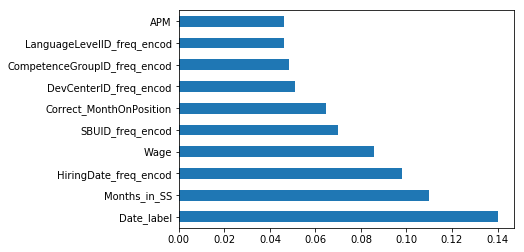

In [274]:
#X_train_act = pd.DataFrame(X_train_, columns=clm)
print('Feature Importance:')
display(X_train_.columns[np.argsort(model2.feature_importances_)])
(pd.Series(model2.feature_importances_, index=X_train_.columns)
   .nlargest(10)
   .plot(kind='barh'))

## Model1 tuning and results
<a id="model1_tunning_results"></a>

In [276]:
kfold = 5
def model__tune(model_pr_rc):
    q = 1
    for train_indices, test_indices in k_fold.split(X_train_, y_train_):
        model_pr_rc.fit(X_train_.values[train_indices], y_train_.values[train_indices])
        print('F_beta score:')
        print(fbeta_score(y_train_.values[test_indices],
                             model_pr_rc.predict(X_train_.values[test_indices]),
                             beta=1.7))
#         print(f1_score(y_train_.values[test_indices],
#                        model_pr_rc.predict(X_train_.values[test_indices])))  # ,
        q = q * (fbeta_score(y_train_.values[test_indices],
                             model_pr_rc.predict(X_train_.values[test_indices]),
                             average='macro',
                             beta=1.7)) ** (3 / 4) * (recall_score(y_train_.values[test_indices],
                                                                    model_pr_rc.predict(
                                                                        X_train_.values[test_indices]),
                                                                    pos_label=0) ** (1 / 4))
        return (q ** (1 / kfold))  # because k-fold = 5

def objective_params(params):
    params_model = {
        # 'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': int(params['max_features']),
        'criterion': params['criterion']
                    }
    print(params_model)
    model_pr_rc = RandomForestClassifier(**params_model, class_weight='balanced', n_jobs=-1)
    score = model__tune(model_pr_rc)
    print(score)
    return -score

space = {
    # 'max_depth': hp.quniform('max_depth', 3,25, 1),
    'max_features': hp.quniform('max_features', 5,15, 3),
    # 'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 25, 500, 10),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 15, 1),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'seed': hp.choice('seed', [10])
}
k_fold = StratifiedKFold(n_splits=kfold)
best = fmin(fn=objective_params,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

print('Best params:', best)

print('Apply best model:')
best = space_eval(space, best)
model_pr_rc = RandomForestClassifier(class_weight='balanced',
                                     # bootstrap=True,
                                     min_samples_leaf=np.int(best['min_samples_leaf']),
                                     n_estimators=np.int(best['n_estimators']),
                                     criterion=best['criterion'],
                                     # max_depth = np.int(best['max_depth']),
                                     # max_features = np.int(best['max_features']),
                                     random_state=42
                                     )
model_pr_rc.fit(X_train_, y_train_)
print("\nClassification Report Train:<", str(train_date))
print(pd.crosstab(y_train_, model_pr_rc.predict(X_train_)))
print(classification_report(y_train_, model_pr_rc.predict(X_train_)))
print('\nTest:>' + str(train_date) + '<' + str(test_date))
print(pd.crosstab(y_test_, model_pr_rc.predict(X_test_)))
print('Classification Report Test:')
print(classification_report(y_test_, model_pr_rc.predict(X_test_)))
print('\nTest1, there are =', str(train_date))
print(pd.crosstab(y_test1_, model_pr_rc.predict(X_test1_)))
print(classification_report(y_test1_, model_pr_rc.predict(X_test1_)))
# print('\nNew')
# print(pd.crosstab(y_new, model_pr_rc.predict(X_new)))
# print(classification_report(y_new, model_pr_rc.predict(X_new)))
# print('\nNew1:')
# print(pd.crosstab(y_new1, model_pr_rc.predict(X_new1)))
# print(classification_report(y_new1, model_pr_rc.predict(X_new1)))

{'n_estimators': 460, 'min_samples_leaf': 2, 'max_features': 12, 'criterion': 'entropy'}
F_beta score:                                                                  
0.005977258758451136                                                           
0.9007510457084564                                                             
{'n_estimators': 490, 'min_samples_leaf': 4, 'max_features': 12, 'criterion': 'entropy'}
F_beta score:                                                                  
0.02916916616676665                                                            
0.9036466501806101                                                             
{'n_estimators': 190, 'min_samples_leaf': 10, 'max_features': 9, 'criterion': 'gini'}
F_beta score:                                                                  
0.09542109566639413                                                            
0.9112528797567614                                                             
{'n_estimators':

0.1110325142715314                                                             
0.911960853035304                                                              
{'n_estimators': 330, 'min_samples_leaf': 12, 'max_features': 6, 'criterion': 'gini'}
F_beta score:                                                                  
0.13755998989643847                                                            
0.9156381055597417                                                             
{'n_estimators': 90, 'min_samples_leaf': 11, 'max_features': 9, 'criterion': 'entropy'}
F_beta score:                                                                  
0.0670867604139029                                                             
0.9071195732417869                                                             
{'n_estimators': 360, 'min_samples_leaf': 6, 'max_features': 6, 'criterion': 'gini'}
F_beta score:                                                                  
0.028738179669030736 

0.12749082328264288                                                            
0.9148752566979551                                                             
100%|████████| 100/100 [04:47<00:00,  2.27s/it, best loss: -0.9167434817137485]
Best params: {'criterion': 1, 'max_features': 6.0, 'min_samples_leaf': 14.0, 'n_estimators': 230.0, 'seed': 0}
Apply best model:

Classification Report Train:< 2018-10-01 00:00:00
col_0       0     1
target             
0       35908   757
1          14  1086
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36665
           1       0.59      0.99      0.74      1100

    accuracy                           0.98     37765
   macro avg       0.79      0.98      0.86     37765
weighted avg       0.99      0.98      0.98     37765


Test:>2018-10-01 00:00:00<2018-12-01
col_0      0   1
target          
0       4095  59
1         93  12
Classification Report Test:
              precision    recall  f1-s

In [ ]:
X_apply.shape

In [277]:
print('APPLY MOdel on:')
print('Data >', str(train_date))
print('\nFinally predict_proba:')
#result = data_df_last[data_df_last.index.isin(X_apply.index) == True]
result = data_df_final[data_df_final['Date']>train_date]

result.shape

APPLY MOdel on:
Data > 2018-10-01 00:00:00

Finally predict_proba:


(12624, 59)

In [278]:
pred_class = model_pr_rc.predict(X_apply)

In [279]:
result.tail()

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE  Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  \
59200  FFED12A3-5B28-4101-908A-2851CBADE045 2018-12-01           1    29        121         0              13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  A6793CB4-C35C-4481-850F-A21DBA4BAB21                 1       0.0000            0            0                 0                 0      0              60            13                 0                 -1            21  0.215524          178   0.0             3 2009-03-01           NaT      0          0                      59                    13       4                   17       0    0.024642                  0.237001           0.990899                    0.028209                      0.261639          0.035370                0.538669              -3.506673    -3.290635      -3.334091          1                 0.125                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                1   
59201  FFED12A3-5B28-4101-908A-2851CBADE045 2019-01-01           1    29        121         0              13  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  A6793CB4-C35C-4481-850F-A21DBA4BAB21                 1       0.0000            0            0                 0                 0      0              61             1                 0                 -1            21  0.265196            0   0.0             3 2009-03-01           NaT      0          0                      60                     1       1                   16       0    0.012592                  0.237001           0.990899                    0.028209                      0.261639          0.035370                0.538669              -3.506673    -4.852093      -3.334091          1                 0.125                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                1   
59209  FFF3B179-1D20-40FF-A330-A051BDF37301 2018-11-01           1   295          2         0              18  9417F950-B661-48E8-84CF-8DDB1F8FDB50  56FF7210-52AF-4E4D-BEE9-3411E73BF063                 0       1.0284            0            0                 0                 0      0               3             3                22                  0            22  0.148063            0  73.0             1 2018-04-01           NaT      0          0                       3                     3       4                   18       0    0.034627                  0.233503           0.990899                    0.146030                      0.096991          0.025562                0.538669              -3.277742    -3.290635      -3.334091          1                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0   
59210  FFF3B179-1D20-40FF-A330-A051BDF37301 2

C:\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


('Totally, There are EmployeeIDs:', 4261)
Classification result 0    12469
1      155
Name: prediction_class, dtype: int64
count    12624.000000
mean         0.188833
std          0.114585
min          0.005094
25%          0.096866
50%          0.168869
75%          0.259422
max          0.753126
Name: predict_probability, dtype: float64


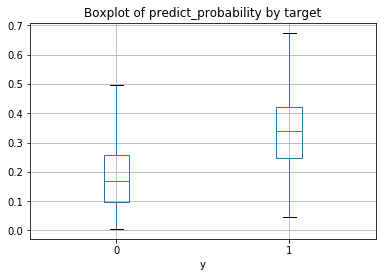

In [280]:
result['prediction_class'] = pred_class
res_proba = pd.DataFrame({'y': y_apply, 'pred_prob': model_pr_rc.predict_proba(X_apply)[:, 1]})
bp1 = res_proba.boxplot('pred_prob', 'y', showfliers=False)
plt.suptitle('')
plt.title('Boxplot of predict_probability by target')
result['predict_probability'] = res_proba['pred_prob']
print(('Totally, There are EmployeeIDs:', len(result.EmployeeID.unique())))
print('Classification result', result.prediction_class.value_counts())
print(result.predict_probability.describe())

In [281]:
len(result.EmployeeID.unique()),len(not_dism.EmployeeID.unique())

(4261, 4626)

In [282]:
empl_list = list(set(not_dism.EmployeeID.unique()).intersection(set(result.EmployeeID.unique())))
len(empl_list)

4261

In [283]:
def defineThresholdForModel(model_pr_rc, X_test1_, y_test1_):
    threshold_list = range(200, 680, 25)
    predict_prob = model_pr_rc.predict_proba(X_test1_)
    PREC = []
    RECALL = []
    thresold_new = []
    for tr in threshold_list:
        th = tr / 1000
        thresold_new.append(th)
        RECALL.append(recall_score(y_test1_ == True, predict_prob[:, 1] > th))
        PREC.append(precision_score(y_test1_ == True, predict_prob[:, 1] > th))
    xs = thresold_new
    print(thresold_new)
    y1 = np.array(PREC)
    y2 = np.array(RECALL)
    idx = np.argwhere((np.diff(np.sign(y1 - y2)) != 0) & np.isfinite(np.diff(np.sign(y1 - y2)))).flatten()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(thresold_new, PREC, label='Precision')
    ax.plot(thresold_new, RECALL, label='Recall')
    plt.title('Precision & Recall vs. Threshold in Model')
    plt.legend(['PRECISION', 'RECALL'])
    
    # plt.plot((xs[idx[i]]+xs[idx[i]+1])/2.,
    for i in range(len(idx)):
        x_int = round(((xs[idx[i]] + xs[idx[i] + 1]) / 2), 4)
        y_int = round((y1[idx[i]] + y1[idx[i] + 1] + y2[idx[i]] + y2[idx[i] + 1]) / 4, 4)
        plt.plot(x_int, y_int, 'ro')
    plt.show()
    print('Coordinates of interseption_point is: (' + str(x_int) + ', ' + str(y_int) + ')')
    print('So, Threshold is equals: ', x_int)
    return x_int

[0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675]


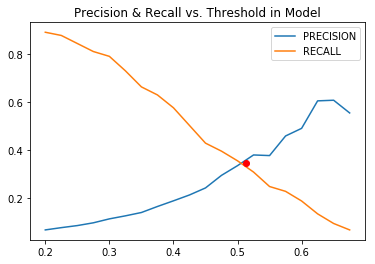

Coordinates of interseption_point is: (0.5125, 0.345)
So, Threshold is equals:  0.5125


In [284]:
threshold = defineThresholdForModel(model_pr_rc, X_test1_, y_test1_)

In [285]:
threshold

0.5125

In [286]:
result[result['EmployeeID']=='00EDA2E5-78A3-4FB4-9EED-183E04A89523']

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE  Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  \
253  00EDA2E5-78A3-4FB4-9EED-183E04A89523 2018-11-01           1   304         14         0              19  EEC8A1B3-7DA0-4EE5-82D3-8DECCAB845F8  6E2A157B-A810-4A12-A178-619624E6AA46                 0       1.0344            8            8                 0                 0      0               4             4                17                  1            22  0.338899            0  64.0             2 2016-08-01    2018-12-01      0          0                       4                     4       4                    1       1    0.034627                  0.319543           0.990899                    0.130638                      0.163923          0.021954                0.538669              -3.277742    -3.290635      -3.334091          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0   

     Months_in_SS  HiringDate_freq_encod  prediction_class  predict_probability  
253            27                 0.0157                 0             0.342317

In [287]:
data_df_final[data_df_final['EmployeeID']=='00EDA2E5-78A3-4FB4-9EED-183E04A89523']

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE  Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  \
243  00EDA2E5-78A3-4FB4-9EED-183E04A89523 2018-01-01           1   304        206         0              11  EEC8A1B3-7DA0-4EE5-82D3-8DECCAB845F8  6E2A157B-A810-4A12-A178-619624E6AA46                 0       0.9000           16            0                 0                 0      0               4             4                17                  1             9  0.230320            0  66.0             1 2016-08-01    2018-12-01      0          0                       4                     4       1                   11       0    0.000000                  0.233503           0.990899                    0.153916                      0.163923          0.021954                0.538669              -3.277742    -4.852093      -3.334091          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
244  00EDA2E5-78A3-4FB4-9EED-183E04A89523 2018-02-01           1   304        206         0              11  EEC8A1B3-7DA0-4EE5-82D3-8DECCAB845F8  6E2A157B-A810-4A12-A178-619624E6AA46                 0       1.0000            0            0                 0                 0      0               5             5                17                  1             9  0.230320            0  66.0             1 2016-08-01    2018-12-01      0          0                       5                     5       1                   10       0    0.000000                  0.233503           0.990899                    0.153916                      0.163923          0.021954                0.538669              -3.277742    -4.852093      -3.334091          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
245  00EDA2E5-78A3-4FB4-9EED-183E04A89523 2018-03-01           1   304        206         0              19  EEC8A1B3-7DA0-4EE5-82D3-8DECCAB845F8  6E2A157B-A810-4A12-A178-619624E6AA46                 0       1.0000            0           12                 0                 0      0               6             1                17                  1             9  0.263222            0  64.0             1 2016-08-01    2018-12-01      0          0                       6                     1       1                    9       0    0.017703                  0.233503           0.990899                    0.130638                      0.163923          0.021954                0.538669              -3.277742    -4.852093      -3.334091          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
246  00EDA2E5-78A3-4FB4-9EED-183E04A89523 2018-04-0

In [288]:
data_df_final.columns

Index(['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite', 'MonthOnPosition', 'MonthOnSalary', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel', 'HiringDate', 'DismissalDate', 'Hired', 'Dismissed', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'Quarter', 'diffs_between_dates', 'target', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'IsInternalProject_WoE', 'Quarter_WoE', 'IsTrainee_WoE', 'intercept', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1',
       'Paymen

In [289]:
empl_history.columns

Index(['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite', 'MonthOnPosition', 'MonthOnSalary', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel'], dtype='object')

In [290]:
competitions_df = data_df_last[['EmployeeID', 'Date', 'DevCenterID', 'SBUID',
                                'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 
                                'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation',
                                'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite',
                                'MonthOnPosition', 'MonthOnSalary', 'CompetenceGroupID', 'FunctionalOfficeID', 
                                'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel', 
                                'Correct_MonthOnPosition', 'Correct_MonthOnSalary']]

In [291]:
data_df_final.shape, data_df_last.shape

((54691, 59), (55160, 59))

In [292]:
competitions_df.shape, empl_history.shape

((55160, 27), (59328, 25))

In [293]:
competitions_df.drop(columns=['MonthOnPosition', 'MonthOnSalary'], inplace=True)

C:\miniconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [294]:
competitions_df.rename(columns={'Correct_MonthOnPosition':'MonthOnPosition', 'Correct_MonthOnSalary':'MonthOnSalary'}, inplace=True)

C:\miniconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [295]:
competitions_df.shape, empl_history.shape

((55160, 25), (59328, 25))

In [296]:
competitions_df.columns

Index(['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel', 'MonthOnPosition', 'MonthOnSalary'], dtype='object')

In [ ]:
#competitions_df.to_csv('competitions_data.csv')

In [ ]:
#competitions_df = pd.read_csv('competitions_data.csv')

In [314]:
competitions_df.columns

Index(['EmployeeID', 'Date', 'DevCenterID', 'SBUID', 'PositionID', 'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 'IsInternalProject', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'OnSite', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId', 'Wage', 'BonusOneTime', 'APM', 'PositionLevel', 'MonthOnPosition', 'MonthOnSalary'], dtype='object')

In [316]:
gr_ = competitions_df.groupby('EmployeeID')['MonthOnSalary'].first().reset_index(name='First')
gr_

EmployeeID First
0     00116D71-E87D-4B64-A566-1F29B2A798A8    25
1     0034ECA4-0562-4AC7-A826-4AE81C64D69F     5
2     00384806-F711-41BA-A924-8F27E996F891    17
3     0040B626-4578-4C4B-B3CB-42270CEAFF6C     2
4     005B5FD6-FD19-4924-98E4-4C06F7F6BF2C     1
5     0061CAE7-B123-46B0-9BF7-E1E94E9AD80B    36
6     006E332A-B32B-4858-BB97-9DBB659283F1     7
7     0074F2BF-ECEA-484A-9355-BE8EE3E8642F    23
8     00822DB1-D4CB-4B8F-AF02-1FA6B6A44528     7
9     0086EAF5-5A95-4E6B-B5EF-1B22CDF0538E    15
10    00885F06-FFEA-48F6-A338-3439FA676787     1
11    008CD18A-3AFA-446F-A95E-DDAA8E6E3C6F     4
12    00965EE4-8EAD-40FB-81E0-DFAAF7BDA1CC     1
13    00A7B587-EFC6-4F19-9F9E-8E6EFB8872AC     2
14    00B70800-C2AC-4C2A-9203-22A0FA2B8502     3
15    00DBB0F8-26A9-4CC5-9C22-49FA570390CD     4
16    00DDA8FB-5640-4311-B84C-B81719C24483     1
17    00E30C7A-3400-4A74-B5A8-1532C766DB24     1
18    00ED0622-A212-45EA-B1BD-17F4602B7807     1
19    00EDA2E5-78A3-4FB4-9EED-183E04A89523     4
20    00FCA5BD-57A9-4776-ACC4-5C87AAE0981B     4
21    00FECE8C-199E-4548-8E15-A181437B454C     1
22    0102F36E-A2E6-47A8-897D-8D0E0548C86E     5
23    0111ADE3-853E-4C6C-85F8-498D07DEE3EA     5
24    011DB389-9B2E-4C6C-83CD-6F91A91C9B80    23
25    012ADF75-5DA7-43FF-83AE-BC2CD70B82E0    13
26    013D332B-6F8E-4203-9C64-412659240181    13
27    013EAEAF-733A-4E91-B828-A277FE29A039     9
28    014D740B-7BC8-4D3B-B217-EFBB80031D61    10
29    01592627-19B1-4EE3-8BE3-9516C04A29BD    36
30    0165D804-D58C-4503-97E1-ED68D145FDC6     2
31    01833567-CE7D-462F-8570-550D8DAD128C     9
32    01897048-132F-4532-9DC8-317908E0CAF5     6
33    0189E23E-CCDB-4ACB-8A52-16954E08B495     1
34    018E2508-EA16-425A-93CC-AF61FAD752AF     4
35    019F007F-C0AC-4C4F-9983-56EB399A710C     9
36    01A07010-BA3B-4F00-B783-F54C4AD76A51     3
37    01B9C1BD-4E72-4DDA-AE32-E7F953F52A8D     4
38    01CA4274-3E4F-46BA-AA4F-516795D193D7    10
39    01D46824-D390-4B47-8EFE-FA0185FB717E     4
40    01DDE66C-877E-47FE-A9B0-75570D9FF3DF    36
41    01EA778C-04DD-4FD8-B25C-F002F80C48D5    21
42    01EC670D-45D5-4C37-AD4D-94F39A833D4A    34
43    01EDC1A7-5DA7-4939-854B-0002E0DF548D     1
44    021C5074-AC15-45B0-A272-B6682CDB1EB4    24
45    021F7056-67EF-4793-B384-94964F286E87     6
46    024834B1-1947-481B-80F6-DD7A058394C6     4
47    0252EC1E-A025-44A3-8559-5C796368AA02     6
48    025E58AB-DAFC-4EC0-8BCB-2F42BDE1662E    14
49    02695875-3A84-4CAF-859E-CB31DF4BC04A     4
50    027E7A4C-A4CA-4803-9DB8-EBE090E89407     1
51    0281222B-F5F6-4CF9-B0DB-64E99D1E7AD7     7
52    02C04E0E-0B13-4098-97E5-450CE882CC6C     1
53    02C6F1BB-4DA1-4B87-9A69-958F614D0A96     2
54    02D4EDAA-33FC-4FCE-858A-5CAF8DBC5F73     2
55    02E81497-FDCE-4E14-82A1-7ADAAECEDDBE     1
56    02F75356-23D4-47BC-B9AD-D074785D5AC5     1
57    030D5D1F-FA3A-4912-A788-51A444CCC7AE     1
58    0343E6D7-BE25-4360-81A0-A339DFB29684    23
59    037AD2D1-2682-41D4-82B8-9190420AE108    23
60    0382AA63-9DFB-42DC-B231-D21B35181E1C     1
61    038BCDE9-D124-44E3-A5F7-74106AC191C4     4
62    03922516-5132-4552-B949-4AEBF714B866     3
63    03A34A09-72A5-4A82-8CC2-B0E442E2CB96     1
64    03C6591F-19BA-42DF-BBDB-A5475DE103AD     1
65    03C92636-6E34-4A61-8A68-58AEC8D2C8F6     1
66    03DDBC5F-5FB7-47B7-9A55-9789021C0BCE     2
67    03E8DA4A-3ED1-4B96-8433-33385965636B     1
68    03F14FB3-2552-495A-8A2E-C9D7494436A0     6
69    0414E7F5-972D-43BE-BEED-ACA3B97DF9E2     3
70    041B6CD2-CCB0-4BF6-9812-84F1EC6EA9BA     3
71    041B8741-EC33-4C03-8E7D-E8B1E87D8755    13
72    0427A092-ECBF-44A7-8BCA-DD40ED80C18E    10
73    0431595B-280D-4D07-A3CD-0228534D6335     7
74    043A87C6-2129-41C0-A365-4E84A8C15396     1
75    043DE661-7639-4DA3-8374-BCFB84953099     1
76    04703F1D-8760-4648-BEC9-E70F8476DD95     7
77    04845926-8AD1-480E-81BB-111C7DF8E209     5
78    049A60DF-63D9-4940-8BA6-D4D9716DB27E     4
79    04A384F8-1C2E-498B-8B6B-D3308FCFE327     1
80    04B6FAE3-80AF-4CCD-9412-13BACA7454FA     9
81    04BA1287

In [318]:
#gr_.First.hist()


In [319]:
gr_ = competitions_df.groupby('EmployeeID')['MonthOnPosition'].first().reset_index(name='First')
gr_
# gr_.First.hist()
# plt.show()

EmployeeID First
0     00116D71-E87D-4B64-A566-1F29B2A798A8    31
1     0034ECA4-0562-4AC7-A826-4AE81C64D69F     6
2     00384806-F711-41BA-A924-8F27E996F891    23
3     0040B626-4578-4C4B-B3CB-42270CEAFF6C     2
4     005B5FD6-FD19-4924-98E4-4C06F7F6BF2C     1
5     0061CAE7-B123-46B0-9BF7-E1E94E9AD80B    41
6     006E332A-B32B-4858-BB97-9DBB659283F1     7
7     0074F2BF-ECEA-484A-9355-BE8EE3E8642F    48
8     00822DB1-D4CB-4B8F-AF02-1FA6B6A44528    14
9     0086EAF5-5A95-4E6B-B5EF-1B22CDF0538E    16
10    00885F06-FFEA-48F6-A338-3439FA676787     1
11    008CD18A-3AFA-446F-A95E-DDAA8E6E3C6F    38
12    00965EE4-8EAD-40FB-81E0-DFAAF7BDA1CC     1
13    00A7B587-EFC6-4F19-9F9E-8E6EFB8872AC     2
14    00B70800-C2AC-4C2A-9203-22A0FA2B8502     3
15    00DBB0F8-26A9-4CC5-9C22-49FA570390CD    10
16    00DDA8FB-5640-4311-B84C-B81719C24483    48
17    00E30C7A-3400-4A74-B5A8-1532C766DB24     1
18    00ED0622-A212-45EA-B1BD-17F4602B7807     1
19    00EDA2E5-78A3-4FB4-9EED-183E04A89523     4
20    00FCA5BD-57A9-4776-ACC4-5C87AAE0981B     4
21    00FECE8C-199E-4548-8E15-A181437B454C     1
22    0102F36E-A2E6-47A8-897D-8D0E0548C86E     5
23    0111ADE3-853E-4C6C-85F8-498D07DEE3EA    23
24    011DB389-9B2E-4C6C-83CD-6F91A91C9B80    29
25    012ADF75-5DA7-43FF-83AE-BC2CD70B82E0    13
26    013D332B-6F8E-4203-9C64-412659240181    14
27    013EAEAF-733A-4E91-B828-A277FE29A039    41
28    014D740B-7BC8-4D3B-B217-EFBB80031D61    12
29    01592627-19B1-4EE3-8BE3-9516C04A29BD    46
30    0165D804-D58C-4503-97E1-ED68D145FDC6    33
31    01833567-CE7D-462F-8570-550D8DAD128C     9
32    01897048-132F-4532-9DC8-317908E0CAF5    12
33    0189E23E-CCDB-4ACB-8A52-16954E08B495     1
34    018E2508-EA16-425A-93CC-AF61FAD752AF    39
35    019F007F-C0AC-4C4F-9983-56EB399A710C    35
36    01A07010-BA3B-4F00-B783-F54C4AD76A51     8
37    01B9C1BD-4E72-4DDA-AE32-E7F953F52A8D     4
38    01CA4274-3E4F-46BA-AA4F-516795D193D7    11
39    01D46824-D390-4B47-8EFE-FA0185FB717E     4
40    01DDE66C-877E-47FE-A9B0-75570D9FF3DF    15
41    01EA778C-04DD-4FD8-B25C-F002F80C48D5     8
42    01EC670D-45D5-4C37-AD4D-94F39A833D4A    33
43    01EDC1A7-5DA7-4939-854B-0002E0DF548D     1
44    021C5074-AC15-45B0-A272-B6682CDB1EB4    14
45    021F7056-67EF-4793-B384-94964F286E87     6
46    024834B1-1947-481B-80F6-DD7A058394C6     4
47    0252EC1E-A025-44A3-8559-5C796368AA02     6
48    025E58AB-DAFC-4EC0-8BCB-2F42BDE1662E    24
49    02695875-3A84-4CAF-859E-CB31DF4BC04A    10
50    027E7A4C-A4CA-4803-9DB8-EBE090E89407     1
51    0281222B-F5F6-4CF9-B0DB-64E99D1E7AD7    26
52    02C04E0E-0B13-4098-97E5-450CE882CC6C     1
53    02C6F1BB-4DA1-4B87-9A69-958F614D0A96     7
54    02D4EDAA-33FC-4FCE-858A-5CAF8DBC5F73     2
55    02E81497-FDCE-4E14-82A1-7ADAAECEDDBE     1
56    02F75356-23D4-47BC-B9AD-D074785D5AC5     1
57    030D5D1F-FA3A-4912-A788-51A444CCC7AE     1
58    0343E6D7-BE25-4360-81A0-A339DFB29684    24
59    037AD2D1-2682-41D4-82B8-9190420AE108    48
60    0382AA63-9DFB-42DC-B231-D21B35181E1C     1
61    038BCDE9-D124-44E3-A5F7-74106AC191C4     4
62    03922516-5132-4552-B949-4AEBF714B866     7
63    03A34A09-72A5-4A82-8CC2-B0E442E2CB96     1
64    03C6591F-19BA-42DF-BBDB-A5475DE103AD     1
65    03C92636-6E34-4A61-8A68-58AEC8D2C8F6     1
66    03DDBC5F-5FB7-47B7-9A55-9789021C0BCE     2
67    03E8DA4A-3ED1-4B96-8433-33385965636B     1
68    03F14FB3-2552-495A-8A2E-C9D7494436A0     6
69    0414E7F5-972D-43BE-BEED-ACA3B97DF9E2     3
70    041B6CD2-CCB0-4BF6-9812-84F1EC6EA9BA     9
71    041B8741-EC33-4C03-8E7D-E8B1E87D8755    32
72    0427A092-ECBF-44A7-8BCA-DD40ED80C18E    10
73    0431595B-280D-4D07-A3CD-0228534D6335    15
74    043A87C6-2129-41C0-A365-4E84A8C15396     1
75    043DE661-7639-4DA3-8374-BCFB84953099    48
76    04703F1D-8760-4648-BEC9-E70F8476DD95     7
77    04845926-8AD1-480E-81BB-111C7DF8E209     5
78    049A60DF-63D9-4940-8BA6-D4D9716DB27E     8
79    04A384F8-1C2E-498B-8B6B-D3308FCFE327    31
80    04B6FAE3-80AF-4CCD-9412-13BACA7454FA    48
81    04BA1287

In [320]:
len(competitions_df.EmployeeID.unique())

4626

In [321]:
employees_fixed = employees[employees['EmployeeID'].isin(competitions_df.EmployeeID.unique())==True]

In [322]:
len(employees_fixed.EmployeeID.unique()), len(employees.EmployeeID.unique())

(4626, 5937)

In [323]:
#employees_fixed.to_csv('employees_fixed.csv')

In [326]:
#employees_fixed = pd.read_csv('employees_fixed.csv')

In [327]:
merge_df = pd.merge(competitions_df, employees_fixed, on='EmployeeID', how='left')

In [328]:
merge_df.shape

(55160, 27)

In [329]:
merge_df.head()

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel MonthOnPosition MonthOnSalary  HiringDate DismissalDate
0  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       0.9000           16            0                 0                 0      0                15                  1             9  0.559347            0  59.0             2              31            25  2013-05-01           NaN
1  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       1.0000            0            0                 0                 0      0                15                  1             9  0.559347            0  59.0             2              32            26  2013-05-01           NaN
2  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-03-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       0.5714            8            0                 0                 0      0                15                  1             9  0.559347            0  37.0             2              33            27  2013-05-01           NaN
3  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-04-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000            0            0                 0                 0      0                15                  1             9  0.559347            0  54.0             2              34            28  2013-05-01           NaN
4  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-05-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000           32            0                 0                 0      0                15                  1            22  0.568231            0  55.0             2              35             1  2013-05-01           NaN

In [330]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55160 entries, 0 to 55159
Data columns (total 27 columns):
EmployeeID            55160 non-null object
Date                  55160 non-null datetime64[ns]
DevCenterID           55160 non-null object
SBUID                 55160 non-null object
PositionID            55160 non-null object
IsTrainee             55160 non-null object
LanguageLevelID       55160 non-null object
CustomerID            55160 non-null object
ProjectID             52592 non-null object
IsInternalProject     55160 non-null object
Utilization           55160 non-null float64
HourVacation          55160 non-null object
HourSickness          55160 non-null object
HourMobileReserve     55160 non-null object
HourLockedReserve     55160 non-null object
OnSite                55160 non-null object
CompetenceGroupID     55160 non-null object
FunctionalOfficeID    55160 non-null object
PaymentTypeId         55160 non-null object
Wage                  55160 non-null float64
B

In [331]:
len(merge_df.EmployeeID.unique())

4626

# Apply model to predefined target:
<a id="apply1_on_target"></a>

## 1. Validation relation of Employees between target and prepared empl_history
<a id="validation_apply_and_target"></a>

In [332]:
target = pd.read_csv('target.csv')

In [333]:
target.head()

EmployeeID  target  is_public
0  00028962-8E9F-496C-B544-526B24CA1BCF       0          1
1  00116D71-E87D-4B64-A566-1F29B2A798A8       0          0
2  0019ADB2-228D-4301-9899-9C2F10F6C1AA       0          1
3  0034ECA4-0562-4AC7-A826-4AE81C64D69F       0          0
4  00384806-F711-41BA-A924-8F27E996F891       0          0

In [334]:
len(target.EmployeeID.unique()), len(employees.EmployeeID.unique()),len(empl_history.EmployeeID.unique())

(5057, 5937, 5937)

In [335]:
initial_empl = list(set(target.EmployeeID.unique()).intersection(set(set(empl_history.EmployeeID.unique()))))
len(initial_empl)

5057

In [336]:
competitions_df.head()

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel MonthOnPosition MonthOnSalary
3  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-01-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       0.9000           16            0                 0                 0      0                15                  1             9  0.559347            0  59.0             2              31            25
4  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-02-01           3   332         70         0              11  893EA22F-08BE-4F11-AD93-C50746E4565F  7F97465B-ED3C-45DB-BE96-86C7E493F0CD                 0       1.0000            0            0                 0                 0      0                15                  1             9  0.559347            0  59.0             2              32            26
5  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-03-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       0.5714            8            0                 0                 0      0                15                  1             9  0.559347            0  37.0             2              33            27
6  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-04-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000            0            0                 0                 0      0                15                  1             9  0.559347            0  54.0             2              34            28
7  00116D71-E87D-4B64-A566-1F29B2A798A8 2018-05-01           3   284         70         0              11  888A91D6-1F35-4337-ADCD-E4D7F0399DF1  4AAF7425-575B-46CB-A42D-F43A53187D32                 0       1.0000           32            0                 0                 0      0                15                  1            22  0.568231            0  55.0             2              35             1

In [337]:
empl_common = list(set(target.EmployeeID.unique()).intersection(set(set(competitions_df.EmployeeID.unique()))))
len(empl_common)

4154

In [338]:
excluded = list(set(target.EmployeeID.unique()).difference(set(set(competitions_df.EmployeeID.unique()))))

In [339]:
len(excluded)

903

In [365]:
excluded_ = list(set(target.EmployeeID.unique()).difference(set(set(result.EmployeeID.unique()))))
len(excluded_)

903

In [367]:
empl_common_ = list(set(target.EmployeeID.unique()).intersection(set(set(result.EmployeeID.unique()))))
len(empl_common_)

4154

In [340]:
excluded_df =empl_history[empl_history['EmployeeID'].isin(excluded)==True]

In [341]:
excluded_df[excluded_df['EmployeeID']=='00028962-8E9F-496C-B544-526B24CA1BCF']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime  APM  PositionLevel
0  00028962-8E9F-496C-B544-526B24CA1BCF 2018-11-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          0.0             0             0                  0                  0       0                1              1                  0                  -1              8  2.049515             0  0.0              5
1  00028962-8E9F-496C-B544-526B24CA1BCF 2018-12-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  3363F702-2DF4-4807-B0B4-BB78BBD8DB85                  1          0.0             0             0                  0                  0       0                2              2                  0                  -1              8  2.049515             0  0.0              5
2  00028962-8E9F-496C-B544-526B24CA1BCF 2019-01-01           20    441        1390          0                0  2CAB77C6-1BF5-4FA8-957E-D8F5C7DED66F  DFFA5CAC-1EAA-4572-B306-CB4053B8AE46                  1          0.0             8             0                  0                  0       0                3              3                  0                  -1              8  2.049515          1608  0.0              5

In [342]:
gr1 = excluded_df.groupby(['EmployeeID'])['Date'].nunique().reset_index(name='Date_counts')

In [344]:
gr1.Date_counts.unique()

array([ 3,  1,  4,  5,  2, 12,  7,  8,  6, 11], dtype=int64)

In [345]:
gr1[gr1['Date_counts']>=6]

EmployeeID  Date_counts
24   0587714E-8891-4CF6-8CF0-EEF724EED8F2           12
197  3406D90B-F774-4E3A-81EB-C28C5E6D21CE            7
234  3BE69071-21F9-48E5-9755-5A8EE80872CE            8
247  424840A8-02DD-40D7-8FC5-9F26CF7F2CC8            6
346  5E2B119D-A9EA-43A7-8903-9B60C84A37E8            7
426  70942689-A385-4F13-80F9-48FBB1BAC4CE            7
694  C9931CEB-81CF-42E0-8450-9F3E585D4963            8
859  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5            8
901  FF35BC11-0C1A-482B-B500-771C89C4CA91           11

In [346]:
data_preparation[data_preparation['EmployeeID']=='F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5']

EmployeeID       Date  DevCenterID  SBUID  PositionID  IsTrainee  LanguageLevelID                            CustomerID                             ProjectID  IsInternalProject  Utilization  HourVacation  HourSickness  HourMobileReserve  HourLockedReserve  OnSite  MonthOnPosition  MonthOnSalary  CompetenceGroupID  FunctionalOfficeID  PaymentTypeId      Wage  BonusOneTime    APM  PositionLevel HiringDate DismissalDate
56804  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2018-01-01            2    306         203          0               18  FB40AB74-6C54-4B22-A3BB-7A3CE5F2E6C2  3121846A-7B96-4197-8525-54E68574D197                  0        1.125             0             0                  0                  0       0               21             21                 23                   0              9  0.427736             0   58.0              2 2018-12-01           NaT
56805  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2018-02-01            2    272         203          0               18  FB40AB74-6C54-4B22-A3BB-7A3CE5F2E6C2  3121846A-7B96-4197-8525-54E68574D197                  0        1.125             0             0                  0                  0       0               22             22                 23                   0              9  0.427736             0   58.0              2 2018-12-01           NaT
56806  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2018-03-01            2    272         203          0               18  FB40AB74-6C54-4B22-A3BB-7A3CE5F2E6C2  3121846A-7B96-4197-8525-54E68574D197                  0        1.125            32             0                  0                  0       0               23             23                 23                   0              9  0.427736             0   57.0              2 2018-12-01           NaT
56807  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2018-04-01            2    272         203          0               18  FB40AB74-6C54-4B22-A3BB-7A3CE5F2E6C2  3121846A-7B96-4197-8525-54E68574D197                  0        1.125            32             0                  0                  0       0               24             24                 23                   0              9  0.427736             0   58.0              2 2018-12-01           NaT
56808  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2018-05-01            2    272         203          0               18  FB40AB74-6C54-4B22-A3BB-7A3CE5F2E6C2  3121846A-7B96-4197-8525-54E68574D197                  0        1.125             0             0                  0                  0       0               25              1                 23                   0             22  0.436620             0   58.0              2 2018-12-01           NaT
56809  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2018-06-01            2    272         203          0               18  FB40AB74-6C54-4B22-A3BB-7A3CE5F2E6C2  3121846A-7B96-4197-8525-54E68574D197                  0        1.125             0             0                  0                  0       0               26              2                 23                   0             22  0.436620             0 -199.0              2 2018-12-01           NaT
56810  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2018-12-01            2    352           3          0               18  3C40937E-CF84-49F3-AD70-4C645884E58D  23752EBA-B0C4-45D3-944F-1D1761868F1E                  0        0.000             0             0                  0                  0       0                1              1                 23                  -1             22  0.704120             0    0.0              2 2018-12-01           NaT
56811  F637B00A-A7D4-42B4-B9E7-F1A3112B3EC5 2019-01-01            2    352           3          0               18  3C40937E-CF84-49F3-AD70-4C645884E58D  E35278CB-C2D2-4252-9E5D-361F7CA670DC                  0        1.000             0             0                  0                  0       0                2              2                 23                   0             22  0.704120         

## 2. Prepare feature vector: 

### 2.1  Run on target:
<a id="run1_on_target"></a>

In [368]:
result.Date.unique()

array(['2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [370]:
df1 = target[['EmployeeID', 'target']]
df1 = df1[df1['EmployeeID'].isin(empl_common_)==True]

df2 = result[['Date','EmployeeID', 'Utilization',
 'HourVacation',
 'HourSickness',
 'HourMobileReserve',
 'HourLockedReserve',
 'Wage',
 'BonusOneTime',
 'APM',
 'Correct_MonthOnPosition',
 'Correct_MonthOnSalary',
 'Date_label',
 'PositionLevel_freq_encod',
 'OnSite_freq_encod',
 'IsInternalProject_WoE',
 'LanguageLevelID_freq_encod',
 'CompetenceGroupID_freq_encod',
 'IsTrainee_WoE',
 'SBUID_freq_encod',
 'DevCenterID_freq_encod',
 'FunctionalOfficeID_0',
 'FunctionalOfficeID_1',
 'FunctionalOfficeID_2',
 'FunctionalOfficeID_3',
 'FunctionalOfficeID_4',
 'FunctionalOfficeID_5',
 'FunctionalOfficeID_6',
 'PaymentTypeId_0',
 'PaymentTypeId_1',
 'PaymentTypeId_2',
 'PaymentTypeId_3',
 'PaymentTypeId_4',
 'Months_in_SS',
 'HiringDate_freq_encod']]
df2 = df2[df2['EmployeeID'].isin(empl_common_)==True]
#df2 = df2[clm]
df2.columns

Index(['Date', 'EmployeeID', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'Wage', 'BonusOneTime', 'APM', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'IsInternalProject_WoE', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'IsTrainee_WoE', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1', 'PaymentTypeId_2', 'PaymentTypeId_3', 'PaymentTypeId_4', 'Months_in_SS', 'HiringDate_freq_encod'], dtype='object')

In [374]:
len(df1.EmployeeID.unique()), len(df2.EmployeeID.unique())

(4154, 4154)

In [375]:
df2_res = pd.merge(df2, df1[['EmployeeID','target']], on ='EmployeeID', how='inner')

In [376]:
len(df2_res.EmployeeID.unique())

4154

In [380]:
dismm = df2_res[df2_res['target']==1]
len(dismm.EmployeeID.unique())

176

In [379]:
df2_res.target.value_counts(), df1.target.value_counts()

(0    11932
 1      528
 Name: target, dtype: int64, 0    3978
 1     176
 Name: target, dtype: int64)

In [381]:
#feature_vector = pd.concat([df1, df2, axis=1)

In [382]:
#feature_vector.head()

In [384]:
df2_res.Date.unique()

array(['2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [385]:
feature_vector = df2_res.copy()

In [386]:
feature_vector.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12460 entries, 0 to 12459
Data columns (total 36 columns):
Date                            12460 non-null datetime64[ns]
EmployeeID                      12460 non-null object
Utilization                     12460 non-null float64
HourVacation                    12460 non-null object
HourSickness                    12460 non-null object
HourMobileReserve               12460 non-null object
HourLockedReserve               12460 non-null object
Wage                            12460 non-null float64
BonusOneTime                    12460 non-null object
APM                             12460 non-null float64
Correct_MonthOnPosition         12460 non-null object
Correct_MonthOnSalary           12460 non-null object
Date_label                      12460 non-null float64
PositionLevel_freq_encod        12460 non-null float64
OnSite_freq_encod               12460 non-null float64
IsInternalProject_WoE           12460 non-null float64
LanguageLeve

In [387]:
feature_vector['Date']=feature_vector['Date'] + pd.DateOffset(months=3)

In [388]:
feature_vector.Date.unique()

array(['2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [389]:
X_apply.columns

Index(['Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'Wage', 'BonusOneTime', 'APM', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'IsInternalProject_WoE', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'IsTrainee_WoE', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1', 'PaymentTypeId_2', 'PaymentTypeId_3', 'PaymentTypeId_4', 'Months_in_SS', 'HiringDate_freq_encod'], dtype='object')

In [391]:
X_apply1 = feature_vector[X_apply.columns]

In [394]:
y_apply1 = feature_vector.target

In [395]:
X_apply1 .shape, y_apply1.shape

((12460, 33), (12460,))

In [393]:
pred_class1 = model_pr_rc.predict(X_apply1)

## Results on target:
<a id="results_on_target"></a>

('Totally, There are EmployeeIDs:', 4154)
Classification feature_vector
 0    12324
1      136
Name: prediction_class, dtype: int64
Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     11932
           1       0.15      0.04      0.06       528

    accuracy                           0.95     12460
   macro avg       0.55      0.51      0.52     12460
weighted avg       0.92      0.95      0.94     12460

count    12460.000000
mean         0.186877
std          0.112974
min          0.005094
25%          0.095992
50%          0.167476
75%          0.256901
max          0.753126
Name: predict_probability, dtype: float64


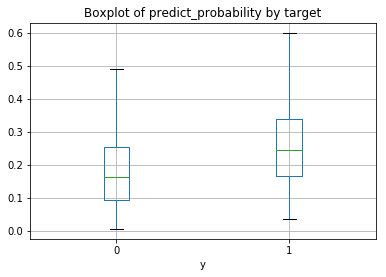

In [416]:
feature_vector['prediction_class'] = pred_class1
res_proba = pd.DataFrame({'y': y_apply1, 'pred_prob': model_pr_rc.predict_proba(X_apply1)[:, 1]})
bp2 = res_proba.boxplot('pred_prob', 'y', showfliers=False)
plt.suptitle('')
plt.title('Boxplot of predict_probability by target')
feature_vector['predict_probability'] = res_proba['pred_prob']
print(('Totally, There are EmployeeIDs:', len(feature_vector.EmployeeID.unique())))
print('Classification feature_vector\n', feature_vector.prediction_class.value_counts())
print("Report:\n")
print(classification_report(y_apply1, model_pr_rc.predict(X_apply1)))
print(feature_vector.predict_probability.describe())

[0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675]


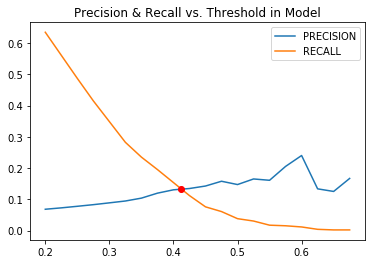

Coordinates of interseption_point is: (0.4125, 0.1324)
So, Threshold is equals:  0.4125


In [417]:
threshold1 = defineThresholdForModel(model_pr_rc, X_apply1, y_apply1)

In [400]:
threshold1

0.4125

In [401]:
feature_vector[feature_vector['EmployeeID']=='00EDA2E5-78A3-4FB4-9EED-183E04A89523']

Empty DataFrame
Columns: [Date, EmployeeID, Utilization, HourVacation, HourSickness, HourMobileReserve, HourLockedReserve, Wage, BonusOneTime, APM, Correct_MonthOnPosition, Correct_MonthOnSalary, Date_label, PositionLevel_freq_encod, OnSite_freq_encod, IsInternalProject_WoE, LanguageLevelID_freq_encod, CompetenceGroupID_freq_encod, IsTrainee_WoE, SBUID_freq_encod, DevCenterID_freq_encod, FunctionalOfficeID_0, FunctionalOfficeID_1, FunctionalOfficeID_2, FunctionalOfficeID_3, FunctionalOfficeID_4, FunctionalOfficeID_5, FunctionalOfficeID_6, PaymentTypeId_0, PaymentTypeId_1, PaymentTypeId_2, PaymentTypeId_3, PaymentTypeId_4, Months_in_SS, HiringDate_freq_encod, target, prediction_class, predict_probability]
Index: []

In [406]:
feature_vector[feature_vector['prediction_class']==1][['EmployeeID']]

EmployeeID
213    050999BF-4F60-4CFF-8AEB-8ABE2E52FF79
214    050999BF-4F60-4CFF-8AEB-8ABE2E52FF79
429    0AD06BC3-60F0-4CA8-9F1C-82EBF236BFB9
430    0AD06BC3-60F0-4CA8-9F1C-82EBF236BFB9
477    0BCA4EA2-6EF1-450E-B1D7-CFBF95EE2D44
478    0BCA4EA2-6EF1-450E-B1D7-CFBF95EE2D44
870    14989718-7A38-4473-80FB-07C08C56C9B3
951    169B0A1E-67C4-4232-8640-60B82EF20A7A
1082   18B96550-E1FE-4EF2-82DA-3C9240E4BB1D
1161   19F53C23-8B23-434C-9B77-09FF6DBA8B68
1305   1D4D91F4-1B35-47D9-AACD-B8F8DD95125F
1481   21761BF9-7EAA-4776-BE9A-10F9B373177B
1523   222E62AA-462D-4A2D-8783-8A1D437C24F6
1605   23ECF686-4458-4261-B57D-4477671D020D
1772   27C2A79F-F0C5-4D94-BDCC-EA1F22F89DA3
2024   2C5926D3-0A17-400F-BAD7-56909CE75835
2025   2C5926D3-0A17-400F-BAD7-56909CE75835
2204   3095F3FC-51D8-45AF-860B-26EEB04B86F1
2270   31C9735F-7315-4920-80CE-C2E55A179FB6
2271   31C9735F-7315-4920-80CE-C2E55A179FB6
2272   31C9735F-7315-4920-80CE-C2E55A179FB6
2437   35D1A9A7-07CF-4EBD-8B85-511CB9E8D403
2554   3851E36B-320E-4537-9F20-9E5ECA0EBBA0
2927   3F47D413-D42B-4D67-B86E-F16AF8E69059
2928   3F47D413-D42B-4D67-B86E-F16AF8E69059
2943   3FA9ADC3-2098-4CB6-9527-754347CFE211
3125   43A8D1AC-6DD1-4831-B5CE-ECCF347795CD
3126   43A8D1AC-6DD1-4831-B5CE-ECCF347795CD
3366   4827447C-0EDB-4D8E-9E67-101F7EA157E8
3446   497E5ED7-AFC8-48F8-A3D4-25252F1BC128
3447   497E5ED7-AFC8-48F8-A3D4-25252F1BC128
3527   4AD37D97-B7B3-4BE4-8156-26CB8931D6C1
3762   4EEDCE29-1269-4554-A447-651FCAEABFBD
3833   4FC528DA-DEDC-41D7-A96E-CC4ACB9EF976
3917   51B76043-7194-451B-B58E-DD8C7FF29CE5
3918   51B76043-7194-451B-B58E-DD8C7FF29CE5
3996   5372435A-A985-402F-9B53-427B96762F9F
3997   5372435A-A985-402F-9B53-427B96762F9F
4001   53A795E3-4CB0-40F1-8FA3-08F12D3556FA
4220   58D186EA-7140-4D0B-97B6-DE5C3E154B0B
4221   58D186EA-7140-4D0B-97B6-DE5C3E154B0B
4443   5E731939-A150-4393-BDBA-80959FF1FD99
4444   5E731939-A150-4393-BDBA-80959FF1FD99
4614   616D40B6-D2D5-4514-B5A2-612EB0EE5035
4697   62CA90DD-1034-442C-8B12-0CE9F0F1A76B
4698   62CA90DD-1034-442C-8B12-0CE9F0F1A76B
4724   6344194E-881B-4707-8920-729449B0239C
4725   6344194E-881B-4707-8920-729449B0239C
4749   63BF5B4A-1BB6-4BBB-BB9F-431CBCB556BA
4838   6560030D-8DA9-4811-97EB-F52B825AD152
4839   6560030D-8DA9-4811-97EB-F52B825AD152
4934   679E9650-9555-4531-B0EC-C2F3BDF799C5
4935   679E9650-9555-4531-B0EC-C2F3BDF799C5
5082   6A6D534A-EEB2-48EC-A299-A420D1857FAA
5198   6CA5B782-BAF9-4E5B-A0D1-41D9411F09F4
5264   6DDE8DB1-C7BC-43FD-9E40-6084DE63C4E9
5305   6ED955D8-40E1-4DD9-9D4D-0280FFD7D944
5417   70B99421-4CE5-45A8-9D37-93FFE6640902
5489   7220FCA9-6D4C-4422-A9EE-771D0C2E130D
5490   7220FCA9-6D4C-4422-A9EE-771D0C2E130D
5547   737548D5-950E-40C8-9982-A895663B7E73
5548   737548D5-950E-40C8-9982-A895663B7E73
5678   76660F38-3AB4-4C87-9B80-226AD5198A53
5679   76660F38-3AB4-4C87-9B80-226AD5198A53
6239   822E932D-4D59-4A04-8CBA-5EB9EFA47A1A
6240   822E932D-4D59-4A04-8CBA-5EB9EFA47A1A
6356   850137C7-137A-458A-ABB2-579C6256FA4E
6357   850137C7-137A-458A-ABB2-579C6256FA4E
6359   8527E808-BA67-44E8-B753-A6FC279CDFF3
6480   87D0B4F5-C181-452E-AAB6-A1FE3BAFA643
6500   887465AC-75CE-4E04-9F8F-6F82E5D2652C
6626   8A57CAC7-56DE-4E34-BF77-AF0F69777945
6631   8A6F42DE-39F9-4921-A616-7F1C8DF4D5FF
6743   8D0DBF95-3814-4733-88F3-DE7BC98FBE0A
6827   8ECE96B6-6560-4CBC-AD66-04BD40714497
6842   8EF8A00C-B051-4A00-86DD-AE8B1444766F
6843   8EF8A00C-B051-4A00-86DD-AE8B1444766F
6980   919FA464-8586-47C9-8D1F-EB68B21F4E8E
6981   919FA464-8586-47C9-8D1F-EB68B21F4E8E
7055   9393359E-18CC-43AF-A43A-FA63E1B59BBF
7056   9393359E-18CC-43AF-A43A-FA63E1B59BBF
7248   96D535D9-4EA4-465B-B5B1-6DF371FE6242
7366   997B20C5-F17F-480D-BA9A-E02FB331CD08
7667   9F3DED0A-6D1F-45DB-ADBD-0CD8D83FCFA9
7769   A0F1E650-1933-44B5-A0BE-363B5730EB67
7770   A0F1E650-1933-44B5-A0BE-363B5730EB67
7771   A0F1E650-1933-44B5-A0BE-363B5730EB67
7812   A205F510-0B43-47F0-9424-59AA8720BFA1
7913   A44DEE94-575A-4B78-92E3-6D1AFEC91388
7914   A44DEE94-575A-4B78-92E3-6D1AFEC91388
8022   A6D176C2-2940-4A2D-8DC

In [405]:
feature_vector[feature_vector['EmployeeID']=='00FCA5BD-57A9-4776-ACC4-5C87AAE0981B']

Date                            EmployeeID  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime   APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod  target  prediction_class  predict_probability
51 2019-02-01  00FCA5BD-57A9-4776-ACC4-5C87AAE0981B          1.0            8            0                 0                 0  0.279674            0  72.0                       8                     2    0.034627                  0.233503           0.990899              -3.277742                     0.14603                      0.041806      -3.334091          0.028209                0.538669                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            18               0.013905       1                 0             0.380102
52 2019-03-01  00FCA5BD-57A9-4776-ACC4-5C87AAE0981B          1.0            0           24                 0                 0  0.279674            0  63.0                       9                     3    0.024642                  0.233503           0.990899              -3.277742                     0.14603                      0.041806      -3.334091          0.028209                0.538669                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            19               0.013905       1                 0             0.426465
53 2019-04-01  00FCA5BD-57A9-4776-ACC4-5C87AAE0981B          1.0           40            0                 0                 0  0.279674            0  78.0                      10                     4    0.012592                  0.233503           0.990899              -3.277742                     0.14603                      0.041806      -3.334091          0.028209                0.538669                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            20               0.013905       1                 0             0.228424

In [415]:
feature_vector[feature_vector['EmployeeID']=='A0F1E650-1933-44B5-A0BE-363B5730EB67']

Date                            EmployeeID  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime  APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod  target  prediction_class  predict_probability
7769 2019-02-01  A0F1E650-1933-44B5-A0BE-363B5730EB67          0.0           40            0               176                 0  0.162211            0  0.0                       8                     5    0.034627                  0.233503           0.990899              -3.506673                    0.126305                      0.014685      -3.334091          0.033049                0.538669                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            12               0.024529       1                 1             0.632130
7770 2019-03-01  A0F1E650-1933-44B5-A0BE-363B5730EB67          0.0            0            0               160                 0  0.162211            0  0.0                       9                     6    0.024642                  0.233503           0.990899              -3.506673                    0.126305                      0.014685      -3.334091          0.033049                0.538669                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            13               0.024529       1                 1             0.601434
7771 2019-04-01  A0F1E650-1933-44B5-A0BE-363B5730EB67          0.0            0            0               168                 0  0.162211            0  0.0                      10                     7    0.012592                  0.233503           0.990899              -3.506673                    0.126305                      0.014685      -3.334091          0.033049                0.538669                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            14               0.024529       1                 1             0.534516

In [413]:
date_gr1 = feature_vector[feature_vector['prediction_class']==1].groupby(['EmployeeID'])['Date'].nunique().reset_index(name='Date_counts')
date_gr1.Date_counts.value_counts()

1    61
2    33
3     3
Name: Date_counts, dtype: int64

In [414]:
date_gr1[date_gr1['Date_counts']==3]

EmployeeID  Date_counts
14  31C9735F-7315-4920-80CE-C2E55A179FB6            3
59  A0F1E650-1933-44B5-A0BE-363B5730EB67            3
65  AC9353EC-D2E5-4C89-9F02-2430118D7F04            3

# Train model with history window 3 months
<a id="long_feat_vector"></a>

It means that the history data for the first 3 months will be added the 4th months in terms for each Employees.

In [418]:
data_df_final.Date.min()

Timestamp('2018-01-01 00:00:00')

In [419]:
first_empl = data_df_final[data_df_final['Date']=='2018-01-01']
first_empl.EmployeeID.unique()

array(['00116D71-E87D-4B64-A566-1F29B2A798A8',
       '0034ECA4-0562-4AC7-A826-4AE81C64D69F',
       '00384806-F711-41BA-A924-8F27E996F891', ...,
       'FFE9E1F0-1DB1-4BA8-A8FB-026E7DBCF49F',
       'FFEBB9DA-B0CF-49AE-91D3-14A0BF22219E',
       'FFED12A3-5B28-4101-908A-2851CBADE045'], dtype=object)

In [611]:
exm = data_df_final[data_df_final['EmployeeID']=='0034ECA4-0562-4AC7-A826-4AE81C64D69F']
exm

EmployeeID       Date DevCenterID SBUID PositionID IsTrainee LanguageLevelID                            CustomerID                             ProjectID IsInternalProject  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve OnSite MonthOnPosition MonthOnSalary CompetenceGroupID FunctionalOfficeID PaymentTypeId      Wage BonusOneTime   APM PositionLevel HiringDate DismissalDate  Hired  Dismissed Correct_MonthOnPosition Correct_MonthOnSalary Quarter  diffs_between_dates  target  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  SBUID_freq_encod  DevCenterID_freq_encod  IsInternalProject_WoE  Quarter_WoE  IsTrainee_WoE  intercept  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  \
22  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-01-01           2   272         14         0              19  09BD2772-32D5-41DD-978B-FE7879552583  9282F956-97DA-49C6-AF4A-8F20677080FC                 0         0.95            8            0                 0                 0      0               6             5                16                  1             9  0.347124            0  70.0             2 2015-09-01           NaT      0          0                       6                     5       1                   28       0    0.000000                  0.319543           0.990899                    0.130638                      0.004152          0.039014                0.090935              -3.277742    -4.852093      -3.334091          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
23  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-02-01           2   272         14         0              19  09BD2772-32D5-41DD-978B-FE7879552583  9282F956-97DA-49C6-AF4A-8F20677080FC                 0         1.00            0            0                 0                 0      0               7             6                16                  1             9  0.398453            0  67.0             2 2015-09-01           NaT      0          0                       7                     6       1                   27       0    0.000000                  0.319543           0.990899                    0.130638                      0.004152          0.039014                0.090935              -3.277742    -4.852093      -3.334091          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
24  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-03-01           2   272        207         0              19  09BD2772-32D5-41DD-978B-FE7879552583  9282F956-97DA-49C6-AF4A-8F20677080FC                 0         1.00           40            0                 0                 0      0               1             7                16                  1             9  0.398453            0  67.0             2 2015-09-01           NaT      0          0                       1                     7       1                   26       0    0.017703                  0.319543           0.990899                    0.130638                      0.004152          0.039014                0.090935              -3.277742    -4.852093      -3.334091          1                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1   
25  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-04-01   

In [612]:
len(exm.columns)

59

In [613]:
exm = exm[['EmployeeID', 'Date']+clm]

In [539]:
exm.columns

Index(['EmployeeID', 'Date', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'Wage', 'BonusOneTime', 'APM', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'IsInternalProject_WoE', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'IsTrainee_WoE', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1', 'PaymentTypeId_2', 'PaymentTypeId_3', 'PaymentTypeId_4', 'Months_in_SS', 'HiringDate_freq_encod'], dtype='object')

In [540]:
exm.head()

EmployeeID       Date  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime   APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod
22  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-01-01         0.95            8            0                 0                 0  0.347124            0  70.0                       6                     5    0.000000                  0.319543           0.990899              -3.277742                    0.130638                      0.004152      -3.334091          0.039014                0.090935                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            28               0.010225
23  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-02-01         1.00            0            0                 0                 0  0.398453            0  67.0                       7                     6    0.000000                  0.319543           0.990899              -3.277742                    0.130638                      0.004152      -3.334091          0.039014                0.090935                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            29               0.010225
24  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-03-01         1.00           40            0                 0                 0  0.398453            0  67.0                       1                     7    0.017703                  0.319543           0.990899              -3.277742                    0.130638                      0.004152      -3.334091          0.039014                0.090935                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            30               0.010225
25  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-04-01         1.00            8            0                 0                 0  0.398453          100  66.0                       2                     8    0.031175                  0.319543           0.990899              -3.277742                    0.130638                      0.004152      -3.334091          0.039014                0.090935                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            31               0.010225
26  0034ECA4-0562-4AC7-A826-4AE81C64D69F 2018-05-01         1.00            8            0                 0                 0  0.407337            0  67.0                       3                     1    0.045273                  0.319543           0.990899              -3.277742                    0.130638                      0.004152      -3.334091          0.039014                0.090935                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            32               0

In [541]:
exm.reset_index(inplace=True)

In [542]:
exm.set_index(['index','EmployeeID', 'Date'], inplace=True)

In [614]:
exm_shifted = get_previous_months(original=exm, columns=clm)

In [544]:
exm_shifted.to_csv('shifted.csv')

In [527]:
subset_shifted = exm[clm].shift(3)
subset_shifted.columns = [s + str(3) for s in clm]
original = pd.concat([exm, subset_shifted], axis = 1)
subset_shifted = original[clm].shift(2)
subset_shifted.columns = [s + str(2) for s in clm]
original_ = pd.concat([original, subset_shifted], axis = 1)
subset_shifted = original_[clm].shift(1)
subset_shifted.columns = [s + str(1) for s in clm]
original_ = pd.concat([original_, subset_shifted], axis = 1)

In [528]:
original_.reset_index(inplace=True)
exm_shifted.reset_index(inplace=True)

In [534]:
import datacompy

compare = datacompy.Compare(
    exm_shifted,
    original_,
    join_columns=['EmployeeID', 'Date'],  #You can also specify a list of columns eg ['policyID','statecode']
    abs_tol=0, #Optional, defaults to 0
    rel_tol=0, #Optional, defaults to 0
    df1_name='Original', #Optional, defaults to 'df1'
    df2_name='Quickly_FILT' #Optional, defaults to 'df2'
)
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

      DataFrame  Columns  Rows
0      Original      135    13
1  Quickly_FILT      135    13

Column Summary
--------------

Number of columns in common: 135
Number of columns in Original but not in Quickly_FILT: 0
Number of columns in Quickly_FILT but not in Original: 0

Row Summary
-----------

Matched on: employeeid, date
Any duplicates on match values: No
Absolute Tolerance: 0
Relative Tolerance: 0
Number of rows in common: 13
Number of rows in Original but not in Quickly_FILT: 0
Number of rows in Quickly_FILT but not in Original: 0

Number of rows with some compared columns unequal: 0
Number of rows with all compared columns equal: 13

Column Comparison
-----------------

Number of columns compared with some values unequal: 0
Number of columns compared with all values equal: 135
Total number of values which compare unequal: 0




In [523]:
exm_shifted.to_csv('shifted.csv')

In [634]:
long_df = data_df_final[['Date', 'EmployeeID', 'target']+clm]

In [635]:
long_df.columns

Index(['Date', 'EmployeeID', 'target', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'Wage', 'BonusOneTime', 'APM', 'Correct_MonthOnPosition', 'Correct_MonthOnSalary', 'Date_label', 'PositionLevel_freq_encod', 'OnSite_freq_encod', 'IsInternalProject_WoE', 'LanguageLevelID_freq_encod', 'CompetenceGroupID_freq_encod', 'IsTrainee_WoE', 'SBUID_freq_encod', 'DevCenterID_freq_encod', 'FunctionalOfficeID_0', 'FunctionalOfficeID_1', 'FunctionalOfficeID_2', 'FunctionalOfficeID_3', 'FunctionalOfficeID_4', 'FunctionalOfficeID_5', 'FunctionalOfficeID_6', 'PaymentTypeId_0', 'PaymentTypeId_1', 'PaymentTypeId_2', 'PaymentTypeId_3', 'PaymentTypeId_4', 'Months_in_SS', 'HiringDate_freq_encod'], dtype='object')

In [637]:
long_df.target.value_counts(), long_df.shape

(0    53284
 1     1407
 Name: target, dtype: int64, (54691, 36))

In [599]:
def get_previous_months(original, columns):
    #print(original.EmployeeID.unique())
#     display(original)
    for shift_i, n in ((3,'_M1'),(2,'_M2'),(1,'_M3')):
        subset_shifted = original[columns].shift(shift_i)
        subset_shifted.columns = [s + str(n) for s in columns]
        original = pd.concat([original, subset_shifted], axis = 1)
    return original

In [638]:
long_df_res = long_df.groupby('EmployeeID').apply(lambda x: get_previous_months(x,columns=clm))

In [639]:
len(long_df_res.columns), len(long_df.columns)

(135, 36)

In [640]:
list(long_df_res.columns)

['Date',
 'EmployeeID',
 'target',
 'Utilization',
 'HourVacation',
 'HourSickness',
 'HourMobileReserve',
 'HourLockedReserve',
 'Wage',
 'BonusOneTime',
 'APM',
 'Correct_MonthOnPosition',
 'Correct_MonthOnSalary',
 'Date_label',
 'PositionLevel_freq_encod',
 'OnSite_freq_encod',
 'IsInternalProject_WoE',
 'LanguageLevelID_freq_encod',
 'CompetenceGroupID_freq_encod',
 'IsTrainee_WoE',
 'SBUID_freq_encod',
 'DevCenterID_freq_encod',
 'FunctionalOfficeID_0',
 'FunctionalOfficeID_1',
 'FunctionalOfficeID_2',
 'FunctionalOfficeID_3',
 'FunctionalOfficeID_4',
 'FunctionalOfficeID_5',
 'FunctionalOfficeID_6',
 'PaymentTypeId_0',
 'PaymentTypeId_1',
 'PaymentTypeId_2',
 'PaymentTypeId_3',
 'PaymentTypeId_4',
 'Months_in_SS',
 'HiringDate_freq_encod',
 'Utilization_M1',
 'HourVacation_M1',
 'HourSickness_M1',
 'HourMobileReserve_M1',
 'HourLockedReserve_M1',
 'Wage_M1',
 'BonusOneTime_M1',
 'APM_M1',
 'Correct_MonthOnPosition_M1',
 'Correct_MonthOnSalary_M1',
 'Date_label_M1',
 'PositionLev

In [641]:
len(long_df_res.EmployeeID.unique())

4626

In [642]:
long_df_res .shape, data_df_final.shape, len(clm)

((54691, 135), (54691, 59), 33)

In [619]:
cl_l=[]
for shift, n in ((3,'_M1'),(2,'_M2'),(1,'_M3')):
    n='_'+str(n)
    clm1 = f'{",".join(str(x)+str(n) for x in clm)}'
    cl_l.append(clm1)

In [620]:
valid_dates_gr = long_df_res.groupby(['EmployeeID'])['Date'].nunique().reset_index(name='Date_counts')
valid_dates_gr.sort_values(by=['Date_counts'],ascending=True )

EmployeeID  Date_counts
2247  7DC26FFB-6425-40B2-9839-885976E2243B            5
3083  ABAF3716-159F-434F-9E63-96D4392AC891            5
115   06AC365E-B778-4FA2-9A0B-B64E9F788782            5
4548  FC2DE351-574A-47FA-9FE9-3187D81F5F24            5
3948  DDDF6435-E721-4C7A-A233-7629E921E77A            5
417   18FFCA95-E23C-4DAF-9649-386AE731CD07            5
1241  470BDC45-35E1-4CBC-A4F3-667C2941A76A            5
2597  90E0DEF0-2128-4B95-8F85-E811BAB5AEF1            5
4439  F6A0B627-911F-4B74-B75D-BDA151AD1BB6            5
1450  50E7094B-2FFD-41CB-84EE-BB0F10CD306A            5
1449  50E66375-B08A-4FDA-AA44-95C497728748            5
701   2939B0B6-3C45-4882-8EE4-00A3D554CB57            5
4560  FCD5258F-5254-473C-94E1-00442C269635            5
4430  F619AFF5-9DCA-4EED-BE70-B8B2543961A3            5
3550  C6BA2627-5046-4D52-A72A-EE90750252DB            5
4427  F5DDE3DC-7979-45DE-96D0-53054A20D50E            5
283   1173F499-668C-4E9B-8EDA-9A8773132E65            5
609   23BF07C5-1F76-4FC0-AB21-16C63CCEEB30            5
3711  D020B439-80F6-424F-A42E-C326DCC18DEB            5
1957  6D3CFF5D-B432-4F98-B5CA-D85E68BB0C64            5
3091  AC2803D0-4901-4E9D-8529-3334EAD33515            5
1176  4391DF0A-BEA8-49E3-A4D3-30BDCA7BE470            5
2160  78568663-4E4E-47A3-BAE0-9F8E51EB49E6            5
2491  8B087014-61D8-4260-B47F-41A866DDDA99            5
2053  722031B0-8B68-413B-A5FC-83BBA0185A6A            5
3096  AC91A4DA-7375-4B9F-A152-2B7A1203F302            5
4047  E2A6FBF7-13B1-4EFB-BF01-B36697776081            5
4020  E13E9E9B-5F88-4B84-96C2-43400E3AB721            5
791   2DD20B20-8B29-401C-8D75-F54AEA9F30A9            5
3030  A95CEFE2-1BEC-40F4-8353-B5966DF8BFD3            5
1925  6BFCDFD4-781B-4633-BA81-2C6BBD4F55BA            5
3677  CE9EAD6D-C9EE-42A6-BB02-36ABA86B4012            5
1923  6BD57E2E-1BC0-4BD6-A969-44167164E73E            5
1522  5583D962-0617-4707-8DFA-1BAEF7A6B288            5
3682  CEB94520-F619-4D3D-8246-6C6DE33F53A4            5
2542  8E1952C5-22D7-4404-94AE-53226F77BC42            5
962   380F4307-3F3B-42E5-B964-1AFA96438ACD            5
2086  73F05B6F-C06F-4667-BBAE-E312BE57035E            5
2420  8743FE60-9C15-4D0C-B87D-2C75D84BF0AC            5
768   2C5F567C-5230-43B7-8550-9A2EE78C1753            5
3779  D3FA9B83-D9BE-4DDF-BD1B-411B3CFD311D            5
1544  5711CE57-9989-4AFB-9E4D-891F0E6736AE            5
469   1B9C0BC9-A9AB-41C9-BDBA-BBF1307B1711            5
1784  643D10D7-C997-4D72-AD49-6DD267CAD4B8            5
3523  C5628CC8-6793-441E-8532-2FB593CB8659            5
3663  CDA3F1A4-BBFB-412B-82FC-BD486CC46AC3            5
1822  665064E1-0086-49E9-9321-6663B7EF2E5A            5
4466  F7B09819-81F9-479B-BF75-35C5384B78DE            5
430   1961A1C9-B34D-451E-A35D-B5EA085695D0            5
1775  63DF69F8-7F03-4D06-AC1D-98B42E397E32            5
782   2D62A030-125B-48D1-90A1-3B9B908652E2            5
2271  7F217E5A-DDEC-475E-A1E6-929450F2FA60            5
133   07FC8811-28CC-4436-92CB-6248A22547B9            5
1949  6CEA6361-5F62-4789-88D1-53FC7AEB0B2B            5
710   29889712-22F3-49DE-AF14-C7C808CA6CEC            5
1570  58984CED-5046-40FB-BEEE-DD9FFA22E2C1            5
3407  BED5496B-8B96-40D1-9712-5D999FADE235            5
4565  FD0DAF77-05FD-4254-AD65-A7B8D9CDF0CA            5
4306  EF391255-262F-4E0C-A8D5-717354B73CF6            5
4617  FF8DBE67-E9EA-46C8-BC83-294797BA8479            5
848   315BD60D-C28D-4829-B025-002D5426E357            5
3101  ACBA7BF5-6735-4CB8-8EE5-419C89CC2FDD            5
1724  619E4316-4207-450E-B75C-A3CAC7A01634            5
1690  5FF0D3FC-C860-4F26-8246-C8A865588F7E            5
2676  95284E30-909D-4AE7-B136-87610FBA9BF0            5
2661  94A4AEFA-960F-4282-A649-968CECFBF786            5
3625  CB5782BC-7B46-48A2-BBA9-6D116776C43A            5
336   149D5CC2-14E4-44E6-BC91-A88C32ECB9FB            5
3109  AD173E20-D14C-4AD4-94AD-290853598E76            5
33    0189E23E-CCDB-4ACB-8A52-16954E08B495            5
1387  4DE20825-C981-47E4-B52E-A414EFE51629            5


In [616]:
long_df_res.EmployeeID.unique()

array(['00116D71-E87D-4B64-A566-1F29B2A798A8',
       '0034ECA4-0562-4AC7-A826-4AE81C64D69F',
       '00384806-F711-41BA-A924-8F27E996F891', ...,
       'FFEBB9DA-B0CF-49AE-91D3-14A0BF22219E',
       'FFED12A3-5B28-4101-908A-2851CBADE045',
       'FFF3B179-1D20-40FF-A330-A051BDF37301'], dtype=object)

In [603]:
ex1 = long_df_res[long_df_res['EmployeeID']=='0034ECA4-0562-4AC7-A826-4AE81C64D69F']

In [621]:
ex2 = long_df_res[long_df_res['EmployeeID'].isin(['0034ECA4-0562-4AC7-A826-4AE81C64D69F',
                                                  'FFF3B179-1D20-40FF-A330-A051BDF37301',
                                                  '00116D71-E87D-4B64-A566-1F29B2A798A8', 
                                                 '7DC26FFB-6425-40B2-9839-885976E2243B'])]

In [622]:
ex2 .to_csv('valid_shifted.csv')

In [606]:
len(exm_shifted.columns)

132

In [608]:
exm_shifted.reset_index(inplace=True)
exm_shifted.drop(columns=['index'], inplace=True)

In [615]:
compare = datacompy.Compare(
    ex1,
    exm_shifted,
    join_columns=['EmployeeID', 'Date'],  #You can also specify a list of columns eg ['policyID','statecode']
    abs_tol=0, #Optional, defaults to 0
    rel_tol=0, #Optional, defaults to 0
    df1_name='Original', #Optional, defaults to 'df1'
    df2_name='Quickly_FILT' #Optional, defaults to 'df2'
)
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

      DataFrame  Columns  Rows
0      Original      134    13
1  Quickly_FILT      134    13

Column Summary
--------------

Number of columns in common: 134
Number of columns in Original but not in Quickly_FILT: 0
Number of columns in Quickly_FILT but not in Original: 0

Row Summary
-----------

Matched on: employeeid, date
Any duplicates on match values: No
Absolute Tolerance: 0
Relative Tolerance: 0
Number of rows in common: 13
Number of rows in Original but not in Quickly_FILT: 0
Number of rows in Quickly_FILT but not in Original: 0

Number of rows with some compared columns unequal: 0
Number of rows with all compared columns equal: 13

Column Comparison
-----------------

Number of columns compared with some values unequal: 0
Number of columns compared with all values equal: 134
Total number of values which compare unequal: 0




In [623]:
def cut_3months(group):
    group_cut = group.iloc[3:]
    return group_cut

In [661]:
long_df_res.head()

Date                            EmployeeID  target  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime   APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod  Utilization_M1 HourVacation_M1 HourSickness_M1 HourMobileReserve_M1 HourLockedReserve_M1   Wage_M1 BonusOneTime_M1  APM_M1 Correct_MonthOnPosition_M1 Correct_MonthOnSalary_M1  Date_label_M1  PositionLevel_freq_encod_M1  OnSite_freq_encod_M1  IsInternalProject_WoE_M1  LanguageLevelID_freq_encod_M1  \
3 2018-01-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0       0.9000           16            0                 0                 0  0.559347            0  59.0                      31                    25    0.000000                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.004206                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            56               0.005602             NaN             NaN             NaN                  NaN                  NaN       NaN             NaN     NaN                        NaN                      NaN            NaN                          NaN                   NaN                       NaN                            NaN   
4 2018-02-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0       1.0000            0            0                 0                 0  0.559347            0  59.0                      32                    26    0.000000                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.004206                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            57               0.005602             NaN             NaN             NaN                  NaN                  NaN       NaN             NaN     NaN                        NaN                      NaN            NaN                          NaN                   NaN                       NaN                            NaN   
5 2018-03-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0       0.5714            8            0                 0                 0  0.559347            0  37.0                      33                    27    0.017703                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            58               0.005602             NaN             NaN             NaN                  NaN                  NaN       NaN             NaN     NaN                        NaN                      NaN            NaN                          NaN                   NaN                       NaN                            NaN   
6 2018-04-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0       1.0000         

In [664]:
long_feat_vect = long_df_res.groupby(['EmployeeID']).apply(cut_3months)

In [666]:
long_feat_vect.reset_index(drop=True, inplace=True)

In [669]:
len(long_feat_vect.EmployeeID.unique()), long_feat_vect.shape

(4626, (40813, 135))

In [667]:
long_feat_vect.head()

Date                            EmployeeID  target  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime   APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod  Utilization_M1 HourVacation_M1 HourSickness_M1 HourMobileReserve_M1 HourLockedReserve_M1   Wage_M1 BonusOneTime_M1  APM_M1 Correct_MonthOnPosition_M1 Correct_MonthOnSalary_M1  Date_label_M1  PositionLevel_freq_encod_M1  OnSite_freq_encod_M1  IsInternalProject_WoE_M1  LanguageLevelID_freq_encod_M1  \
0 2018-04-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0          1.0            0            0                 0                 0  0.559347            0  54.0                      34                    28    0.031175                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            59               0.005602          0.9000              16               0                    0                    0  0.559347               0    59.0                         31                       25       0.000000                     0.319543              0.990899                 -3.277742                       0.153916   
1 2018-05-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0          1.0           32            0                 0                 0  0.568231            0  55.0                      35                     1    0.045273                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            60               0.005602          1.0000               0               0                    0                    0  0.559347               0    59.0                         32                       26       0.000000                     0.319543              0.990899                 -3.277742                       0.153916   
2 2018-06-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0          1.0           16            0                 0                 0  0.568231            0  54.0                      36                     2    0.059458                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            61               0.005602          0.5714               8               0                    0                    0  0.559347               0    37.0                         33                       27       0.017703                     0.319543              0.990899                 -3.277742                       0.153916   
3 2018-07-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0          1.0         

In [625]:
ex2_cut = long_feat_vect[long_feat_vect['EmployeeID'].isin(['0034ECA4-0562-4AC7-A826-4AE81C64D69F',
                                                  'FFF3B179-1D20-40FF-A330-A051BDF37301',
                                                  '00116D71-E87D-4B64-A566-1F29B2A798A8', 
                                                 '7DC26FFB-6425-40B2-9839-885976E2243B'])]

In [626]:
 ex2_cut.to_csv('cut.csv')

In [628]:
import pickle as pc

In [670]:
pc.dump({'feature_vector': long_feat_vect,
             'initial_df_with_3months': long_df_res},
                open('Feature_vector.pickle', 'wb'))

## Modeling with long feature vector
<a id="modeling_long_feat_vector"></a>

In [645]:
long_feat_vect.Date.unique()

array(['2018-04-01T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [646]:
train_date_new = long_feat_vect.Date.max() - pd.DateOffset(months=3)
train_date_new

Timestamp('2018-10-01 00:00:00')

In [261]:
import datetime

In [647]:
max_date_new =long_feat_vect.Date.max()
max_date_new = max_date_new.strftime('%Y-%m-%d')
test_date_new = (datetime.datetime.strptime(max_date_new, '%Y-%m-%d') - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
test_date_new

'2018-12-01'

In [650]:
cols = list(set(long_feat_vect.columns).difference(set(['Date', 'EmployeeID', 'target'])))
len(cols)

132

In [660]:
long_feat_vect.columns

Index(['level_1', 'Date', 'EmployeeID', 'target', 'Utilization', 'HourVacation', 'HourSickness', 'HourMobileReserve', 'HourLockedReserve', 'Wage',
       ...
       'FunctionalOfficeID_4_M3', 'FunctionalOfficeID_5_M3', 'FunctionalOfficeID_6_M3', 'PaymentTypeId_0_M3', 'PaymentTypeId_1_M3', 'PaymentTypeId_2_M3', 'PaymentTypeId_3_M3', 'PaymentTypeId_4_M3', 'Months_in_SS_M3', 'HiringDate_freq_encod_M3'], dtype='object', length=136)

**Prepare train and test set for future model **

In [658]:
long_feat_vect.head()

Date                            EmployeeID  target  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime   APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod  Utilization_M1 HourVacation_M1 HourSickness_M1 HourMobileReserve_M1 HourLockedReserve_M1   Wage_M1 BonusOneTime_M1  APM_M1 Correct_MonthOnPosition_M1 Correct_MonthOnSalary_M1  Date_label_M1  PositionLevel_freq_encod_M1  OnSite_freq_encod_M1  IsInternalProject_WoE_M1  \
EmployeeID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
00116D71-E87D-4B64-A566-1F29B2A798A8 6  2018-04-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0          1.0            0            0                 0                 0  0.559347            0  54.0                      34                    28    0.031175                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                0                1            59               0.005602          0.9000              16               0                    0                    0  0.559347               0    59.0                         31                       25       0.000000                     0.319543              0.990899                 -3.277742   
                                     7  2018-05-01  00116D71-E87D-4B64-A566-1F29B2A798A8       0          1.0           32            0                 0                 0  0.568231            0  55.0                      35                     1    0.045273                  0.319543           0.990899              -3.277742                    0.153916                      0.042277      -3.334091          0.026396                0.046265                -0.875                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0            60               0.005602          1.0000               0               0                    0                    0  0.559347               0    59.0                         32                       26       0.000000                     0.319543              0.990899                 -3.277742   
                                     8  2018-06-01  00116D71-E87D-4B64-A566-1F29B2A798A8  

In [671]:
X_train_new = long_feat_vect[long_feat_vect.Date < train_date_new][cols]
y_train_new = long_feat_vect[long_feat_vect.Date < train_date_new].target
X_test_new = long_feat_vect[(long_feat_vect.Date > train_date_new) & (long_feat_vect.Date < test_date_new)][cols]
y_test_new = long_feat_vect[(long_feat_vect.Date > train_date_new) & (long_feat_vect.Date < test_date_new)].target
X_test1_new = long_feat_vect[(long_feat_vect.Date == train_date_new)][cols]
y_test1_new = long_feat_vect[(long_feat_vect.Date == train_date_new)].target
X_apply_new = long_feat_vect[(long_feat_vect.Date > train_date_new)][cols]  
y_apply_new = long_feat_vect[(long_feat_vect.Date > train_date_new)].target


In [672]:
(X_train_new.shape), (y_test1_new.shape)

((24045, 132), (4144,))

In [268]:
# X_train_ = scaler.fit_transform(X_train_)
# X_test_ = scaler.fit_transform(X_test_)
# X_test1_ = scaler.fit_transform(X_test1_)
# X_apply = scaler.fit_transform(X_apply)

In [269]:
# X_train_ = pd.DataFrame(X_train_, columns=clm)
# X_test_ = pd.DataFrame(X_test_, columns=clm)
# X_test1_ = pd.DataFrame(X_test1_, columns=clm)
# X_apply = pd.DataFrame(X_apply, columns=clm)

In [653]:
X_apply_new .shape

(12624, 132)

In [654]:
print('X_train.shape', X_train_new.shape)
       


X_train.shape (24045, 132)


In [675]:
 model_new = RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500,
                                        min_samples_leaf=8,
                                        bootstrap=True,
                                        #max_depth=15,
                                        min_samples_split=25,
                                        # max_leaf_nodes=25,
                                        min_weight_fraction_leaf=0.0,
                                        #max_features=25,
                                        criterion='entropy',
                                        n_jobs=-1, 
                                        random_state=40)  # ,
model_new.fit(X_train_new, y_train_new)
print('1.Train: there are: data <', str(train_date_new))
print(pd.crosstab(y_train_new, model_new.predict(X_train_new)))
print("Classification Report Train:")
print(classification_report(y_train_new, model_new.predict(X_train_new)))

print('2. Validation: there are =', str(train_date_new))
print(pd.crosstab(y_test1_new, model_new.predict(X_test1_new)))
print(classification_report(y_test1_new, model_new.predict(X_test1_new)))
print('3. Test: \nThere are: >' + str(train_date_new) + '<' + test_date_new)
print(pd.crosstab(y_test_new, model_new.predict(X_test_new)))
print("Classification Report Test:")
print(classification_report(y_test_new, model_new.predict(X_test_new)))



1.Train: there are: data < 2018-10-01 00:00:00
col_0       0     1
target             
0       22818   211
1           7  1009
Classification Report Train:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     23029
           1       0.83      0.99      0.90      1016

    accuracy                           0.99     24045
   macro avg       0.91      0.99      0.95     24045
weighted avg       0.99      0.99      0.99     24045

2. Validation: there are = 2018-10-01 00:00:00
col_0      0   1
target          
0       3986  10
1        117  31
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3996
           1       0.76      0.21      0.33       148

    accuracy                           0.97      4144
   macro avg       0.86      0.60      0.66      4144
weighted avg       0.96      0.97      0.96      4144

3. Test: 
There are: >2018-10-01 00:00:00<2018-12-01
col_0      0   1
targe

In [674]:
X_train_new.head()

PaymentTypeId_1_M1  APM_M1  IsInternalProject_WoE  PositionLevel_freq_encod  FunctionalOfficeID_4_M1  Months_in_SS_M1  IsTrainee_WoE  Date_label_M3  IsInternalProject_WoE_M1   Wage_M2  PaymentTypeId_2_M1  FunctionalOfficeID_3_M1  FunctionalOfficeID_5_M1  FunctionalOfficeID_1_M3  Utilization_M2  FunctionalOfficeID_5_M3  FunctionalOfficeID_0 HourSickness_M3  PaymentTypeId_3_M1 HourSickness_M1  FunctionalOfficeID_6_M3  FunctionalOfficeID_3   APM  FunctionalOfficeID_2  FunctionalOfficeID_3_M2  CompetenceGroupID_freq_encod_M3  PaymentTypeId_1_M3 HourLockedReserve_M2  CompetenceGroupID_freq_encod_M2  Months_in_SS_M3  HiringDate_freq_encod_M2  IsTrainee_WoE_M3  FunctionalOfficeID_0_M1 HourMobileReserve_M3 HourMobileReserve  DevCenterID_freq_encod_M1  FunctionalOfficeID_1_M2 HourMobileReserve_M2  Utilization_M1  Utilization  FunctionalOfficeID_1_M1 Correct_MonthOnSalary_M3  Utilization_M3  LanguageLevelID_freq_encod_M1  FunctionalOfficeID_2_M3  PaymentTypeId_4_M1  SBUID_freq_encod_M1  \
0                 0.0    59.0              -3.277742                  0.319543                   -0.375             56.0      -3.334091       0.017703                 -3.277742  0.559347                 0.0                     -0.5                    -0.25                    -0.75          1.0000                    -0.25                -0.875               0                 0.0               0                   -0.125                  -0.5  54.0                -0.625                     -0.5                         0.042277                 0.0                    0                         0.042277             58.0                  0.005602         -3.334091                   -0.875                    0                 0                   0.046265                    -0.75                    0          0.9000          1.0                    -0.75                       27          0.5714                       0.153916                   -0.625                 1.0             0.004206   
1                 0.0    59.0              -3.277742                  0.319543                   -0.375             57.0      -3.334091       0.031175                 -3.277742  0.559347                 0.0                     -0.5                    -0.25                    -0.75          0.5714                    -0.25                -0.875               0                 0.0               0                   -0.125                  -0.5  55.0                -0.625                     -0.5                         0.042277                 0.0                    0                         0.042277             59.0                  0.005602         -3.334091                   -0.875                    0                 0                   0.046265                    -0.75                    0          1.0000          1.0                    -0.75                       28          1.0000                       0.153916                   -0.625                 1.0             0.004206   
2                 0.0    37.0              -3.277742                  0.319543                   -0.375             58.0      -3.334091       0.045273                 -3.277742  0.559347                 0.0                     -0.5                    -0.25                    -0.75          1.0000                    -0.25                -0.875               0                 0.0               0                   -0.125                  -0.5  54.0                -0.625                     -0.5                         0.042277                 0.0                    0                         0.042277             60.0                  0.005602         -3.334091                   -0.875                    0                 0                   0.046265                    -0.75                    0          0.5714          1.0                    -0.75                        1          1.0000                       0.153916                   -0.625                 1.0             0.026396   
3              

Feature Importance:


Index(['FunctionalOfficeID_6_M1', 'PaymentTypeId_0_M3', 'PaymentTypeId_0_M2', 'PaymentTypeId_0', 'PaymentTypeId_0_M1', 'FunctionalOfficeID_6_M3', 'FunctionalOfficeID_6_M2', 'FunctionalOfficeID_6', 'OnSite_freq_encod_M3', 'OnSite_freq_encod_M1',
       ...
       'Months_in_SS_M1', 'Months_in_SS_M2', 'Wage_M2', 'HiringDate_freq_encod_M1', 'HiringDate_freq_encod', 'Wage', 'Wage_M3', 'Wage_M1', 'HiringDate_freq_encod_M2', 'HiringDate_freq_encod_M3'], dtype='object', length=132)

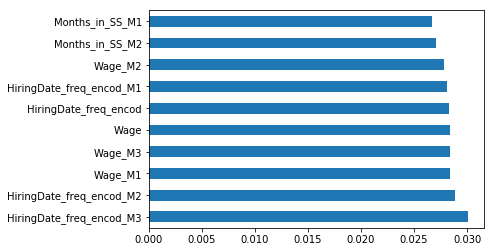

In [676]:
#X_train_act = pd.DataFrame(X_train_, columns=clm)
print('Feature Importance:')
display(X_train_new.columns[np.argsort(model_new.feature_importances_)])
(pd.Series(model_new.feature_importances_, index=X_train_new.columns)
   .nlargest(10)
   .plot(kind='barh'))

In [695]:
kfold = 5
def model__tune(model_long_feat_vect):
    q = 1
    for train_indices, test_indices in k_fold.split(X_train_new, y_train_new):
        model_long_feat_vect.fit(X_train_new.values[train_indices], y_train_new.values[train_indices])
        print('F_beta score:')
        print(fbeta_score(y_train_new.values[test_indices],
                             model_long_feat_vect.predict(X_train_new.values[test_indices]),
                             beta=1.7))
#         print(f1_score(y_train_.values[test_indices],
#                        model_long_feat_vect.predict(X_train_.values[test_indices])))  # ,
        q = q * (fbeta_score(y_train_new.values[test_indices],
                             model_long_feat_vect.predict(X_train_new.values[test_indices]),
                             average='macro',
                             beta=1.7)) ** (3 / 4) * (recall_score(y_train_new.values[test_indices],
                                                                    model_long_feat_vect.predict(
                                                                        X_train_new.values[test_indices]),
                                                                    pos_label=0) ** (1 / 4))
        return (q ** (1 / kfold))  # because k-fold = 5

def objective_params(params):
    params_model = {
        # 'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': int(params['max_features']),
        'criterion': params['criterion']
                    }
    print(params_model)
    model_long_feat_vect = RandomForestClassifier(**params_model, class_weight='balanced', n_jobs=-1)
    score = model__tune(model_long_feat_vect)
    print(score)
    return -score

space = {
    # 'max_depth': hp.quniform('max_depth', 3,25, 1),
    'max_features': hp.quniform('max_features', 5,35, 3),
    # 'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 25, 500, 10),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 15, 1),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'seed': hp.choice('seed', [10])
}
k_fold = StratifiedKFold(n_splits=kfold)
best = fmin(fn=objective_params,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

print('Best params:', best)

print('Apply best model:')
best = space_eval(space, best)
model_long_feat_vect = RandomForestClassifier(class_weight='balanced',
                                     # bootstrap=True,
                                     min_samples_leaf=np.int(best['min_samples_leaf']),
                                     n_estimators=np.int(best['n_estimators']),
                                     criterion=best['criterion'],
                                     # max_depth = np.int(best['max_depth']),
                                     # max_features = np.int(best['max_features']),
                                     random_state=42
                                     )
model_long_feat_vect.fit(X_train_new, y_train_new)
print("\nClassification Report Train:<", str(train_date))
print(pd.crosstab(y_train_new, model_long_feat_vect.predict(X_train_new)))
print(classification_report(y_train_new, model_long_feat_vect.predict(X_train_new)))
print('\nTest:>' + str(train_date) + '<' + str(test_date))
print(pd.crosstab(y_test_new, model_long_feat_vect.predict(X_test_new)))
print('Classification Report Test:')
print(classification_report(y_test_new, model_long_feat_vect.predict(X_test_new)))
print('\nTest1, there are =', str(train_date))
print(pd.crosstab(y_test1_new, model_long_feat_vect.predict(X_test1_new)))
print(classification_report(y_test1_new, model_long_feat_vect.predict(X_test1_new)))

{'n_estimators': 410, 'min_samples_leaf': 11, 'max_features': 15, 'criterion': 'gini'}
F_beta score:                                                                  
0.03649383951466633                                                            
0.9032984568188752                                                             
{'n_estimators': 270, 'min_samples_leaf': 6, 'max_features': 33, 'criterion': 'entropy'}
F_beta score:                                                                  
0.0                                                                            
0.8988967860199194                                                             
{'n_estimators': 390, 'min_samples_leaf': 2, 'max_features': 30, 'criterion': 'gini'}
F_beta score:                                                                  
0.012826431020838826                                                           
0.9010053814759718                                                             
{'n_estimators': 2

{'n_estimators': 240, 'min_samples_leaf': 14, 'max_features': 27, 'criterion': 'gini'}
F_beta score:                                                                  
0.0462709646722969                                                             
0.90363933677652                                                               
{'n_estimators': 170, 'min_samples_leaf': 3, 'max_features': 30, 'criterion': 'entropy'}
F_beta score:                                                                  
0.0                                                                            
0.8992144527691301                                                             
{'n_estimators': 140, 'min_samples_leaf': 8, 'max_features': 24, 'criterion': 'gini'}
F_beta score:                                                                  
0.024754995545373554                                                           
0.9019977362667976                                                             
{'n_estimators': 2

0.907840870615876                                                              
100%|████████| 100/100 [07:12<00:00,  3.06s/it, best loss: -0.9103614640893886]
Best params: {'criterion': 1, 'max_features': 6.0, 'min_samples_leaf': 15.0, 'n_estimators': 60.0, 'seed': 0}
Apply best model:

Classification Report Train:< 2018-10-01 00:00:00
col_0       0     1
target             
0       22590   439
1          16  1000
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23029
           1       0.69      0.98      0.81      1016

    accuracy                           0.98     24045
   macro avg       0.85      0.98      0.90     24045
weighted avg       0.99      0.98      0.98     24045


Test:>2018-10-01 00:00:00<2018-12-01
col_0      0   1
target          
0       4113  41
1         93  12
Classification Report Test:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4154
           

In [696]:
X_apply_new.shape

(12624, 132)

In [697]:
print('APPLY MOdel on:')
print('Data >', str(train_date_new))
print('\nFinally predict_proba:')
#result = data_df_last[data_df_last.index.isin(X_apply.index) == True]
result_long_df = long_feat_vect[long_feat_vect['Date']>train_date_new]

result_long_df.shape

APPLY MOdel on:
Data > 2018-10-01 00:00:00

Finally predict_proba:


(12624, 135)

In [698]:
pred_class_new = model_long_feat_vect.predict(X_apply_new)

In [699]:
result_long_df.tail()

Date                            EmployeeID  target  Utilization HourVacation HourSickness HourMobileReserve HourLockedReserve      Wage BonusOneTime   APM Correct_MonthOnPosition Correct_MonthOnSalary  Date_label  PositionLevel_freq_encod  OnSite_freq_encod  IsInternalProject_WoE  LanguageLevelID_freq_encod  CompetenceGroupID_freq_encod  IsTrainee_WoE  SBUID_freq_encod  DevCenterID_freq_encod  FunctionalOfficeID_0  FunctionalOfficeID_1  FunctionalOfficeID_2  FunctionalOfficeID_3  FunctionalOfficeID_4  FunctionalOfficeID_5  FunctionalOfficeID_6  PaymentTypeId_0  PaymentTypeId_1  PaymentTypeId_2  PaymentTypeId_3  PaymentTypeId_4  Months_in_SS  HiringDate_freq_encod  Utilization_M1 HourVacation_M1 HourSickness_M1 HourMobileReserve_M1 HourLockedReserve_M1   Wage_M1 BonusOneTime_M1  APM_M1 Correct_MonthOnPosition_M1 Correct_MonthOnSalary_M1  Date_label_M1  PositionLevel_freq_encod_M1  OnSite_freq_encod_M1  IsInternalProject_WoE_M1  LanguageLevelID_freq_encod_M1  \
40804 2018-12-01  FFED12A3-5B28-4101-908A-2851CBADE045       0       0.0000            0            0                 0                 0  0.215524          178   0.0                      59                    13    0.024642                  0.237001           0.990899              -3.506673                    0.028209                      0.261639      -3.334091          0.035370                0.538669                 0.125                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                1           117               0.004224          0.0000               0               0                    0                    0  0.228089               0     0.0                         56                       10       0.050327                     0.237001              0.990899                 -3.506673                       0.028209   
40805 2019-01-01  FFED12A3-5B28-4101-908A-2851CBADE045       0       0.0000            0            0                 0                 0  0.265196            0   0.0                      60                     1    0.012592                  0.237001           0.990899              -3.506673                    0.028209                      0.261639      -3.334091          0.035370                0.538669                 0.125                 -0.75                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                1           118               0.004224          0.0000              72               0                    0                    0  0.225469             255     0.0                         57                       11       0.048132                     0.237001              0.990899                 -3.506673                       0.028209   
40810 2018-11-01  FFF3B179-1D20-40FF-A330-A051BDF37301       0       1.0284            0            0                 0                 0  0.148063            0  73.0                       3                     3    0.034627                  0.233503           0.990899              -3.277742                    0.146030                      0.096991      -3.334091          0.025562                0.538669                 0.125                  0.25                -0.625                  -0.5                -0.375                 -0.25                -0.125                0                0                0                1                0             7               0.018147          0.7528              88               0                    0                    0  0.117792               0    85.0                          5                        4       0.052081                     0.063216              0.990899                 -3.277742                       0.146030   
40811 2018-12-01  FFF3B179-1D20-40FF-A330-A051BDF37301       0      

C:\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


('Totally, There are EmployeeIDs:', 4261)
Classification result_long_df 0    12485
1      139
Name: prediction_class, dtype: int64
count    12624.000000
mean         0.167085
std          0.119650
min          0.000000
25%          0.071483
50%          0.141085
75%          0.242993
max          0.732587
Name: predict_probability, dtype: float64


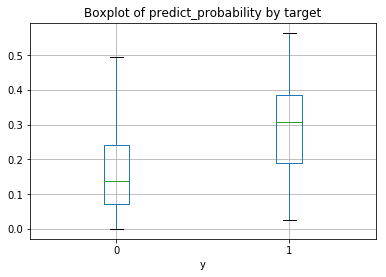

In [700]:
result_long_df['prediction_class'] = pred_class_new
res_proba_new = pd.DataFrame({'y': y_apply_new, 'pred_prob': model_long_feat_vect.predict_proba(X_apply_new)[:, 1]})
bp1 = res_proba_new.boxplot('pred_prob', 'y', showfliers=False)
plt.suptitle('')
plt.title('Boxplot of predict_probability by target')
result_long_df['predict_probability'] = res_proba_new['pred_prob']
print(('Totally, There are EmployeeIDs:', len(result_long_df.EmployeeID.unique())))
print('Classification result_long_df', result_long_df.prediction_class.value_counts())
print(result_long_df.predict_probability.describe())

In [701]:
len(result_long_df.EmployeeID.unique())

4261

[0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675]


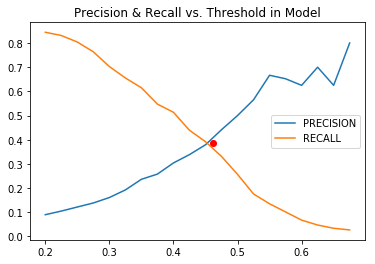

Coordinates of interseption_point is: (0.4625, 0.3859)
So, Threshold is equals:  0.4625


In [702]:
threshold_new = defineThresholdForModel(model_long_feat_vect, X_test1_new, y_test1_new)

In [703]:
threshold_new

0.4625

# applly on target file....
<a id="apply2_target_on_long_feat_vector"></a>

In [704]:
result_long_df.Date.unique()

array(['2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [710]:
list(cols)

['PaymentTypeId_1_M1',
 'APM_M1',
 'IsInternalProject_WoE',
 'PositionLevel_freq_encod',
 'FunctionalOfficeID_4_M1',
 'Months_in_SS_M1',
 'IsTrainee_WoE',
 'Date_label_M3',
 'IsInternalProject_WoE_M1',
 'Wage_M2',
 'PaymentTypeId_2_M1',
 'FunctionalOfficeID_3_M1',
 'FunctionalOfficeID_5_M1',
 'FunctionalOfficeID_1_M3',
 'Utilization_M2',
 'FunctionalOfficeID_5_M3',
 'FunctionalOfficeID_0',
 'HourSickness_M3',
 'PaymentTypeId_3_M1',
 'HourSickness_M1',
 'FunctionalOfficeID_6_M3',
 'FunctionalOfficeID_3',
 'APM',
 'FunctionalOfficeID_2',
 'FunctionalOfficeID_3_M2',
 'CompetenceGroupID_freq_encod_M3',
 'PaymentTypeId_1_M3',
 'HourLockedReserve_M2',
 'CompetenceGroupID_freq_encod_M2',
 'Months_in_SS_M3',
 'HiringDate_freq_encod_M2',
 'IsTrainee_WoE_M3',
 'FunctionalOfficeID_0_M1',
 'HourMobileReserve_M3',
 'HourMobileReserve',
 'DevCenterID_freq_encod_M1',
 'FunctionalOfficeID_1_M2',
 'HourMobileReserve_M2',
 'Utilization_M1',
 'Utilization',
 'FunctionalOfficeID_1_M1',
 'Correct_MonthOnSa

In [706]:
empl_common_long = list(set(target.EmployeeID.unique()).intersection(set(result_long_df.EmployeeID.unique())))
len(empl_common_long)

4154

In [711]:
df1 = target[['EmployeeID', 'target']]
df1 = df1[df1['EmployeeID'].isin(empl_common_)==True]

df2 = result_long_df[['Date','EmployeeID']+cols]
df2 = df2[df2['EmployeeID'].isin(empl_common_long)==True]
#df2 = df2[clm]
df2.columns

Index(['Date', 'EmployeeID', 'PaymentTypeId_1_M1', 'APM_M1', 'IsInternalProject_WoE', 'PositionLevel_freq_encod', 'FunctionalOfficeID_4_M1', 'Months_in_SS_M1', 'IsTrainee_WoE', 'Date_label_M3',
       ...
       'PaymentTypeId_3', 'HourVacation_M3', 'HourSickness', 'FunctionalOfficeID_4', 'PaymentTypeId_4_M3', 'PaymentTypeId_0_M3', 'BonusOneTime_M2', 'CompetenceGroupID_freq_encod', 'OnSite_freq_encod_M3', 'HourLockedReserve_M1'], dtype='object', length=134)

In [712]:
len(df1.EmployeeID.unique()), len(df2.EmployeeID.unique())

(4154, 4154)

In [713]:
df2_res = pd.merge(df2, df1[['EmployeeID','target']], on ='EmployeeID', how='inner')

In [714]:
len(df2_res.EmployeeID.unique())

4154

In [715]:
dismm = df2_res[df2_res['target']==1]
len(dismm.EmployeeID.unique())

176

In [716]:
df2_res.target.value_counts(), df1.target.value_counts()

(0    11932
 1      528
 Name: target, dtype: int64, 0    3978
 1     176
 Name: target, dtype: int64)

In [381]:
#feature_vector = pd.concat([df1, df2, axis=1)

In [382]:
#feature_vector.head()

In [717]:
df2_res.Date.unique()

array(['2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [718]:
feature_vector_long = df2_res.copy()

In [719]:
feature_vector_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12460 entries, 0 to 12459
Columns: 135 entries, Date to target
dtypes: datetime64[ns](1), float64(98), int64(7), object(29)
memory usage: 12.9+ MB


In [720]:
feature_vector_long.Date.unique()

array(['2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [721]:
feature_vector_long['Date']=feature_vector_long['Date'] + pd.DateOffset(months=3)

In [722]:
feature_vector_long.Date.unique()

array(['2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [723]:
X_apply_new.columns

Index(['PaymentTypeId_1_M1', 'APM_M1', 'IsInternalProject_WoE', 'PositionLevel_freq_encod', 'FunctionalOfficeID_4_M1', 'Months_in_SS_M1', 'IsTrainee_WoE', 'Date_label_M3', 'IsInternalProject_WoE_M1', 'Wage_M2',
       ...
       'PaymentTypeId_3', 'HourVacation_M3', 'HourSickness', 'FunctionalOfficeID_4', 'PaymentTypeId_4_M3', 'PaymentTypeId_0_M3', 'BonusOneTime_M2', 'CompetenceGroupID_freq_encod', 'OnSite_freq_encod_M3', 'HourLockedReserve_M1'], dtype='object', length=132)

In [724]:
X_apply1_long = feature_vector_long[X_apply_new.columns]

In [725]:
y_apply1_long = feature_vector_long.target

In [726]:
X_apply1_long .shape, y_apply1_long.shape

((12460, 132), (12460,))

## Final result on apply target:
<a id="result_on_apply2_long_feat_vector"></a>

In [727]:
pred_class1_long = model_long_feat_vect.predict(X_apply1_long)

('Totally, There are EmployeeIDs:', 4154)
Classification feature_vector_long
 0    12336
1      124
Name: prediction_class, dtype: int64
Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     11932
           1       0.12      0.03      0.05       528

    accuracy                           0.95     12460
   macro avg       0.54      0.51      0.51     12460
weighted avg       0.92      0.95      0.94     12460

count    12460.000000
mean         0.165346
std          0.118443
min          0.000000
25%          0.070645
50%          0.139464
75%          0.240671
max          0.642514
Name: predict_probability, dtype: float64


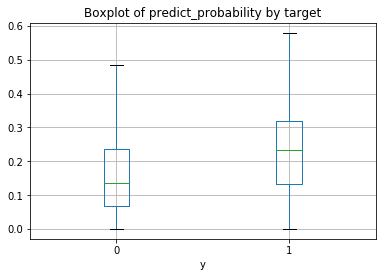

In [728]:
feature_vector_long['prediction_class'] = pred_class1_long
res_proba_long = pd.DataFrame({'y': y_apply1_long, 'pred_prob': model_long_feat_vect.predict_proba(X_apply1_long)[:, 1]})
bp2 = res_proba_long.boxplot('pred_prob', 'y', showfliers=False)
plt.suptitle('')
plt.title('Boxplot of predict_probability by target')
feature_vector_long['predict_probability'] = res_proba_long['pred_prob']
print(('Totally, There are EmployeeIDs:', len(feature_vector_long.EmployeeID.unique())))
print('Classification feature_vector_long\n', feature_vector_long.prediction_class.value_counts())
print("Report:\n")
print(classification_report(y_apply1_long, model_long_feat_vect.predict(X_apply1_long)))
print(feature_vector_long.predict_probability.describe())

C:\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675]


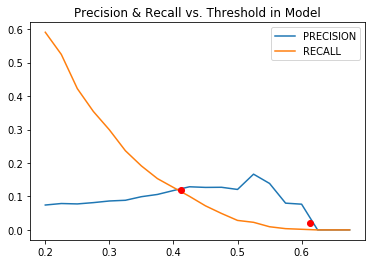

Coordinates of interseption_point is: (0.6125, 0.0197)
So, Threshold is equals:  0.6125


In [729]:
threshold_long1 = defineThresholdForModel(model_long_feat_vect, X_apply1_long, y_apply1_long)

In [730]:
threshold_long1

0.6125

In [731]:
feature_vector_long[feature_vector_long['EmployeeID']=='00EDA2E5-78A3-4FB4-9EED-183E04A89523']

Empty DataFrame
Columns: [Date, EmployeeID, PaymentTypeId_1_M1, APM_M1, IsInternalProject_WoE, PositionLevel_freq_encod, FunctionalOfficeID_4_M1, Months_in_SS_M1, IsTrainee_WoE, Date_label_M3, IsInternalProject_WoE_M1, Wage_M2, PaymentTypeId_2_M1, FunctionalOfficeID_3_M1, FunctionalOfficeID_5_M1, FunctionalOfficeID_1_M3, Utilization_M2, FunctionalOfficeID_5_M3, FunctionalOfficeID_0, HourSickness_M3, PaymentTypeId_3_M1, HourSickness_M1, FunctionalOfficeID_6_M3, FunctionalOfficeID_3, APM, FunctionalOfficeID_2, FunctionalOfficeID_3_M2, CompetenceGroupID_freq_encod_M3, PaymentTypeId_1_M3, HourLockedReserve_M2, CompetenceGroupID_freq_encod_M2, Months_in_SS_M3, HiringDate_freq_encod_M2, IsTrainee_WoE_M3, FunctionalOfficeID_0_M1, HourMobileReserve_M3, HourMobileReserve, DevCenterID_freq_encod_M1, FunctionalOfficeID_1_M2, HourMobileReserve_M2, Utilization_M1, Utilization, FunctionalOfficeID_1_M1, Correct_MonthOnSalary_M3, Utilization_M3, LanguageLevelID_freq_encod_M1, FunctionalOfficeID_2_M3, PaymentTypeId_4_M1, SBUID_freq_encod_M1, SBUID_freq_encod_M2, DevCenterID_freq_encod, HourVacation, FunctionalOfficeID_2_M1, BonusOneTime_M1, FunctionalOfficeID_5_M2, IsTrainee_WoE_M1, FunctionalOfficeID_0_M2, HourMobileReserve_M1, Months_in_SS_M2, Date_label_M1, SBUID_freq_encod_M3, Wage_M1, Months_in_SS, HourVacation_M1, Correct_MonthOnSalary_M1, PaymentTypeId_1_M2, IsTrainee_WoE_M2, Correct_MonthOnPosition_M1, CompetenceGroupID_freq_encod_M1, Correct_MonthOnPosition_M3, FunctionalOfficeID_2_M2, APM_M3, PaymentTypeId_3_M3, LanguageLevelID_freq_encod, Correct_MonthOnPosition_M2, HiringDate_freq_encod, IsInternalProject_WoE_M2, Correct_MonthOnSalary_M2, HiringDate_freq_encod_M1, PaymentTypeId_0_M2, Wage, FunctionalOfficeID_4_M2, PaymentTypeId_0_M1, OnSite_freq_encod_M1, APM_M2, DevCenterID_freq_encod_M3, PaymentTypeId_2_M2, PositionLevel_freq_encod_M3, IsInternalProject_WoE_M3, LanguageLevelID_freq_encod_M3, LanguageLevelID_freq_encod_M2, FunctionalOfficeID_0_M3, HourVacation_M2, Correct_MonthOnSalary, PaymentTypeId_2, OnSite_freq_encod_M2, FunctionalOfficeID_5, HourLockedReserve_M3, FunctionalOfficeID_6_M1, SBUID_freq_encod, ...]
Index: []

In [732]:
feature_vector_long[feature_vector_long['prediction_class']==1][['EmployeeID']]

EmployeeID
49     00E30C7A-3400-4A74-B5A8-1532C766DB24
141    02E81497-FDCE-4E14-82A1-7ADAAECEDDBE
142    02E81497-FDCE-4E14-82A1-7ADAAECEDDBE
143    02E81497-FDCE-4E14-82A1-7ADAAECEDDBE
242    05AC1747-5C2A-4FEF-B72D-A021EA6E67B1
315    0764945E-454F-4E7E-8087-A723BB96BC46
316    0764945E-454F-4E7E-8087-A723BB96BC46
431    0AD06BC3-60F0-4CA8-9F1C-82EBF236BFB9
478    0BCA4EA2-6EF1-450E-B1D7-CFBF95EE2D44
479    0BCA4EA2-6EF1-450E-B1D7-CFBF95EE2D44
905    1577875C-6012-4B0A-B770-2680E187B18B
906    1577875C-6012-4B0A-B770-2680E187B18B
907    1577875C-6012-4B0A-B770-2680E187B18B
928    162F7A2B-6BC5-41E3-BF91-9537EEA9DE26
989    17247825-2F09-4BD9-93C0-AC0CABFBA02B
990    17247825-2F09-4BD9-93C0-AC0CABFBA02B
1082   18B96550-E1FE-4EF2-82DA-3C9240E4BB1D
1452   20D8444E-C17A-44F7-B1ED-F1F6AD4F2CCC
1481   21761BF9-7EAA-4776-BE9A-10F9B373177B
1482   21761BF9-7EAA-4776-BE9A-10F9B373177B
1483   21761BF9-7EAA-4776-BE9A-10F9B373177B
1529   227D0375-F97C-4021-8987-FB69D4F38DAC
1605   23ECF686-4458-4261-B57D-4477671D020D
1606   23ECF686-4458-4261-B57D-4477671D020D
1772   27C2A79F-F0C5-4D94-BDCC-EA1F22F89DA3
2000   2BE64A9B-3FD2-4FF7-9D04-F8E0FF29BB3F
2025   2C5926D3-0A17-400F-BAD7-56909CE75835
2444   35F26A93-5E6F-4202-B2E9-50EC7DBECA3E
2445   35F26A93-5E6F-4202-B2E9-50EC7DBECA3E
2772   3C9F6C74-0934-4006-8E0C-D96DA9DA721D
2927   3F47D413-D42B-4D67-B86E-F16AF8E69059
2928   3F47D413-D42B-4D67-B86E-F16AF8E69059
2929   3F47D413-D42B-4D67-B86E-F16AF8E69059
3000   41978240-6D32-4EAA-974E-F9B1A4C2BC74
3001   41978240-6D32-4EAA-974E-F9B1A4C2BC74
3062   429BDD15-3A18-4B24-BAF7-368DB6C0F939
3212   45695625-0E01-4F5D-8B2B-45AAC271E52B
3446   497E5ED7-AFC8-48F8-A3D4-25252F1BC128
3447   497E5ED7-AFC8-48F8-A3D4-25252F1BC128
3489   49FC8E64-EC6B-44D6-9CD5-6B241446CA34
3490   49FC8E64-EC6B-44D6-9CD5-6B241446CA34
3609   4C2FFAE7-C619-4783-89DE-AB117D25859E
3671   4D7AF8A6-F4BC-4B6A-913A-C84B21F2CE1E
3762   4EEDCE29-1269-4554-A447-651FCAEABFBD
3763   4EEDCE29-1269-4554-A447-651FCAEABFBD
4220   58D186EA-7140-4D0B-97B6-DE5C3E154B0B
4221   58D186EA-7140-4D0B-97B6-DE5C3E154B0B
4222   58D186EA-7140-4D0B-97B6-DE5C3E154B0B
4401   5D70B8AC-2AEC-40AB-993A-96F48F6CCF3B
4443   5E731939-A150-4393-BDBA-80959FF1FD99
4444   5E731939-A150-4393-BDBA-80959FF1FD99
4724   6344194E-881B-4707-8920-729449B0239C
4725   6344194E-881B-4707-8920-729449B0239C
4726   6344194E-881B-4707-8920-729449B0239C
4862   65FA4ED6-67FA-428C-8B48-D191933B7BA7
4934   679E9650-9555-4531-B0EC-C2F3BDF799C5
4935   679E9650-9555-4531-B0EC-C2F3BDF799C5
4936   679E9650-9555-4531-B0EC-C2F3BDF799C5
4988   6871EE54-6687-4708-91C8-EF7067BF9AB8
5265   6DDE8DB1-C7BC-43FD-9E40-6084DE63C4E9
5285   6E91AC7B-DCD7-4534-8338-2630A50818F5
5438   714EAB94-077C-4583-AFC2-B9635C66060C
5489   7220FCA9-6D4C-4422-A9EE-771D0C2E130D
5490   7220FCA9-6D4C-4422-A9EE-771D0C2E130D
5491   7220FCA9-6D4C-4422-A9EE-771D0C2E130D
5679   76660F38-3AB4-4C87-9B80-226AD5198A53
5680   76660F38-3AB4-4C87-9B80-226AD5198A53
6788   8E279CF1-B0F8-4DE3-9098-F457CA2ED5CC
6827   8ECE96B6-6560-4CBC-AD66-04BD40714497
6844   8EF8A00C-B051-4A00-86DD-AE8B1444766F
7248   96D535D9-4EA4-465B-B5B1-6DF371FE6242
7249   96D535D9-4EA4-465B-B5B1-6DF371FE6242
7667   9F3DED0A-6D1F-45DB-ADBD-0CD8D83FCFA9
7668   9F3DED0A-6D1F-45DB-ADBD-0CD8D83FCFA9
7669   9F3DED0A-6D1F-45DB-ADBD-0CD8D83FCFA9
7769   A0F1E650-1933-44B5-A0BE-363B5730EB67
7770   A0F1E650-1933-44B5-A0BE-363B5730EB67
7771   A0F1E650-1933-44B5-A0BE-363B5730EB67
7914   A44DEE94-575A-4B78-92E3-6D1AFEC91388
7915   A44DEE94-575A-4B78-92E3-6D1AFEC91388
8026   A6E4C7BC-701B-4D7A-BFB8-417C74187C83
8159   A9764DD6-EDC6-46EF-B9F5-8CB07673DFDA
8160   A9764DD6-EDC6-46EF-B9F5-8CB07673DFDA
8161   A9764DD6-EDC6-46EF-B9F5-8CB07673DFDA
8187   A9A6B139-A8E1-4BF8-9CE7-37649F9EA9D6
8188   A9A6B139-A8E1-4BF8-9CE7-37649F9EA9D6
8285   AB8C59A9-F44B-4837-979C-05BA7C137669
8443   AEA0CD09-19F9-405C-82F3-203E836E69E1
8602   B1C27A7F-BB2A-4941-B2B9-3BD8E970EBB0
8717   B45287E6-F017-4680-9074-008C1E3E486D
8718   B45287E6-F017-4680-907

In [733]:
feature_vector_long[feature_vector_long['EmployeeID']=='02E81497-FDCE-4E14-82A1-7ADAAECEDDBE']

Date                            EmployeeID  PaymentTypeId_1_M1  APM_M1  IsInternalProject_WoE  PositionLevel_freq_encod  FunctionalOfficeID_4_M1  Months_in_SS_M1  IsTrainee_WoE  Date_label_M3  IsInternalProject_WoE_M1   Wage_M2  PaymentTypeId_2_M1  FunctionalOfficeID_3_M1  FunctionalOfficeID_5_M1  FunctionalOfficeID_1_M3  Utilization_M2  FunctionalOfficeID_5_M3  FunctionalOfficeID_0 HourSickness_M3  PaymentTypeId_3_M1 HourSickness_M1  FunctionalOfficeID_6_M3  FunctionalOfficeID_3   APM  FunctionalOfficeID_2  FunctionalOfficeID_3_M2  CompetenceGroupID_freq_encod_M3  PaymentTypeId_1_M3 HourLockedReserve_M2  CompetenceGroupID_freq_encod_M2  Months_in_SS_M3  HiringDate_freq_encod_M2  IsTrainee_WoE_M3  FunctionalOfficeID_0_M1 HourMobileReserve_M3 HourMobileReserve  DevCenterID_freq_encod_M1  FunctionalOfficeID_1_M2 HourMobileReserve_M2  Utilization_M1  Utilization  FunctionalOfficeID_1_M1 Correct_MonthOnSalary_M3  Utilization_M3  LanguageLevelID_freq_encod_M1  \
141 2019-02-01  02E81497-FDCE-4E14-82A1-7ADAAECEDDBE                 0.0    98.0              -3.506673                  0.063216                   -0.375              0.0      -3.548326       0.048132                 -3.277742  0.154643                 0.0                     -0.5                    -0.25                     0.25             0.0                    -0.25                 0.125               0                 1.0               0                   -0.125                  -0.5  99.0                -0.625                     -0.5                         0.031055                 0.0                    0                         0.031055              2.0                  0.017078         -3.548326                    0.125                    0                 0                   0.538669                     0.25                    0             0.0       0.0000                    -0.75                        3          0.0000                       0.126305   
142 2019-03-01  02E81497-FDCE-4E14-82A1-7ADAAECEDDBE                 0.0    99.0              -3.277742                  0.233503                   -0.375              1.0      -3.548326       0.034627                 -3.277742  0.154643                 1.0                     -0.5                    -0.25                     0.25             0.0                    -0.25                 0.125               8                 0.0               0                   -0.125                  -0.5  76.0                -0.625                     -0.5                         0.031055                 0.0                    0                         0.031055              3.0                  0.017078         -3.548326                    0.125                    0                 0                   0.538669                     0.25                    0             0.0       0.1111                     0.25                        4          0.0000                       0.126305   
143 2019-04-01  02E81497-FDCE-4E14-82A1-7ADAAECEDDBE                 0.0    99.0              -3.277742                  0.233503                   -0.375              2.0      -3.548326       0.024642                 -3.277742  0.153985                 1.0                     -0.5                    -0.25                     0.25             0.0                    -0.25                 0.125              16                 0.0               0                   -0.125                  -0.5  72.0                -0.625                     -0.5                         0.031055                 0.0                    0                         0.031055              4.0                  0.017078         -3.548326                    0.125                    0                 0                   0.538669                     0.25                    0             0.0       0.0000                     0.25                        1          0.1111                       0.126305   

     FunctionalOfficeID_2_M3  PaymentTypeId_4_M1  SBUID_freq_encod_M1  SBUID_freq

In [734]:
feature_vector_long[feature_vector_long['EmployeeID']=='A0F1E650-1933-44B5-A0BE-363B5730EB67']

Date                            EmployeeID  PaymentTypeId_1_M1  APM_M1  IsInternalProject_WoE  PositionLevel_freq_encod  FunctionalOfficeID_4_M1  Months_in_SS_M1  IsTrainee_WoE  Date_label_M3  IsInternalProject_WoE_M1   Wage_M2  PaymentTypeId_2_M1  FunctionalOfficeID_3_M1  FunctionalOfficeID_5_M1  FunctionalOfficeID_1_M3  Utilization_M2  FunctionalOfficeID_5_M3  FunctionalOfficeID_0 HourSickness_M3  PaymentTypeId_3_M1 HourSickness_M1  FunctionalOfficeID_6_M3  FunctionalOfficeID_3  APM  FunctionalOfficeID_2  FunctionalOfficeID_3_M2  CompetenceGroupID_freq_encod_M3  PaymentTypeId_1_M3 HourLockedReserve_M2  CompetenceGroupID_freq_encod_M2  Months_in_SS_M3  HiringDate_freq_encod_M2  IsTrainee_WoE_M3  FunctionalOfficeID_0_M1 HourMobileReserve_M3 HourMobileReserve  DevCenterID_freq_encod_M1  FunctionalOfficeID_1_M2 HourMobileReserve_M2  Utilization_M1  Utilization  FunctionalOfficeID_1_M1 Correct_MonthOnSalary_M3  Utilization_M3  LanguageLevelID_freq_encod_M1  \
7769 2019-02-01  A0F1E650-1933-44B5-A0BE-363B5730EB67                 0.0     0.0              -3.506673                  0.233503                   -0.375              9.0      -3.334091       0.048132                 -3.506673  0.162211                 0.0                     -0.5                    -0.25                     0.25             0.0                    -0.25                 0.125              16                 1.0               0                   -0.125                  -0.5  0.0                -0.625                     -0.5                         0.014685                 0.0                    0                         0.014685             11.0                  0.024529         -3.334091                    0.125                  168               176                   0.538669                     0.25                  168             0.0          0.0                     0.25                        4             0.0                       0.126305   
7770 2019-03-01  A0F1E650-1933-44B5-A0BE-363B5730EB67                 0.0     0.0              -3.506673                  0.233503                   -0.375             10.0      -3.334091       0.034627                 -3.506673  0.162211                 0.0                     -0.5                    -0.25                     0.25             0.0                    -0.25                 0.125               0                 1.0               0                   -0.125                  -0.5  0.0                -0.625                     -0.5                         0.014685                 0.0                    0                         0.014685             12.0                  0.024529         -3.334091                    0.125                  176               160                   0.538669                     0.25                  168             0.0          0.0                     0.25                        5             0.0                       0.126305   
7771 2019-04-01  A0F1E650-1933-44B5-A0BE-363B5730EB67                 0.0     0.0              -3.506673                  0.233503                   -0.375             11.0      -3.334091       0.024642                 -3.506673  0.162211                 0.0                     -0.5                    -0.25                     0.25             0.0                    -0.25                 0.125               0                 1.0              16                   -0.125                  -0.5  0.0                -0.625                     -0.5                         0.014685                 0.0                    0                         0.014685             13.0                  0.024529         -3.334091                    0.125                  160               168                   0.538669                     0.25                  176             0.0          0.0                     0.25                        6             0.0                       0.126305   

      FunctionalOfficeID_2_M3  PaymentTypeId_4_M1  SBUID_freq_encod_M1  SBUID_freq

In [736]:
display(feature_vector_long.target.value_counts(),feature_vector_long.prediction_class.value_counts() )

0    11932
1      528
Name: target, dtype: int64

0    12336
1      124
Name: prediction_class, dtype: int64